In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
sys.path.append('/content/drive/MyDrive/EcolesIngenieur/NTNU/MachineLearning/GroupWork/')
import utils
#import settings
import pickle
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [3]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

In [4]:
#path = "/content/drive/MyDrive/EcolesIngenieur/NTNU/MachineLearning/GroupWork/"
#train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
#test = pd.read_csv(path+"test.csv")
#sample_submission = pd.read_csv(path+"sample_submission.csv")

# Réorganisation des df :

In [5]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

In [6]:
#plt.plot(train_c.isna())

In [7]:
train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test.rename(columns={'time': 'date_forecast'}, inplace=True)

train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [8]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

# Analyse des Nan

In [9]:
X_train_observed_a['snow_density:kgm3'].isna().sum()/len(X_train_observed_a)

0.9770453951748139

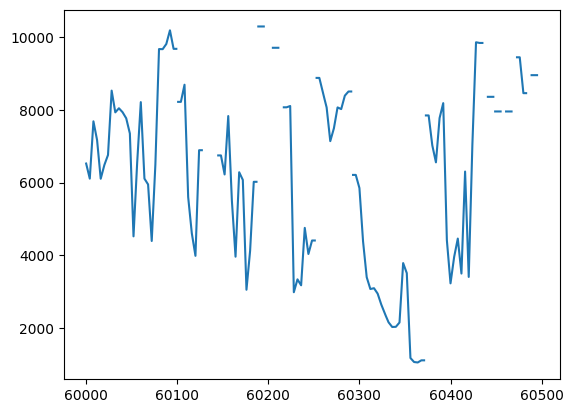

In [10]:
plt.plot(X_train_observed_a['ceiling_height_agl:m'][60000:60500])
#.plot(X_train_observed_a_nan['ceiling_height_agl:m'][60000:60500],ls="--")
#plt.plot(X_train_observed_a['cloud_base_agl:m'][60000:62000].isna())

In [11]:
X_train_observed_a.isna().sum(axis=0)/len(X_train_observed_a)

date_forecast                     0.000000
absolute_humidity_2m:gm3          0.000000
air_density_2m:kgm3               0.000000
ceiling_height_agl:m              0.187471
clear_sky_energy_1h:J             0.000000
clear_sky_rad:W                   0.000000
cloud_base_agl:m                  0.067971
dew_or_rime:idx                   0.000000
dew_point_2m:K                    0.000000
diffuse_rad:W                     0.000000
diffuse_rad_1h:J                  0.000000
direct_rad:W                      0.000000
direct_rad_1h:J                   0.000000
effective_cloud_cover:p           0.000000
elevation:m                       0.000000
fresh_snow_12h:cm                 0.000000
fresh_snow_1h:cm                  0.000000
fresh_snow_24h:cm                 0.000000
fresh_snow_3h:cm                  0.000000
fresh_snow_6h:cm                  0.000000
is_day:idx                        0.000000
is_in_shadow:idx                  0.000000
msl_pressure:hPa                  0.000000
precip_5min

**Conclusion** de l'analyse :    
- Il y a 3 variables avec des Nan
- Snow density est vide à 98% on la supprime
- les deux autres sont vide à 7 et 19% et ce sont des points manquant (problème dans la prise de mesure probablement)
- on décide donc de les compléter par prolongement (moyenne des points environnant)

In [12]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [13]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

In [14]:
X_train_observed_a_nan.isna().sum(axis=0)/len(X_train_observed_a_nan)

date_forecast                     0.0
absolute_humidity_2m:gm3          0.0
air_density_2m:kgm3               0.0
ceiling_height_agl:m              0.0
clear_sky_energy_1h:J             0.0
clear_sky_rad:W                   0.0
cloud_base_agl:m                  0.0
dew_or_rime:idx                   0.0
dew_point_2m:K                    0.0
diffuse_rad:W                     0.0
diffuse_rad_1h:J                  0.0
direct_rad:W                      0.0
direct_rad_1h:J                   0.0
effective_cloud_cover:p           0.0
elevation:m                       0.0
fresh_snow_12h:cm                 0.0
fresh_snow_1h:cm                  0.0
fresh_snow_24h:cm                 0.0
fresh_snow_3h:cm                  0.0
fresh_snow_6h:cm                  0.0
is_day:idx                        0.0
is_in_shadow:idx                  0.0
msl_pressure:hPa                  0.0
precip_5min:mm                    0.0
precip_type_5min:idx              0.0
pressure_100m:hPa                 0.0
pressure_50m

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [15]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [16]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [17]:
split_date_a = pd.to_datetime("2023-02-01") # on coupe à environ la moitié de estimated

In [18]:
# on coupe nos dataframe à une certaine date
pv_train_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] <= split_date_a].copy()
pv_test_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] > split_date_a].copy()

pv_train_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] <= split_date_a].copy()
pv_test_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] > split_date_a].copy()

pv_train_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] <= split_date_a].copy()
pv_test_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] > split_date_a].copy()

print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100)
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100)
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100)

train_a : (31926, 47)
test_a : (2135, 47)
Rapport test/total : 6.3
train_b : (30794, 47)
test_b : (2025, 47)
Rapport test/total : 6.2
train_c : (24518, 47)
test_c : (1553, 47)
Rapport test/total : 6.0


## Changement type de la date_forecast

In [19]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [20]:
pv_train_a.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm',
       'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p',
       'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms',
       'wind_speed_v_10m:ms

In [21]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [22]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Conversion du type de la date

In [23]:
'''
X_train_a[('date_forecast')] = X_train_a[('date_forecast')].values.astype("float64")
X_train_b[('date_forecast')] = X_train_b[('date_forecast')].values.astype("float64")
X_train_c[('date_forecast')] = X_train_c[('date_forecast')].values.astype("float64")
X_test_a[('date_forecast')] = X_test_a[('date_forecast')].values.astype("float64")
X_test_b[('date_forecast')] = X_test_b[('date_forecast')].values.astype("float64")
X_test_c[('date_forecast')] = X_test_c[('date_forecast')].values.astype("float64")
'''

'\nX_train_a[(\'date_forecast\')] = X_train_a[(\'date_forecast\')].values.astype("float64")\nX_train_b[(\'date_forecast\')] = X_train_b[(\'date_forecast\')].values.astype("float64")\nX_train_c[(\'date_forecast\')] = X_train_c[(\'date_forecast\')].values.astype("float64")\nX_test_a[(\'date_forecast\')] = X_test_a[(\'date_forecast\')].values.astype("float64")\nX_test_b[(\'date_forecast\')] = X_test_b[(\'date_forecast\')].values.astype("float64")\nX_test_c[(\'date_forecast\')] = X_test_c[(\'date_forecast\')].values.astype("float64")\n'

## Normalisation

In [24]:
def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : normalized_data = scaler.transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [25]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True)

In [26]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base : hyperparètre tuning

In [27]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

[0]	validation_0-rmse:883.53091	validation_1-rmse:901.26098
[1]	validation_0-rmse:699.90445	validation_1-rmse:723.89507
[2]	validation_0-rmse:586.96938	validation_1-rmse:622.04706
[3]	validation_0-rmse:517.93637	validation_1-rmse:552.68806
[4]	validation_0-rmse:474.54509	validation_1-rmse:508.11200


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:448.97082	validation_1-rmse:476.56167
[6]	validation_0-rmse:430.80569	validation_1-rmse:465.95115
[7]	validation_0-rmse:418.44008	validation_1-rmse:454.47509
[8]	validation_0-rmse:409.42051	validation_1-rmse:446.19706
[9]	validation_0-rmse:402.01864	validation_1-rmse:447.81428
[10]	validation_0-rmse:395.82950	validation_1-rmse:444.47201
[11]	validation_0-rmse:389.12421	validation_1-rmse:441.41406
[12]	validation_0-rmse:386.21218	validation_1-rmse:440.08476
[13]	validation_0-rmse:381.73802	validation_1-rmse:437.33244
[14]	validation_0-rmse:378.20735	validation_1-rmse:436.99267
[15]	validation_0-rmse:375.17447	validation_1-rmse:436.58768
[16]	validation_0-rmse:371.78049	validation_1-rmse:435.67027
[17]	validation_0-rmse:368.38920	validation_1-rmse:436.62989
[18]	validation_0-rmse:364.63820	validation_1-rmse:436.22468
[19]	validation_0-rmse:361.50369	validation_1-rmse:434.50411
[20]	validation_0-rmse:359.59516	validation_1-rmse:434.82361
[21]	validation_0-rmse:357.91

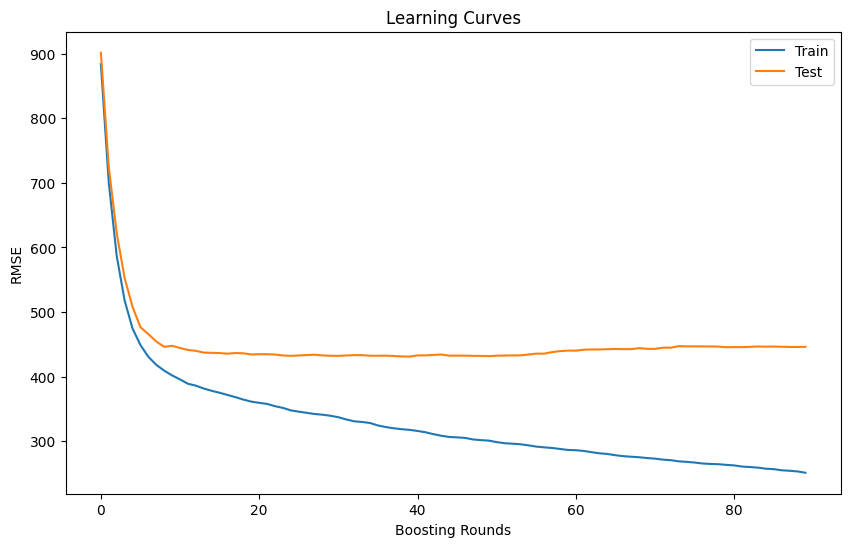

In [54]:
import os
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Vos hyperparamètres
hyperparameters = {
    'n_estimators': 10000,
    'max_depth': 6,
    'min_child_weight' : 15,
    'gamma' : 5, 
    #'eta' : 0.2,
}

# Entraînez le modèle
reg_a = xgb.XGBRegressor(**hyperparameters)
reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

# Récupérez la 50ème ligne avant la dernière (la plus petite valeur) pour les valeurs de validation
train_rmse = train_errors[-51]
test_rmse = test_errors[-51]

# Générez le nom du dossier en fonction des hyperparamètres et de leurs valeurs
folder_name = "_".join([f"{param}_{value}" for param, value in hyperparameters.items()])

# Spécifiez le chemin complet pour le dossier parent
output_parent_folder = r'C:\Users\verdi\OneDrive\Bureau\NTNU\Machine learning\Project\data\data\hyperparamètre\A'

# Assurez-vous que le dossier parent existe, sinon, créez-le
os.makedirs(output_parent_folder, exist_ok=True)

# Créez le dossier pour les fichiers avec le chemin complet
output_folder = os.path.join(output_parent_folder, folder_name)

# Assurez-vous que le dossier pour les fichiers existe, sinon, créez-le
os.makedirs(output_folder, exist_ok=True)

# Générez le nom du fichier pour les valeurs RMSE
filename = "_".join([f"{param}_{value}" for param, value in hyperparameters.items()]) + "_RMSE.csv"

# Créez un DataFrame pour les valeurs RMSE
data = {'Train RMSE 50th Last': [train_rmse], 'Test RMSE 50th Last': [test_rmse]}
df = pd.DataFrame(data)

# Enregistrez le DataFrame dans un fichier .csv avec les valeurs en colonnes
output_file_path = os.path.join(output_folder, filename)
df.to_csv(output_file_path, index=False)

# Tracez la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')

# Générez le nom du fichier pour la courbe d'apprentissage
learning_curve_filename = "_".join([f"{param}_{value}" for param, value in hyperparameters.items()]) + "_learning_curve.png"

# Enregistrez la courbe dans le dossier avec le chemin complet
learning_curve_file_path = os.path.join(output_folder, learning_curve_filename)
plt.savefig(learning_curve_file_path)

# Affichez le graphique (ou utilisez plt.show() pour l'afficher)
plt.show()


[0]	validation_0-rmse:153.51800	validation_1-rmse:143.66602


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:126.33832	validation_1-rmse:120.63381
[2]	validation_0-rmse:109.18517	validation_1-rmse:110.79447
[3]	validation_0-rmse:97.82038	validation_1-rmse:108.05909
[4]	validation_0-rmse:91.13022	validation_1-rmse:105.16461
[5]	validation_0-rmse:86.79353	validation_1-rmse:99.33284
[6]	validation_0-rmse:84.29761	validation_1-rmse:98.83438
[7]	validation_0-rmse:81.57878	validation_1-rmse:97.56663
[8]	validation_0-rmse:80.34310	validation_1-rmse:96.30747
[9]	validation_0-rmse:79.53743	validation_1-rmse:94.46784
[10]	validation_0-rmse:78.89718	validation_1-rmse:93.40191
[11]	validation_0-rmse:78.38962	validation_1-rmse:93.81696
[12]	validation_0-rmse:77.97628	validation_1-rmse:92.89203
[13]	validation_0-rmse:77.70234	validation_1-rmse:92.72348
[14]	validation_0-rmse:77.15665	validation_1-rmse:95.50939
[15]	validation_0-rmse:76.46318	validation_1-rmse:91.92829
[16]	validation_0-rmse:76.19398	validation_1-rmse:92.14062
[17]	validation_0-rmse:75.81814	validation_1-rmse:92.21658


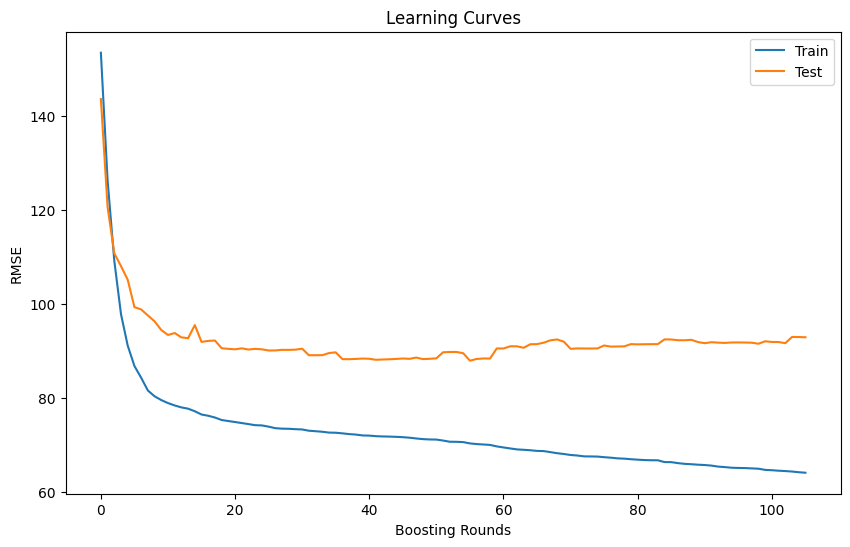

In [59]:
import os
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Vos hyperparamètres
hyperparameters = {
    'n_estimators': 1000,
    'max_depth': 4,
    'min_child_weight' : 200,
    'gamma' : 0, 
    #'eta' : 0.3,
}

# Entraînez le modèle
reg_b = xgb.XGBRegressor(**hyperparameters)
reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

# Récupérez la 50ème ligne avant la dernière (la plus petite valeur) pour les valeurs de validation
train_rmse = train_errors[-51]
test_rmse = test_errors[-51]

# Générez le nom du dossier en fonction des hyperparamètres et de leurs valeurs
folder_name = "_".join([f"{param}_{value}" for param, value in hyperparameters.items()])

# Spécifiez le chemin complet pour le dossier parent
output_parent_folder = r'C:\Users\verdi\OneDrive\Bureau\NTNU\Machine learning\Project\data\data\hyperparamètre\B'

# Assurez-vous que le dossier parent existe, sinon, créez-le
os.makedirs(output_parent_folder, exist_ok=True)

# Créez le dossier pour les fichiers avec le chemin complet
output_folder = os.path.join(output_parent_folder, folder_name)

# Assurez-vous que le dossier pour les fichiers existe, sinon, créez-le
os.makedirs(output_folder, exist_ok=True)

# Générez le nom du fichier pour les valeurs RMSE
filename = "_".join([f"{param}_{value}" for param, value in hyperparameters.items()]) + "_RMSE.csv"

# Créez un DataFrame pour les valeurs RMSE
data = {'Train RMSE 50th Last': [train_rmse], 'Test RMSE 50th Last': [test_rmse]}
df = pd.DataFrame(data)

# Enregistrez le DataFrame dans un fichier .csv avec les valeurs en colonnes
output_file_path = os.path.join(output_folder, filename)
df.to_csv(output_file_path, index=False)

# Tracez la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')

# Générez le nom du fichier pour la courbe d'apprentissage
learning_curve_filename = "_".join([f"{param}_{value}" for param, value in hyperparameters.items()]) + "_learning_curve.png"

# Enregistrez la courbe dans le dossier avec le chemin complet
learning_curve_file_path = os.path.join(output_folder, learning_curve_filename)
plt.savefig(learning_curve_file_path)

# Affichez le graphique (ou utilisez plt.show() pour l'afficher)
plt.show()


In [2]:
import os
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Vos hyperparamètres
hyperparameters = {
    'n_estimators': 10000,
    'max_depth': 4,
    'min_child_weight' : 15,
    'gamma' : 0, 
    #'eta' : 0.5,
}

# Entraînez le modèle
reg_c = xgb.XGBRegressor(**hyperparameters)
reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

# Récupérez la 50ème ligne avant la dernière (la plus petite valeur) pour les valeurs de validation
train_rmse = train_errors[-51]
test_rmse = test_errors[-51]

# Générez le nom du dossier en fonction des hyperparamètres et de leurs valeurs
folder_name = "_".join([f"{param}_{value}" for param, value in hyperparameters.items()])

# Spécifiez le chemin complet pour le dossier parent
output_parent_folder = r'C:\Users\verdi\OneDrive\Bureau\NTNU\Machine learning\Project\data\data\hyperparamètre\C'

# Assurez-vous que le dossier parent existe, sinon, créez-le
os.makedirs(output_parent_folder, exist_ok=True)

# Créez le dossier pour les fichiers avec le chemin complet
output_folder = os.path.join(output_parent_folder, folder_name)

# Assurez-vous que le dossier pour les fichiers existe, sinon, créez-le
os.makedirs(output_folder, exist_ok=True)

# Générez le nom du fichier pour les valeurs RMSE
filename = "_".join([f"{param}_{value}" for param, value in hyperparameters.items()]) + "_RMSE.csv"

# Créez un DataFrame pour les valeurs RMSE
data = {'Train RMSE 50th Last': [train_rmse], 'Test RMSE 50th Last': [test_rmse]}
df = pd.DataFrame(data)

# Enregistrez le DataFrame dans un fichier .csv avec les valeurs en colonnes
output_file_path = os.path.join(output_folder, filename)
df.to_csv(output_file_path, index=False)

# Tracez la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')

# Générez le nom du fichier pour la courbe d'apprentissage
learning_curve_filename = "_".join([f"{param}_{value}" for param, value in hyperparameters.items()]) + "_learning_curve.png"

# Enregistrez la courbe dans le dossier avec le chemin complet
learning_curve_file_path = os.path.join(output_folder, learning_curve_filename)
plt.savefig(learning_curve_file_path)

# Affichez le graphique (ou utilisez plt.show() pour l'afficher)
plt.show()


NameError: name 'X_train_c_norm' is not defined

In [1]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param = {
    'n_estimators': [10000],
    'max_depth': [6],
    'min_child_weight': [1,5,15,200],
    'gamma': [0,1,5,100],
}

reg_a = xgb.XGBRegressor()
grid_search = GridSearchCV(reg_a, param, cv=5, scoring='neg_mean_squared_error')  # Utilisez un score de régression approprié
grid_search.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

# Affichez les meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

NameError: name 'X_train_c_norm' is not defined

In [55]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10000],
    'max_depth': [4],
    'min_child_weight': [1,5,15,200],
    'gamma': [0,1,5,100],
}

reg_b = xgb.XGBRegressor()
grid_search = GridSearchCV(reg_b, param_grid, cv=5, scoring='neg_mean_squared_error')  # Utilisez un score de régression approprié
grid_search.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

# Affichez les meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

[0]	validation_0-rmse:158.31676	validation_1-rmse:154.78796


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:133.71239	validation_1-rmse:145.59053
[2]	validation_0-rmse:117.93652	validation_1-rmse:138.26680
[3]	validation_0-rmse:108.51983	validation_1-rmse:131.99912
[4]	validation_0-rmse:102.37899	validation_1-rmse:127.53578
[5]	validation_0-rmse:98.50174	validation_1-rmse:125.16256
[6]	validation_0-rmse:95.74389	validation_1-rmse:117.85302
[7]	validation_0-rmse:93.84367	validation_1-rmse:112.41684
[8]	validation_0-rmse:92.22126	validation_1-rmse:111.80144
[9]	validation_0-rmse:91.08037	validation_1-rmse:110.52733
[10]	validation_0-rmse:89.79933	validation_1-rmse:110.75231
[11]	validation_0-rmse:89.57475	validation_1-rmse:110.17068
[12]	validation_0-rmse:89.13164	validation_1-rmse:109.36159
[13]	validation_0-rmse:88.72907	validation_1-rmse:108.20441
[14]	validation_0-rmse:88.56262	validation_1-rmse:107.74660
[15]	validation_0-rmse:88.40261	validation_1-rmse:107.82267
[16]	validation_0-rmse:88.44493	validation_1-rmse:109.34210
[17]	validation_0-rmse:88.27229	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058
[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918
[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.74812	validation_1-rmse:104.18539
[5]	validation_0-rmse:85.93686	validation_1-rmse:101.92286
[6]	validation_0-rmse:83.44974	validation_1-rmse:97.38735
[7]	validation_0-rmse:81.33547	validation_1-rmse:98.40942
[8]	validation_0-rmse:79.91620	validation_1-rmse:98.21820
[9]	validation_0-rmse:78.57178	validation_1-rmse:98.06564
[10]	validation_0-rmse:77.34639	validation_1-rmse:98.58195
[11]	validation_0-rmse:76.79836	validation_1-rmse:97.15051
[12]	validation_0-rmse:76.11096	validation_1-rmse:96.71250
[13]	validation_0-rmse:75.63609	validation_1-rmse:96.09343
[14]	validation_0-rmse:75.36062	validation_1-rmse:95.56333
[15]	validation_0-rmse:74.60136	validation_1-rmse:93.07906
[16]	validation_0-rmse:74.15930	validation_1-rmse:92.7673

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390
[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.28616	validation_1-rmse:103.50887
[6]	validation_0-rmse:86.45690	validation_1-rmse:99.00108
[7]	validation_0-rmse:85.30747	validation_1-rmse:97.51403
[8]	validation_0-rmse:84.42459	validation_1-rmse:97.66426
[9]	validation_0-rmse:83.43423	validation_1-rmse:95.63798
[10]	validation_0-rmse:82.28859	validation_1-rmse:96.66180
[11]	validation_0-rmse:81.83852	validation_1-rmse:99.06739
[12]	validation_0-rmse:81.20693	validation_1-rmse:94.93773
[13]	validation_0-rmse:80.82889	validation_1-rmse:94.03338
[14]	validation_0-rmse:80.40551	validation_1-rmse:94.37596
[15]	validation_0-rmse:80.17013	validation_1-rmse:94.29007
[16]	validation_0-rmse:79.97562	validation_1-rmse:94.28290
[17]	validation_0-rmse:79.54687	validation_1-rmse:95.61729
[18]	validation_0-rmse:79.07537	validation_1-rmse:95.53943


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665
[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35236	validation_1-rmse:107.82960
[3]	validation_0-rmse:98.98406	validation_1-rmse:103.03582
[4]	validation_0-rmse:92.43284	validation_1-rmse:99.85684
[5]	validation_0-rmse:88.43659	validation_1-rmse:96.81237
[6]	validation_0-rmse:85.88197	validation_1-rmse:96.74512
[7]	validation_0-rmse:84.35450	validation_1-rmse:94.49646
[8]	validation_0-rmse:83.39135	validation_1-rmse:92.38079
[9]	validation_0-rmse:82.93960	validation_1-rmse:93.28698
[10]	validation_0-rmse:82.55071	validation_1-rmse:92.32034
[11]	validation_0-rmse:82.17667	validation_1-rmse:93.01224
[12]	validation_0-rmse:81.80606	validation_1-rmse:92.62692
[13]	validation_0-rmse:81.70640	validation_1-rmse:92.48684
[14]	validation_0-rmse:81.39285	validation_1-rmse:92.63249
[15]	validation_0-rmse:81.18857	validation_1-rmse:92.57948
[16]	validation_0-rmse:80.86338	validation_1-rmse:91.68179


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631
[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.29854	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.63362	validation_1-rmse:120.57967
[8]	validation_0-rmse:81.20542	validation_1-rmse:121.10044
[9]	validation_0-rmse:80.26765	validation_1-rmse:127.61697
[10]	validation_0-rmse:79.46091	validation_1-rmse:126.92351
[11]	validation_0-rmse:79.06453	validation_1-rmse:133.24265
[12]	validation_0-rmse:78.69062	validation_1-rmse:133.67492
[13]	validation_0-rmse:78.28544	validation_1-rmse:133.43777
[14]	validation_0-rmse:77.83021	validation_1-rmse:133.24669
[15]	validation_0-rmse:77.36675	validation_1-rmse:134.50222
[16]	validation_0-rmse:76.73184	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.31676	validation_1-rmse:154.78796
[1]	validation_0-rmse:133.71239	validation_1-rmse:145.59053
[2]	validation_0-rmse:117.93652	validation_1-rmse:138.26680
[3]	validation_0-rmse:108.51983	validation_1-rmse:131.99912
[4]	validation_0-rmse:102.37899	validation_1-rmse:127.53578
[5]	validation_0-rmse:98.50174	validation_1-rmse:125.16256
[6]	validation_0-rmse:95.74389	validation_1-rmse:117.85302
[7]	validation_0-rmse:93.84367	validation_1-rmse:112.41684
[8]	validation_0-rmse:92.22805	validation_1-rmse:111.79780
[9]	validation_0-rmse:91.09974	validation_1-rmse:110.52431
[10]	validation_0-rmse:89.82086	validation_1-rmse:110.75378
[11]	validation_0-rmse:90.06180	validation_1-rmse:110.17433
[12]	validation_0-rmse:89.58035	validation_1-rmse:109.35814
[13]	validation_0-rmse:89.16317	validation_1-rmse:108.23036
[14]	validation_0-rmse:88.71173	validation_1-rmse:108.65370
[15]	validation_0-rmse:88.24938	validation_1-rmse:107.82436
[16]	validation_0-rmse:87.92479	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058
[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.74812	validation_1-rmse:104.18539
[5]	validation_0-rmse:85.93686	validation_1-rmse:101.92286
[6]	validation_0-rmse:83.44974	validation_1-rmse:97.38735
[7]	validation_0-rmse:81.33547	validation_1-rmse:98.40942
[8]	validation_0-rmse:79.91620	validation_1-rmse:98.21820
[9]	validation_0-rmse:78.53229	validation_1-rmse:98.21513
[10]	validation_0-rmse:77.33691	validation_1-rmse:98.67056
[11]	validation_0-rmse:76.80284	validation_1-rmse:97.21368
[12]	validation_0-rmse:76.11579	validation_1-rmse:96.77794
[13]	validation_0-rmse:75.65757	validation_1-rmse:96.27708
[14]	validation_0-rmse:75.38879	validation_1-rmse:95.73751
[15]	validation_0-rmse:74.64576	validation_1-rmse:93.20538
[16]	validation_0-rmse:74.20299	validation_1-rmse:92.66415
[17]	validation_0-rmse:73.95566	validation_1-rmse:93.98484
[18]	validation_0-rmse:73.64823	validation_1-rmse:93.35579


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390
[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.29626	validation_1-rmse:103.50776
[6]	validation_0-rmse:86.46636	validation_1-rmse:98.99991
[7]	validation_0-rmse:85.31602	validation_1-rmse:97.51171
[8]	validation_0-rmse:84.43957	validation_1-rmse:97.68092
[9]	validation_0-rmse:83.51324	validation_1-rmse:95.68505
[10]	validation_0-rmse:83.06308	validation_1-rmse:95.21726
[11]	validation_0-rmse:82.44373	validation_1-rmse:96.57502
[12]	validation_0-rmse:81.78762	validation_1-rmse:92.48675
[13]	validation_0-rmse:80.75905	validation_1-rmse:91.28761
[14]	validation_0-rmse:80.38368	validation_1-rmse:91.14071
[15]	validation_0-rmse:80.17885	validation_1-rmse:91.11800
[16]	validation_0-rmse:79.97622	validation_1-rmse:90.57043
[17]	validation_0-rmse:79.55087	validation_1-rmse:90.50107
[18]	validation_0-rmse:79.32217	validation_1-rmse:90.12397


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665
[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35450	validation_1-rmse:108.70378
[3]	validation_0-rmse:98.98050	validation_1-rmse:103.88273
[4]	validation_0-rmse:92.43063	validation_1-rmse:100.66778
[5]	validation_0-rmse:88.43217	validation_1-rmse:97.61935
[6]	validation_0-rmse:85.88013	validation_1-rmse:97.52314
[7]	validation_0-rmse:84.34428	validation_1-rmse:95.29436
[8]	validation_0-rmse:83.65120	validation_1-rmse:95.39587
[9]	validation_0-rmse:83.13450	validation_1-rmse:93.92439
[10]	validation_0-rmse:82.71690	validation_1-rmse:93.83568
[11]	validation_0-rmse:82.51865	validation_1-rmse:93.45581
[12]	validation_0-rmse:82.30123	validation_1-rmse:92.61869
[13]	validation_0-rmse:82.01162	validation_1-rmse:92.30759
[14]	validation_0-rmse:81.57999	validation_1-rmse:91.41184
[15]	validation_0-rmse:81.34090	validation_1-rmse:91.92249
[16]	validation_0-rmse:81.24448	validation_1-rmse:91.97349

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631
[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.29854	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.63362	validation_1-rmse:120.57967
[8]	validation_0-rmse:81.23851	validation_1-rmse:121.04845
[9]	validation_0-rmse:80.37280	validation_1-rmse:127.59889
[10]	validation_0-rmse:79.56587	validation_1-rmse:126.90330
[11]	validation_0-rmse:79.19287	validation_1-rmse:133.22463
[12]	validation_0-rmse:78.83696	validation_1-rmse:133.65321
[13]	validation_0-rmse:78.43111	validation_1-rmse:133.42250
[14]	validation_0-rmse:77.97327	validation_1-rmse:133.23175
[15]	validation_0-rmse:77.53038	validation_1-rmse:134.50339
[16]	validation_0-rmse:76.98488	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.28480	validation_1-rmse:155.17349


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:133.69078	validation_1-rmse:146.04545
[2]	validation_0-rmse:117.90333	validation_1-rmse:138.79925
[3]	validation_0-rmse:108.48508	validation_1-rmse:132.59406
[4]	validation_0-rmse:102.28219	validation_1-rmse:128.08996
[5]	validation_0-rmse:98.40571	validation_1-rmse:125.75621
[6]	validation_0-rmse:95.63878	validation_1-rmse:118.49695
[7]	validation_0-rmse:93.70657	validation_1-rmse:113.14579
[8]	validation_0-rmse:92.46762	validation_1-rmse:111.38602
[9]	validation_0-rmse:91.27784	validation_1-rmse:110.95695
[10]	validation_0-rmse:90.20930	validation_1-rmse:106.77756
[11]	validation_0-rmse:89.75397	validation_1-rmse:106.51670
[12]	validation_0-rmse:89.26093	validation_1-rmse:101.98949
[13]	validation_0-rmse:89.17783	validation_1-rmse:102.17034
[14]	validation_0-rmse:88.88567	validation_1-rmse:101.95088
[15]	validation_0-rmse:89.00265	validation_1-rmse:100.16870
[16]	validation_0-rmse:88.71645	validation_1-rmse:100.06871
[17]	validation_0-rmse:88.73041	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058
[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918
[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.77722	validation_1-rmse:104.07248
[5]	validation_0-rmse:85.93220	validation_1-rmse:101.83009
[6]	validation_0-rmse:83.33531	validation_1-rmse:101.21469
[7]	validation_0-rmse:81.62503	validation_1-rmse:97.03135
[8]	validation_0-rmse:80.06091	validation_1-rmse:96.19911
[9]	validation_0-rmse:78.82020	validation_1-rmse:95.24929
[10]	validation_0-rmse:78.00567	validation_1-rmse:94.59967
[11]	validation_0-rmse:77.00147	validation_1-rmse:97.68130
[12]	validation_0-rmse:76.64676	validation_1-rmse:97.53117
[13]	validation_0-rmse:76.07677	validation_1-rmse:98.56882
[14]	validation_0-rmse:75.78356	validation_1-rmse:98.73645
[15]	validation_0-rmse:75.03442	validation_1-rmse:95.16139
[16]	validation_0-rmse:74.63649	validation_1-rmse:97.169

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782
[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390
[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.29626	validation_1-rmse:103.50776
[6]	validation_0-rmse:86.46636	validation_1-rmse:98.99991
[7]	validation_0-rmse:85.31602	validation_1-rmse:97.51171
[8]	validation_0-rmse:84.43957	validation_1-rmse:97.68092
[9]	validation_0-rmse:83.51324	validation_1-rmse:95.68505
[10]	validation_0-rmse:83.06293	validation_1-rmse:95.21726
[11]	validation_0-rmse:82.44472	validation_1-rmse:96.57970
[12]	validation_0-rmse:81.80619	validation_1-rmse:92.52313
[13]	validation_0-rmse:80.77042	validation_1-rmse:91.36015
[14]	validation_0-rmse:80.42206	validation_1-rmse:90.87316
[15]	validation_0-rmse:80.13872	validation_1-rmse:90.62733
[16]	validation_0-rmse:79.77340	validation_1-rmse:90.5297

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665
[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35450	validation_1-rmse:108.70378
[3]	validation_0-rmse:98.98050	validation_1-rmse:103.88273
[4]	validation_0-rmse:92.43063	validation_1-rmse:100.66778
[5]	validation_0-rmse:88.43217	validation_1-rmse:97.61935
[6]	validation_0-rmse:85.88013	validation_1-rmse:97.52314
[7]	validation_0-rmse:84.34428	validation_1-rmse:95.29436
[8]	validation_0-rmse:83.68180	validation_1-rmse:95.39587
[9]	validation_0-rmse:83.16324	validation_1-rmse:93.92296
[10]	validation_0-rmse:82.75954	validation_1-rmse:93.83538
[11]	validation_0-rmse:82.59821	validation_1-rmse:93.45470
[12]	validation_0-rmse:82.30956	validation_1-rmse:93.08114
[13]	validation_0-rmse:81.99071	validation_1-rmse:92.24962
[14]	validation_0-rmse:81.73038	validation_1-rmse:93.03469
[15]	validation_0-rmse:81.48950	validation_1-rmse:93.33574
[16]	validation_0-rmse:81.43761	validation_1-rmse:93.29884

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.30877	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.67558	validation_1-rmse:120.57959
[8]	validation_0-rmse:81.27175	validation_1-rmse:121.32235
[9]	validation_0-rmse:80.48134	validation_1-rmse:126.86404
[10]	validation_0-rmse:79.67493	validation_1-rmse:126.17384
[11]	validation_0-rmse:79.33854	validation_1-rmse:132.50598
[12]	validation_0-rmse:78.71448	validation_1-rmse:132.05949
[13]	validation_0-rmse:78.44863	validation_1-rmse:131.69926
[14]	validation_0-rmse:78.01704	validation_1-rmse:132.26096
[15]	validation_0-rmse:77.50061	validation_1-rmse:132.91141
[16]	validation_0-rmse:76.82178	validation_1-rmse:132.19191
[17]	validation_0-rmse:76.35870	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:157.79609	validation_1-rmse:151.53962


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:132.84348	validation_1-rmse:133.31381
[2]	validation_0-rmse:117.42903	validation_1-rmse:128.77956
[3]	validation_0-rmse:107.85579	validation_1-rmse:123.94615
[4]	validation_0-rmse:101.55159	validation_1-rmse:119.65064
[5]	validation_0-rmse:98.14970	validation_1-rmse:116.62187
[6]	validation_0-rmse:96.15943	validation_1-rmse:116.17697
[7]	validation_0-rmse:94.70078	validation_1-rmse:114.86002
[8]	validation_0-rmse:93.55343	validation_1-rmse:111.80619
[9]	validation_0-rmse:93.01652	validation_1-rmse:112.04166
[10]	validation_0-rmse:92.38422	validation_1-rmse:110.97086
[11]	validation_0-rmse:92.00554	validation_1-rmse:108.42253
[12]	validation_0-rmse:91.70606	validation_1-rmse:104.15000
[13]	validation_0-rmse:91.06205	validation_1-rmse:103.20022
[14]	validation_0-rmse:90.67389	validation_1-rmse:102.52264
[15]	validation_0-rmse:90.52179	validation_1-rmse:102.23863
[16]	validation_0-rmse:90.39050	validation_1-rmse:103.57840
[17]	validation_0-rmse:90.30080	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.71660	validation_1-rmse:145.14609
[1]	validation_0-rmse:126.49885	validation_1-rmse:119.16524
[2]	validation_0-rmse:109.49603	validation_1-rmse:108.03433
[3]	validation_0-rmse:97.87979	validation_1-rmse:105.42862
[4]	validation_0-rmse:90.10305	validation_1-rmse:106.31643
[5]	validation_0-rmse:86.22979	validation_1-rmse:103.26671
[6]	validation_0-rmse:83.40066	validation_1-rmse:102.23299
[7]	validation_0-rmse:81.94018	validation_1-rmse:99.99462
[8]	validation_0-rmse:80.67202	validation_1-rmse:97.75957
[9]	validation_0-rmse:79.55004	validation_1-rmse:100.12950
[10]	validation_0-rmse:78.85687	validation_1-rmse:98.92751
[11]	validation_0-rmse:78.42093	validation_1-rmse:98.98433
[12]	validation_0-rmse:78.07042	validation_1-rmse:95.18363
[13]	validation_0-rmse:77.91923	validation_1-rmse:95.71095
[14]	validation_0-rmse:77.49813	validation_1-rmse:95.31962
[15]	validation_0-rmse:76.98273	validation_1-rmse:93.53224
[16]	validation_0-rmse:76.51741	validation_1-rmse:95.52

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:151.02210	validation_1-rmse:143.07927
[1]	validation_0-rmse:123.65022	validation_1-rmse:124.29960
[2]	validation_0-rmse:106.96392	validation_1-rmse:113.30072
[3]	validation_0-rmse:97.82085	validation_1-rmse:105.91536


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[4]	validation_0-rmse:92.42513	validation_1-rmse:102.96116
[5]	validation_0-rmse:89.47994	validation_1-rmse:99.94208
[6]	validation_0-rmse:87.76508	validation_1-rmse:98.99006
[7]	validation_0-rmse:85.87712	validation_1-rmse:102.86385
[8]	validation_0-rmse:85.01732	validation_1-rmse:101.26027
[9]	validation_0-rmse:84.70760	validation_1-rmse:97.34329
[10]	validation_0-rmse:84.37882	validation_1-rmse:96.87364
[11]	validation_0-rmse:84.12975	validation_1-rmse:96.88567
[12]	validation_0-rmse:84.01177	validation_1-rmse:96.71922
[13]	validation_0-rmse:83.53331	validation_1-rmse:96.64837
[14]	validation_0-rmse:83.44061	validation_1-rmse:96.62055
[15]	validation_0-rmse:83.33640	validation_1-rmse:96.61552
[16]	validation_0-rmse:83.23256	validation_1-rmse:96.20783
[17]	validation_0-rmse:83.03716	validation_1-rmse:94.87135
[18]	validation_0-rmse:82.62715	validation_1-rmse:92.63156
[19]	validation_0-rmse:82.41482	validation_1-rmse:93.92969
[20]	validation_0-rmse:82.21169	validation_1-rmse:93.00309


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.38812	validation_1-rmse:143.73127
[1]	validation_0-rmse:128.85488	validation_1-rmse:123.16269
[2]	validation_0-rmse:110.76767	validation_1-rmse:107.44874
[3]	validation_0-rmse:100.37945	validation_1-rmse:99.37682
[4]	validation_0-rmse:92.93625	validation_1-rmse:96.74095
[5]	validation_0-rmse:89.04705	validation_1-rmse:92.26999
[6]	validation_0-rmse:86.57740	validation_1-rmse:89.82308
[7]	validation_0-rmse:84.95794	validation_1-rmse:88.52451
[8]	validation_0-rmse:84.19428	validation_1-rmse:85.67697
[9]	validation_0-rmse:83.56463	validation_1-rmse:83.38220
[10]	validation_0-rmse:83.06266	validation_1-rmse:84.93018
[11]	validation_0-rmse:82.45672	validation_1-rmse:84.86517
[12]	validation_0-rmse:82.31506	validation_1-rmse:84.47690
[13]	validation_0-rmse:82.59246	validation_1-rmse:84.86206
[14]	validation_0-rmse:82.30133	validation_1-rmse:83.85871
[15]	validation_0-rmse:82.04680	validation_1-rmse:84.27165
[16]	validation_0-rmse:81.88088	validation_1-rmse:84.30785


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.28346	validation_1-rmse:147.00304
[1]	validation_0-rmse:127.24542	validation_1-rmse:122.04778
[2]	validation_0-rmse:110.08192	validation_1-rmse:109.72798
[3]	validation_0-rmse:99.83710	validation_1-rmse:101.82191


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:92.82527	validation_1-rmse:99.84524
[5]	validation_0-rmse:88.72089	validation_1-rmse:100.60566
[6]	validation_0-rmse:85.91625	validation_1-rmse:98.23201
[7]	validation_0-rmse:83.92631	validation_1-rmse:106.17044
[8]	validation_0-rmse:82.82132	validation_1-rmse:107.67729
[9]	validation_0-rmse:82.06726	validation_1-rmse:109.20121
[10]	validation_0-rmse:81.44233	validation_1-rmse:107.94129
[11]	validation_0-rmse:80.94688	validation_1-rmse:107.36699
[12]	validation_0-rmse:80.60398	validation_1-rmse:112.33684
[13]	validation_0-rmse:80.35868	validation_1-rmse:112.90394
[14]	validation_0-rmse:80.13129	validation_1-rmse:114.64975
[15]	validation_0-rmse:79.87890	validation_1-rmse:114.89360
[16]	validation_0-rmse:79.66722	validation_1-rmse:115.05174
[17]	validation_0-rmse:79.55420	validation_1-rmse:116.95307
[18]	validation_0-rmse:79.34548	validation_1-rmse:117.04253
[19]	validation_0-rmse:79.31817	validation_1-rmse:117.07257
[20]	validation_0-rmse:79.19674	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.31676	validation_1-rmse:154.78796
[1]	validation_0-rmse:133.71239	validation_1-rmse:145.59053
[2]	validation_0-rmse:117.93652	validation_1-rmse:138.26680
[3]	validation_0-rmse:108.51983	validation_1-rmse:131.99912
[4]	validation_0-rmse:102.37899	validation_1-rmse:127.53578
[5]	validation_0-rmse:98.50174	validation_1-rmse:125.16256
[6]	validation_0-rmse:95.74389	validation_1-rmse:117.85302
[7]	validation_0-rmse:93.84367	validation_1-rmse:112.41684
[8]	validation_0-rmse:92.22126	validation_1-rmse:111.80144
[9]	validation_0-rmse:91.08037	validation_1-rmse:110.52733
[10]	validation_0-rmse:89.79933	validation_1-rmse:110.75231
[11]	validation_0-rmse:89.57475	validation_1-rmse:110.17068
[12]	validation_0-rmse:89.13164	validation_1-rmse:109.36159
[13]	validation_0-rmse:88.72907	validation_1-rmse:108.20441
[14]	validation_0-rmse:88.56262	validation_1-rmse:107.74660
[15]	validation_0-rmse:88.40261	validation_1-rmse:107.82267
[16]	validation_0-rmse:88.44493	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058
[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918
[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.74812	validation_1-rmse:104.18539
[5]	validation_0-rmse:85.93686	validation_1-rmse:101.92286
[6]	validation_0-rmse:83.44974	validation_1-rmse:97.38735
[7]	validation_0-rmse:81.33547	validation_1-rmse:98.40942
[8]	validation_0-rmse:79.91620	validation_1-rmse:98.21820
[9]	validation_0-rmse:78.57178	validation_1-rmse:98.06564
[10]	validation_0-rmse:77.34639	validation_1-rmse:98.58195
[11]	validation_0-rmse:76.79836	validation_1-rmse:97.15051
[12]	validation_0-rmse:76.11096	validation_1-rmse:96.71250
[13]	validation_0-rmse:75.63609	validation_1-rmse:96.09343
[14]	validation_0-rmse:75.36062	validation_1-rmse:95.56333
[15]	validation_0-rmse:74.60136	validation_1-rmse:93.07906
[16]	validation_0-rmse:74.15930	validation_1-rmse:92.7673

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782
[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390
[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.28616	validation_1-rmse:103.50887
[6]	validation_0-rmse:86.45690	validation_1-rmse:99.00108
[7]	validation_0-rmse:85.30747	validation_1-rmse:97.51403
[8]	validation_0-rmse:84.42459	validation_1-rmse:97.66426
[9]	validation_0-rmse:83.43423	validation_1-rmse:95.63798
[10]	validation_0-rmse:82.28859	validation_1-rmse:96.66180
[11]	validation_0-rmse:81.83852	validation_1-rmse:99.06739
[12]	validation_0-rmse:81.20693	validation_1-rmse:94.93773
[13]	validation_0-rmse:80.82889	validation_1-rmse:94.03338
[14]	validation_0-rmse:80.40551	validation_1-rmse:94.37596
[15]	validation_0-rmse:80.17013	validation_1-rmse:94.29007
[16]	validation_0-rmse:79.97562	validation_1-rmse:94.2829

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665
[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35236	validation_1-rmse:107.82960
[3]	validation_0-rmse:98.98406	validation_1-rmse:103.03582
[4]	validation_0-rmse:92.43284	validation_1-rmse:99.85684
[5]	validation_0-rmse:88.43659	validation_1-rmse:96.81237
[6]	validation_0-rmse:85.88197	validation_1-rmse:96.74512
[7]	validation_0-rmse:84.35450	validation_1-rmse:94.49646
[8]	validation_0-rmse:83.39135	validation_1-rmse:92.38079
[9]	validation_0-rmse:82.93960	validation_1-rmse:93.28698
[10]	validation_0-rmse:82.55071	validation_1-rmse:92.32034
[11]	validation_0-rmse:82.17667	validation_1-rmse:93.01224
[12]	validation_0-rmse:81.80606	validation_1-rmse:92.62692
[13]	validation_0-rmse:81.70640	validation_1-rmse:92.48684
[14]	validation_0-rmse:81.39285	validation_1-rmse:92.63249
[15]	validation_0-rmse:81.18857	validation_1-rmse:92.57948
[16]	validation_0-rmse:80.86338	validation_1-rmse:91.68179


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631
[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.29854	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.63362	validation_1-rmse:120.57967
[8]	validation_0-rmse:81.20542	validation_1-rmse:121.10044
[9]	validation_0-rmse:80.26765	validation_1-rmse:127.61697
[10]	validation_0-rmse:79.46091	validation_1-rmse:126.92351
[11]	validation_0-rmse:79.06453	validation_1-rmse:133.24265
[12]	validation_0-rmse:78.69062	validation_1-rmse:133.67492
[13]	validation_0-rmse:78.28544	validation_1-rmse:133.43777
[14]	validation_0-rmse:77.83021	validation_1-rmse:133.24669
[15]	validation_0-rmse:77.36675	validation_1-rmse:134.50222
[16]	validation_0-rmse:76.73184	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.31676	validation_1-rmse:154.78796


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:133.71239	validation_1-rmse:145.59053
[2]	validation_0-rmse:117.93652	validation_1-rmse:138.26680
[3]	validation_0-rmse:108.51983	validation_1-rmse:131.99912
[4]	validation_0-rmse:102.37899	validation_1-rmse:127.53578
[5]	validation_0-rmse:98.50174	validation_1-rmse:125.16256
[6]	validation_0-rmse:95.74389	validation_1-rmse:117.85302
[7]	validation_0-rmse:93.84367	validation_1-rmse:112.41684
[8]	validation_0-rmse:92.22805	validation_1-rmse:111.79780
[9]	validation_0-rmse:91.09974	validation_1-rmse:110.52431
[10]	validation_0-rmse:89.82086	validation_1-rmse:110.75378
[11]	validation_0-rmse:90.06180	validation_1-rmse:110.17433
[12]	validation_0-rmse:89.58035	validation_1-rmse:109.35814
[13]	validation_0-rmse:89.16317	validation_1-rmse:108.23036
[14]	validation_0-rmse:88.71173	validation_1-rmse:108.65370
[15]	validation_0-rmse:88.24938	validation_1-rmse:107.82436
[16]	validation_0-rmse:87.92479	validation_1-rmse:108.38976
[17]	validation_0-rmse:88.00800	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918
[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.74812	validation_1-rmse:104.18539
[5]	validation_0-rmse:85.93686	validation_1-rmse:101.92286
[6]	validation_0-rmse:83.44974	validation_1-rmse:97.38735
[7]	validation_0-rmse:81.33547	validation_1-rmse:98.40942
[8]	validation_0-rmse:79.91620	validation_1-rmse:98.21820
[9]	validation_0-rmse:78.53229	validation_1-rmse:98.21513
[10]	validation_0-rmse:77.33691	validation_1-rmse:98.67056
[11]	validation_0-rmse:76.80284	validation_1-rmse:97.21368
[12]	validation_0-rmse:76.11579	validation_1-rmse:96.77794
[13]	validation_0-rmse:75.65757	validation_1-rmse:96.27708
[14]	validation_0-rmse:75.38879	validation_1-rmse:95.73751
[15]	validation_0-rmse:74.64576	validation_1-rmse:93.20538
[16]	validation_0-rmse:74.20299	validation_1-rmse:92.66415
[17]	validation_0-rmse:73.95566	validation_1-rmse:93.98484

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782
[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390
[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.29626	validation_1-rmse:103.50776
[6]	validation_0-rmse:86.46636	validation_1-rmse:98.99991
[7]	validation_0-rmse:85.31602	validation_1-rmse:97.51171
[8]	validation_0-rmse:84.43957	validation_1-rmse:97.68092
[9]	validation_0-rmse:83.51324	validation_1-rmse:95.68505
[10]	validation_0-rmse:83.06308	validation_1-rmse:95.21726
[11]	validation_0-rmse:82.44373	validation_1-rmse:96.57502
[12]	validation_0-rmse:81.78762	validation_1-rmse:92.48675
[13]	validation_0-rmse:80.75905	validation_1-rmse:91.28761
[14]	validation_0-rmse:80.38368	validation_1-rmse:91.14071
[15]	validation_0-rmse:80.17885	validation_1-rmse:91.11800
[16]	validation_0-rmse:79.97622	validation_1-rmse:90.5704

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665
[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35450	validation_1-rmse:108.70378
[3]	validation_0-rmse:98.98050	validation_1-rmse:103.88273
[4]	validation_0-rmse:92.43063	validation_1-rmse:100.66778
[5]	validation_0-rmse:88.43217	validation_1-rmse:97.61935
[6]	validation_0-rmse:85.88013	validation_1-rmse:97.52314
[7]	validation_0-rmse:84.34428	validation_1-rmse:95.29436
[8]	validation_0-rmse:83.65120	validation_1-rmse:95.39587
[9]	validation_0-rmse:83.13450	validation_1-rmse:93.92439
[10]	validation_0-rmse:82.71690	validation_1-rmse:93.83568
[11]	validation_0-rmse:82.51865	validation_1-rmse:93.45581
[12]	validation_0-rmse:82.30123	validation_1-rmse:92.61869
[13]	validation_0-rmse:82.01162	validation_1-rmse:92.30759
[14]	validation_0-rmse:81.57999	validation_1-rmse:91.41184
[15]	validation_0-rmse:81.34090	validation_1-rmse:91.92249
[16]	validation_0-rmse:81.24448	validation_1-rmse:91.97349

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.29854	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.63362	validation_1-rmse:120.57967
[8]	validation_0-rmse:81.23851	validation_1-rmse:121.04845
[9]	validation_0-rmse:80.37280	validation_1-rmse:127.59889
[10]	validation_0-rmse:79.56587	validation_1-rmse:126.90330
[11]	validation_0-rmse:79.19287	validation_1-rmse:133.22463
[12]	validation_0-rmse:78.83696	validation_1-rmse:133.65321
[13]	validation_0-rmse:78.43111	validation_1-rmse:133.42250
[14]	validation_0-rmse:77.97327	validation_1-rmse:133.23175
[15]	validation_0-rmse:77.53038	validation_1-rmse:134.50339
[16]	validation_0-rmse:76.98488	validation_1-rmse:133.70922
[17]	validation_0-rmse:76.47334	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.28480	validation_1-rmse:155.17349
[1]	validation_0-rmse:133.69078	validation_1-rmse:146.04545
[2]	validation_0-rmse:117.90333	validation_1-rmse:138.79925
[3]	validation_0-rmse:108.48508	validation_1-rmse:132.59406
[4]	validation_0-rmse:102.28219	validation_1-rmse:128.08996
[5]	validation_0-rmse:98.40571	validation_1-rmse:125.75621
[6]	validation_0-rmse:95.63878	validation_1-rmse:118.49695
[7]	validation_0-rmse:93.70657	validation_1-rmse:113.14579
[8]	validation_0-rmse:92.46762	validation_1-rmse:111.38602
[9]	validation_0-rmse:91.27784	validation_1-rmse:110.95695
[10]	validation_0-rmse:90.20930	validation_1-rmse:106.77756
[11]	validation_0-rmse:89.75397	validation_1-rmse:106.51670
[12]	validation_0-rmse:89.26093	validation_1-rmse:101.98949
[13]	validation_0-rmse:89.17783	validation_1-rmse:102.17034
[14]	validation_0-rmse:88.88567	validation_1-rmse:101.95088
[15]	validation_0-rmse:89.00265	validation_1-rmse:100.16870
[16]	validation_0-rmse:88.71645	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918
[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.77722	validation_1-rmse:104.07248
[5]	validation_0-rmse:85.93220	validation_1-rmse:101.83009
[6]	validation_0-rmse:83.33531	validation_1-rmse:101.21469
[7]	validation_0-rmse:81.62503	validation_1-rmse:97.03135
[8]	validation_0-rmse:80.06091	validation_1-rmse:96.19911
[9]	validation_0-rmse:78.82020	validation_1-rmse:95.24929
[10]	validation_0-rmse:78.00567	validation_1-rmse:94.59967
[11]	validation_0-rmse:77.00147	validation_1-rmse:97.68130
[12]	validation_0-rmse:76.64676	validation_1-rmse:97.53117
[13]	validation_0-rmse:76.07677	validation_1-rmse:98.56882
[14]	validation_0-rmse:75.78356	validation_1-rmse:98.73645
[15]	validation_0-rmse:75.03442	validation_1-rmse:95.16139
[16]	validation_0-rmse:74.63649	validation_1-rmse:97.16980
[17]	validation_0-rmse:74.26217	validation_1-rmse:96.9519

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782
[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390
[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.29626	validation_1-rmse:103.50776
[6]	validation_0-rmse:86.46636	validation_1-rmse:98.99991
[7]	validation_0-rmse:85.31602	validation_1-rmse:97.51171
[8]	validation_0-rmse:84.43957	validation_1-rmse:97.68092
[9]	validation_0-rmse:83.51324	validation_1-rmse:95.68505
[10]	validation_0-rmse:83.06293	validation_1-rmse:95.21726
[11]	validation_0-rmse:82.44472	validation_1-rmse:96.57970
[12]	validation_0-rmse:81.80619	validation_1-rmse:92.52313
[13]	validation_0-rmse:80.77042	validation_1-rmse:91.36015
[14]	validation_0-rmse:80.42206	validation_1-rmse:90.87316
[15]	validation_0-rmse:80.13872	validation_1-rmse:90.62733
[16]	validation_0-rmse:79.77340	validation_1-rmse:90.5297

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665
[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35450	validation_1-rmse:108.70378


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[3]	validation_0-rmse:98.98050	validation_1-rmse:103.88273
[4]	validation_0-rmse:92.43063	validation_1-rmse:100.66778
[5]	validation_0-rmse:88.43217	validation_1-rmse:97.61935
[6]	validation_0-rmse:85.88013	validation_1-rmse:97.52314
[7]	validation_0-rmse:84.34428	validation_1-rmse:95.29436
[8]	validation_0-rmse:83.68180	validation_1-rmse:95.39587
[9]	validation_0-rmse:83.16324	validation_1-rmse:93.92296
[10]	validation_0-rmse:82.75954	validation_1-rmse:93.83538
[11]	validation_0-rmse:82.59821	validation_1-rmse:93.45470
[12]	validation_0-rmse:82.30956	validation_1-rmse:93.08114
[13]	validation_0-rmse:81.99071	validation_1-rmse:92.24962
[14]	validation_0-rmse:81.73038	validation_1-rmse:93.03469
[15]	validation_0-rmse:81.48950	validation_1-rmse:93.33574
[16]	validation_0-rmse:81.43761	validation_1-rmse:93.29884
[17]	validation_0-rmse:81.33306	validation_1-rmse:92.80242
[18]	validation_0-rmse:80.93807	validation_1-rmse:93.48861
[19]	validation_0-rmse:80.67513	validation_1-rmse:93.50175
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.30877	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.67558	validation_1-rmse:120.57959
[8]	validation_0-rmse:81.27175	validation_1-rmse:121.32235
[9]	validation_0-rmse:80.48134	validation_1-rmse:126.86404
[10]	validation_0-rmse:79.67493	validation_1-rmse:126.17384
[11]	validation_0-rmse:79.33854	validation_1-rmse:132.50598
[12]	validation_0-rmse:78.71448	validation_1-rmse:132.05949
[13]	validation_0-rmse:78.44863	validation_1-rmse:131.69926
[14]	validation_0-rmse:78.01704	validation_1-rmse:132.26096
[15]	validation_0-rmse:77.50061	validation_1-rmse:132.91141
[16]	validation_0-rmse:76.82178	validation_1-rmse:132.19191
[17]	validation_0-rmse:76.35870	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:157.79609	validation_1-rmse:151.53962


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:132.84348	validation_1-rmse:133.31381
[2]	validation_0-rmse:117.42903	validation_1-rmse:128.77956
[3]	validation_0-rmse:107.85579	validation_1-rmse:123.94615
[4]	validation_0-rmse:101.55159	validation_1-rmse:119.65064
[5]	validation_0-rmse:98.14970	validation_1-rmse:116.62187
[6]	validation_0-rmse:96.15943	validation_1-rmse:116.17697
[7]	validation_0-rmse:94.70078	validation_1-rmse:114.86002
[8]	validation_0-rmse:93.55343	validation_1-rmse:111.80619
[9]	validation_0-rmse:93.01652	validation_1-rmse:112.04166
[10]	validation_0-rmse:92.38422	validation_1-rmse:110.97086
[11]	validation_0-rmse:92.00554	validation_1-rmse:108.42253
[12]	validation_0-rmse:91.70606	validation_1-rmse:104.15000
[13]	validation_0-rmse:91.06205	validation_1-rmse:103.20022
[14]	validation_0-rmse:90.67389	validation_1-rmse:102.52264
[15]	validation_0-rmse:90.52179	validation_1-rmse:102.23863
[16]	validation_0-rmse:90.39050	validation_1-rmse:103.57840
[17]	validation_0-rmse:90.30080	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.71660	validation_1-rmse:145.14609


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:126.49885	validation_1-rmse:119.16524
[2]	validation_0-rmse:109.49603	validation_1-rmse:108.03433
[3]	validation_0-rmse:97.87979	validation_1-rmse:105.42862
[4]	validation_0-rmse:90.10305	validation_1-rmse:106.31643
[5]	validation_0-rmse:86.22979	validation_1-rmse:103.26671
[6]	validation_0-rmse:83.40066	validation_1-rmse:102.23299
[7]	validation_0-rmse:81.94018	validation_1-rmse:99.99462
[8]	validation_0-rmse:80.67202	validation_1-rmse:97.75957
[9]	validation_0-rmse:79.55004	validation_1-rmse:100.12950
[10]	validation_0-rmse:78.85687	validation_1-rmse:98.92751
[11]	validation_0-rmse:78.42093	validation_1-rmse:98.98433
[12]	validation_0-rmse:78.07042	validation_1-rmse:95.18363
[13]	validation_0-rmse:77.91923	validation_1-rmse:95.71095
[14]	validation_0-rmse:77.49813	validation_1-rmse:95.31962
[15]	validation_0-rmse:76.98273	validation_1-rmse:93.53224
[16]	validation_0-rmse:76.51741	validation_1-rmse:95.52655
[17]	validation_0-rmse:76.40012	validation_1-rmse:95.351

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:151.02210	validation_1-rmse:143.07927
[1]	validation_0-rmse:123.65022	validation_1-rmse:124.29960


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:106.96392	validation_1-rmse:113.30072
[3]	validation_0-rmse:97.82085	validation_1-rmse:105.91536
[4]	validation_0-rmse:92.42513	validation_1-rmse:102.96116
[5]	validation_0-rmse:89.47994	validation_1-rmse:99.94208
[6]	validation_0-rmse:87.76508	validation_1-rmse:98.99006
[7]	validation_0-rmse:85.87712	validation_1-rmse:102.86385
[8]	validation_0-rmse:85.01732	validation_1-rmse:101.26027
[9]	validation_0-rmse:84.70760	validation_1-rmse:97.34329
[10]	validation_0-rmse:84.37882	validation_1-rmse:96.87364
[11]	validation_0-rmse:84.12975	validation_1-rmse:96.88567
[12]	validation_0-rmse:84.01177	validation_1-rmse:96.71922
[13]	validation_0-rmse:83.53331	validation_1-rmse:96.64837
[14]	validation_0-rmse:83.44061	validation_1-rmse:96.62055
[15]	validation_0-rmse:83.33640	validation_1-rmse:96.61552
[16]	validation_0-rmse:83.23256	validation_1-rmse:96.20783
[17]	validation_0-rmse:83.03716	validation_1-rmse:94.87135
[18]	validation_0-rmse:82.62715	validation_1-rmse:92.63156

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.38812	validation_1-rmse:143.73127
[1]	validation_0-rmse:128.85488	validation_1-rmse:123.16269
[2]	validation_0-rmse:110.76767	validation_1-rmse:107.44874
[3]	validation_0-rmse:100.37945	validation_1-rmse:99.37682
[4]	validation_0-rmse:92.93625	validation_1-rmse:96.74095
[5]	validation_0-rmse:89.04705	validation_1-rmse:92.26999
[6]	validation_0-rmse:86.57740	validation_1-rmse:89.82308
[7]	validation_0-rmse:84.95794	validation_1-rmse:88.52451
[8]	validation_0-rmse:84.19428	validation_1-rmse:85.67697
[9]	validation_0-rmse:83.56463	validation_1-rmse:83.38220
[10]	validation_0-rmse:83.06266	validation_1-rmse:84.93018
[11]	validation_0-rmse:82.45672	validation_1-rmse:84.86517
[12]	validation_0-rmse:82.31506	validation_1-rmse:84.47690
[13]	validation_0-rmse:82.59246	validation_1-rmse:84.86206
[14]	validation_0-rmse:82.30133	validation_1-rmse:83.85871
[15]	validation_0-rmse:82.04680	validation_1-rmse:84.27165
[16]	validation_0-rmse:81.88088	validation_1-rmse:84.30785


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.28346	validation_1-rmse:147.00304
[1]	validation_0-rmse:127.24542	validation_1-rmse:122.04778
[2]	validation_0-rmse:110.08192	validation_1-rmse:109.72798
[3]	validation_0-rmse:99.83710	validation_1-rmse:101.82191
[4]	validation_0-rmse:92.82527	validation_1-rmse:99.84524
[5]	validation_0-rmse:88.72089	validation_1-rmse:100.60566
[6]	validation_0-rmse:85.91625	validation_1-rmse:98.23201
[7]	validation_0-rmse:83.92631	validation_1-rmse:106.17044
[8]	validation_0-rmse:82.82132	validation_1-rmse:107.67729
[9]	validation_0-rmse:82.06726	validation_1-rmse:109.20121
[10]	validation_0-rmse:81.44233	validation_1-rmse:107.94129
[11]	validation_0-rmse:80.94688	validation_1-rmse:107.36699
[12]	validation_0-rmse:80.60398	validation_1-rmse:112.33684
[13]	validation_0-rmse:80.35868	validation_1-rmse:112.90394
[14]	validation_0-rmse:80.13129	validation_1-rmse:114.64975
[15]	validation_0-rmse:79.87890	validation_1-rmse:114.89360
[16]	validation_0-rmse:79.66722	validation_1-rmse

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.31676	validation_1-rmse:154.78796
[1]	validation_0-rmse:133.71239	validation_1-rmse:145.59053
[2]	validation_0-rmse:117.93652	validation_1-rmse:138.26680
[3]	validation_0-rmse:108.51983	validation_1-rmse:131.99912
[4]	validation_0-rmse:102.37899	validation_1-rmse:127.53578
[5]	validation_0-rmse:98.50174	validation_1-rmse:125.16256
[6]	validation_0-rmse:95.74389	validation_1-rmse:117.85302
[7]	validation_0-rmse:93.84367	validation_1-rmse:112.41684
[8]	validation_0-rmse:92.22126	validation_1-rmse:111.80144
[9]	validation_0-rmse:91.08037	validation_1-rmse:110.52733
[10]	validation_0-rmse:89.79933	validation_1-rmse:110.75231
[11]	validation_0-rmse:89.57475	validation_1-rmse:110.17068
[12]	validation_0-rmse:89.13164	validation_1-rmse:109.36159
[13]	validation_0-rmse:88.72907	validation_1-rmse:108.20441
[14]	validation_0-rmse:88.56262	validation_1-rmse:107.74660
[15]	validation_0-rmse:88.40261	validation_1-rmse:107.82267
[16]	validation_0-rmse:88.44493	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058
[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918
[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.74812	validation_1-rmse:104.18539
[5]	validation_0-rmse:85.93686	validation_1-rmse:101.92286
[6]	validation_0-rmse:83.44974	validation_1-rmse:97.38735
[7]	validation_0-rmse:81.33547	validation_1-rmse:98.40942
[8]	validation_0-rmse:79.91620	validation_1-rmse:98.21820
[9]	validation_0-rmse:78.57178	validation_1-rmse:98.06564
[10]	validation_0-rmse:77.34639	validation_1-rmse:98.58195
[11]	validation_0-rmse:76.79836	validation_1-rmse:97.15051
[12]	validation_0-rmse:76.11096	validation_1-rmse:96.71250
[13]	validation_0-rmse:75.63609	validation_1-rmse:96.09343
[14]	validation_0-rmse:75.36062	validation_1-rmse:95.56333
[15]	validation_0-rmse:74.60136	validation_1-rmse:93.07906
[16]	validation_0-rmse:74.15930	validation_1-rmse:92.7673

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782
[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.28616	validation_1-rmse:103.50887
[6]	validation_0-rmse:86.45690	validation_1-rmse:99.00108
[7]	validation_0-rmse:85.30747	validation_1-rmse:97.51403
[8]	validation_0-rmse:84.42459	validation_1-rmse:97.66426
[9]	validation_0-rmse:83.43423	validation_1-rmse:95.63798
[10]	validation_0-rmse:82.28859	validation_1-rmse:96.66180
[11]	validation_0-rmse:81.83852	validation_1-rmse:99.06739
[12]	validation_0-rmse:81.20693	validation_1-rmse:94.93773
[13]	validation_0-rmse:80.82889	validation_1-rmse:94.03338
[14]	validation_0-rmse:80.40551	validation_1-rmse:94.37596
[15]	validation_0-rmse:80.17013	validation_1-rmse:94.29007
[16]	validation_0-rmse:79.97562	validation_1-rmse:94.28290
[17]	validation_0-rmse:79.54687	validation_1-rmse:95.61729
[18]	validation_0-rmse:79.07537	validation_1-rmse:95.53943
[19]	validation_0-rmse:78.83318	validation_1-rmse:95.67906
[

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35236	validation_1-rmse:107.82960
[3]	validation_0-rmse:98.98406	validation_1-rmse:103.03582
[4]	validation_0-rmse:92.43284	validation_1-rmse:99.85684
[5]	validation_0-rmse:88.43659	validation_1-rmse:96.81237
[6]	validation_0-rmse:85.88197	validation_1-rmse:96.74512
[7]	validation_0-rmse:84.35450	validation_1-rmse:94.49646
[8]	validation_0-rmse:83.39135	validation_1-rmse:92.38079
[9]	validation_0-rmse:82.93960	validation_1-rmse:93.28698
[10]	validation_0-rmse:82.55071	validation_1-rmse:92.32034
[11]	validation_0-rmse:82.17667	validation_1-rmse:93.01224
[12]	validation_0-rmse:81.80606	validation_1-rmse:92.62692
[13]	validation_0-rmse:81.70640	validation_1-rmse:92.48684
[14]	validation_0-rmse:81.39285	validation_1-rmse:92.63249
[15]	validation_0-rmse:81.18857	validation_1-rmse:92.57948
[16]	validation_0-rmse:80.86338	validation_1-rmse:91.68179
[17]	validation_0-rmse:80.64309	validation_1-rmse:91.63880
[

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.29854	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.63362	validation_1-rmse:120.57967
[8]	validation_0-rmse:81.20542	validation_1-rmse:121.10044
[9]	validation_0-rmse:80.26765	validation_1-rmse:127.61697
[10]	validation_0-rmse:79.46091	validation_1-rmse:126.92351
[11]	validation_0-rmse:79.06453	validation_1-rmse:133.24265
[12]	validation_0-rmse:78.69062	validation_1-rmse:133.67492
[13]	validation_0-rmse:78.28544	validation_1-rmse:133.43777
[14]	validation_0-rmse:77.83021	validation_1-rmse:133.24669
[15]	validation_0-rmse:77.36675	validation_1-rmse:134.50222
[16]	validation_0-rmse:76.73184	validation_1-rmse:133.72055
[17]	validation_0-rmse:76.23983	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.31676	validation_1-rmse:154.78796
[1]	validation_0-rmse:133.71239	validation_1-rmse:145.59053
[2]	validation_0-rmse:117.93652	validation_1-rmse:138.26680
[3]	validation_0-rmse:108.51983	validation_1-rmse:131.99912
[4]	validation_0-rmse:102.37899	validation_1-rmse:127.53578
[5]	validation_0-rmse:98.50174	validation_1-rmse:125.16256
[6]	validation_0-rmse:95.74389	validation_1-rmse:117.85302
[7]	validation_0-rmse:93.84367	validation_1-rmse:112.41684
[8]	validation_0-rmse:92.22805	validation_1-rmse:111.79780
[9]	validation_0-rmse:91.09974	validation_1-rmse:110.52431
[10]	validation_0-rmse:89.82086	validation_1-rmse:110.75378
[11]	validation_0-rmse:90.06180	validation_1-rmse:110.17433
[12]	validation_0-rmse:89.58035	validation_1-rmse:109.35814
[13]	validation_0-rmse:89.16317	validation_1-rmse:108.23036
[14]	validation_0-rmse:88.71173	validation_1-rmse:108.65370
[15]	validation_0-rmse:88.24938	validation_1-rmse:107.82436
[16]	validation_0-rmse:87.92479	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058
[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.74812	validation_1-rmse:104.18539
[5]	validation_0-rmse:85.93686	validation_1-rmse:101.92286
[6]	validation_0-rmse:83.44974	validation_1-rmse:97.38735
[7]	validation_0-rmse:81.33547	validation_1-rmse:98.40942
[8]	validation_0-rmse:79.91620	validation_1-rmse:98.21820
[9]	validation_0-rmse:78.53229	validation_1-rmse:98.21513
[10]	validation_0-rmse:77.33691	validation_1-rmse:98.67056
[11]	validation_0-rmse:76.80284	validation_1-rmse:97.21368
[12]	validation_0-rmse:76.11579	validation_1-rmse:96.77794
[13]	validation_0-rmse:75.65757	validation_1-rmse:96.27708
[14]	validation_0-rmse:75.38879	validation_1-rmse:95.73751
[15]	validation_0-rmse:74.64576	validation_1-rmse:93.20538
[16]	validation_0-rmse:74.20299	validation_1-rmse:92.66415
[17]	validation_0-rmse:73.95566	validation_1-rmse:93.98484
[18]	validation_0-rmse:73.64823	validation_1-rmse:93.35579


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782
[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390
[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.29626	validation_1-rmse:103.50776
[6]	validation_0-rmse:86.46636	validation_1-rmse:98.99991
[7]	validation_0-rmse:85.31602	validation_1-rmse:97.51171
[8]	validation_0-rmse:84.43957	validation_1-rmse:97.68092
[9]	validation_0-rmse:83.51324	validation_1-rmse:95.68505
[10]	validation_0-rmse:83.06308	validation_1-rmse:95.21726
[11]	validation_0-rmse:82.44373	validation_1-rmse:96.57502
[12]	validation_0-rmse:81.78762	validation_1-rmse:92.48675
[13]	validation_0-rmse:80.75905	validation_1-rmse:91.28761
[14]	validation_0-rmse:80.38368	validation_1-rmse:91.14071
[15]	validation_0-rmse:80.17885	validation_1-rmse:91.11800
[16]	validation_0-rmse:79.97622	validation_1-rmse:90.5704

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665
[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35450	validation_1-rmse:108.70378
[3]	validation_0-rmse:98.98050	validation_1-rmse:103.88273
[4]	validation_0-rmse:92.43063	validation_1-rmse:100.66778
[5]	validation_0-rmse:88.43217	validation_1-rmse:97.61935
[6]	validation_0-rmse:85.88013	validation_1-rmse:97.52314
[7]	validation_0-rmse:84.34428	validation_1-rmse:95.29436
[8]	validation_0-rmse:83.65120	validation_1-rmse:95.39587
[9]	validation_0-rmse:83.13450	validation_1-rmse:93.92439
[10]	validation_0-rmse:82.71690	validation_1-rmse:93.83568
[11]	validation_0-rmse:82.51865	validation_1-rmse:93.45581
[12]	validation_0-rmse:82.30123	validation_1-rmse:92.61869
[13]	validation_0-rmse:82.01162	validation_1-rmse:92.30759
[14]	validation_0-rmse:81.57999	validation_1-rmse:91.41184
[15]	validation_0-rmse:81.34090	validation_1-rmse:91.92249
[16]	validation_0-rmse:81.24448	validation_1-rmse:91.97349

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631
[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.29854	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.63362	validation_1-rmse:120.57967
[8]	validation_0-rmse:81.23851	validation_1-rmse:121.04845
[9]	validation_0-rmse:80.37280	validation_1-rmse:127.59889
[10]	validation_0-rmse:79.56587	validation_1-rmse:126.90330
[11]	validation_0-rmse:79.19287	validation_1-rmse:133.22463
[12]	validation_0-rmse:78.83696	validation_1-rmse:133.65321
[13]	validation_0-rmse:78.43111	validation_1-rmse:133.42250
[14]	validation_0-rmse:77.97327	validation_1-rmse:133.23175
[15]	validation_0-rmse:77.53038	validation_1-rmse:134.50339
[16]	validation_0-rmse:76.98488	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.28480	validation_1-rmse:155.17349
[1]	validation_0-rmse:133.69078	validation_1-rmse:146.04545
[2]	validation_0-rmse:117.90333	validation_1-rmse:138.79925
[3]	validation_0-rmse:108.48508	validation_1-rmse:132.59406
[4]	validation_0-rmse:102.28219	validation_1-rmse:128.08996
[5]	validation_0-rmse:98.40571	validation_1-rmse:125.75621
[6]	validation_0-rmse:95.63878	validation_1-rmse:118.49695
[7]	validation_0-rmse:93.70657	validation_1-rmse:113.14579
[8]	validation_0-rmse:92.46762	validation_1-rmse:111.38602
[9]	validation_0-rmse:91.27784	validation_1-rmse:110.95695
[10]	validation_0-rmse:90.20930	validation_1-rmse:106.77756
[11]	validation_0-rmse:89.75397	validation_1-rmse:106.51670
[12]	validation_0-rmse:89.26093	validation_1-rmse:101.98949
[13]	validation_0-rmse:89.17783	validation_1-rmse:102.17034
[14]	validation_0-rmse:88.88567	validation_1-rmse:101.95088
[15]	validation_0-rmse:89.00265	validation_1-rmse:100.16870
[16]	validation_0-rmse:88.71645	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058
[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918
[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.77722	validation_1-rmse:104.07248
[5]	validation_0-rmse:85.93220	validation_1-rmse:101.83009
[6]	validation_0-rmse:83.33531	validation_1-rmse:101.21469
[7]	validation_0-rmse:81.62503	validation_1-rmse:97.03135
[8]	validation_0-rmse:80.06091	validation_1-rmse:96.19911
[9]	validation_0-rmse:78.82020	validation_1-rmse:95.24929
[10]	validation_0-rmse:78.00567	validation_1-rmse:94.59967
[11]	validation_0-rmse:77.00147	validation_1-rmse:97.68130
[12]	validation_0-rmse:76.64676	validation_1-rmse:97.53117
[13]	validation_0-rmse:76.07677	validation_1-rmse:98.56882
[14]	validation_0-rmse:75.78356	validation_1-rmse:98.73645
[15]	validation_0-rmse:75.03442	validation_1-rmse:95.16139
[16]	validation_0-rmse:74.63649	validation_1-rmse:97.169

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782
[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390
[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.29626	validation_1-rmse:103.50776
[6]	validation_0-rmse:86.46636	validation_1-rmse:98.99991
[7]	validation_0-rmse:85.31602	validation_1-rmse:97.51171
[8]	validation_0-rmse:84.43957	validation_1-rmse:97.68092
[9]	validation_0-rmse:83.51324	validation_1-rmse:95.68505
[10]	validation_0-rmse:83.06293	validation_1-rmse:95.21726
[11]	validation_0-rmse:82.44472	validation_1-rmse:96.57970
[12]	validation_0-rmse:81.80619	validation_1-rmse:92.52313
[13]	validation_0-rmse:80.77042	validation_1-rmse:91.36015
[14]	validation_0-rmse:80.42206	validation_1-rmse:90.87316
[15]	validation_0-rmse:80.13872	validation_1-rmse:90.62733
[16]	validation_0-rmse:79.77340	validation_1-rmse:90.5297

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665
[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35450	validation_1-rmse:108.70378
[3]	validation_0-rmse:98.98050	validation_1-rmse:103.88273
[4]	validation_0-rmse:92.43063	validation_1-rmse:100.66778
[5]	validation_0-rmse:88.43217	validation_1-rmse:97.61935
[6]	validation_0-rmse:85.88013	validation_1-rmse:97.52314
[7]	validation_0-rmse:84.34428	validation_1-rmse:95.29436
[8]	validation_0-rmse:83.68180	validation_1-rmse:95.39587
[9]	validation_0-rmse:83.16324	validation_1-rmse:93.92296
[10]	validation_0-rmse:82.75954	validation_1-rmse:93.83538
[11]	validation_0-rmse:82.59821	validation_1-rmse:93.45470
[12]	validation_0-rmse:82.30956	validation_1-rmse:93.08114
[13]	validation_0-rmse:81.99071	validation_1-rmse:92.24962
[14]	validation_0-rmse:81.73038	validation_1-rmse:93.03469
[15]	validation_0-rmse:81.48950	validation_1-rmse:93.33574
[16]	validation_0-rmse:81.43761	validation_1-rmse:93.29884

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631
[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.30877	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.67558	validation_1-rmse:120.57959
[8]	validation_0-rmse:81.27175	validation_1-rmse:121.32235
[9]	validation_0-rmse:80.48134	validation_1-rmse:126.86404
[10]	validation_0-rmse:79.67493	validation_1-rmse:126.17384
[11]	validation_0-rmse:79.33854	validation_1-rmse:132.50598
[12]	validation_0-rmse:78.71448	validation_1-rmse:132.05949
[13]	validation_0-rmse:78.44863	validation_1-rmse:131.69926
[14]	validation_0-rmse:78.01704	validation_1-rmse:132.26096
[15]	validation_0-rmse:77.50061	validation_1-rmse:132.91141
[16]	validation_0-rmse:76.82178	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:157.79609	validation_1-rmse:151.53962
[1]	validation_0-rmse:132.84348	validation_1-rmse:133.31381
[2]	validation_0-rmse:117.42903	validation_1-rmse:128.77956
[3]	validation_0-rmse:107.85579	validation_1-rmse:123.94615
[4]	validation_0-rmse:101.55159	validation_1-rmse:119.65064
[5]	validation_0-rmse:98.14970	validation_1-rmse:116.62187
[6]	validation_0-rmse:96.15943	validation_1-rmse:116.17697
[7]	validation_0-rmse:94.70078	validation_1-rmse:114.86002
[8]	validation_0-rmse:93.55343	validation_1-rmse:111.80619
[9]	validation_0-rmse:93.01652	validation_1-rmse:112.04166
[10]	validation_0-rmse:92.38422	validation_1-rmse:110.97086
[11]	validation_0-rmse:92.00554	validation_1-rmse:108.42253
[12]	validation_0-rmse:91.70606	validation_1-rmse:104.15000
[13]	validation_0-rmse:91.06205	validation_1-rmse:103.20022
[14]	validation_0-rmse:90.67389	validation_1-rmse:102.52264
[15]	validation_0-rmse:90.52179	validation_1-rmse:102.23863
[16]	validation_0-rmse:90.39050	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.71660	validation_1-rmse:145.14609
[1]	validation_0-rmse:126.49885	validation_1-rmse:119.16524
[2]	validation_0-rmse:109.49603	validation_1-rmse:108.03433
[3]	validation_0-rmse:97.87979	validation_1-rmse:105.42862
[4]	validation_0-rmse:90.10305	validation_1-rmse:106.31643
[5]	validation_0-rmse:86.22979	validation_1-rmse:103.26671
[6]	validation_0-rmse:83.40066	validation_1-rmse:102.23299
[7]	validation_0-rmse:81.94018	validation_1-rmse:99.99462
[8]	validation_0-rmse:80.67202	validation_1-rmse:97.75957
[9]	validation_0-rmse:79.55004	validation_1-rmse:100.12950
[10]	validation_0-rmse:78.85687	validation_1-rmse:98.92751
[11]	validation_0-rmse:78.42093	validation_1-rmse:98.98433
[12]	validation_0-rmse:78.07042	validation_1-rmse:95.18363
[13]	validation_0-rmse:77.91923	validation_1-rmse:95.71095
[14]	validation_0-rmse:77.49813	validation_1-rmse:95.31962
[15]	validation_0-rmse:76.98273	validation_1-rmse:93.53224
[16]	validation_0-rmse:76.51741	validation_1-rmse:95.52

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:151.02210	validation_1-rmse:143.07927
[1]	validation_0-rmse:123.65022	validation_1-rmse:124.29960
[2]	validation_0-rmse:106.96392	validation_1-rmse:113.30072
[3]	validation_0-rmse:97.82085	validation_1-rmse:105.91536
[4]	validation_0-rmse:92.42513	validation_1-rmse:102.96116
[5]	validation_0-rmse:89.47994	validation_1-rmse:99.94208
[6]	validation_0-rmse:87.76508	validation_1-rmse:98.99006
[7]	validation_0-rmse:85.87712	validation_1-rmse:102.86385
[8]	validation_0-rmse:85.01732	validation_1-rmse:101.26027
[9]	validation_0-rmse:84.70760	validation_1-rmse:97.34329
[10]	validation_0-rmse:84.37882	validation_1-rmse:96.87364
[11]	validation_0-rmse:84.12975	validation_1-rmse:96.88567
[12]	validation_0-rmse:84.01177	validation_1-rmse:96.71922
[13]	validation_0-rmse:83.53331	validation_1-rmse:96.64837
[14]	validation_0-rmse:83.44061	validation_1-rmse:96.62055
[15]	validation_0-rmse:83.33640	validation_1-rmse:96.61552
[16]	validation_0-rmse:83.23256	validation_1-rmse:96.207

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.38812	validation_1-rmse:143.73127


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:128.85488	validation_1-rmse:123.16269
[2]	validation_0-rmse:110.76767	validation_1-rmse:107.44874
[3]	validation_0-rmse:100.37945	validation_1-rmse:99.37682
[4]	validation_0-rmse:92.93625	validation_1-rmse:96.74095
[5]	validation_0-rmse:89.04705	validation_1-rmse:92.26999
[6]	validation_0-rmse:86.57740	validation_1-rmse:89.82308
[7]	validation_0-rmse:84.95794	validation_1-rmse:88.52451
[8]	validation_0-rmse:84.19428	validation_1-rmse:85.67697
[9]	validation_0-rmse:83.56463	validation_1-rmse:83.38220
[10]	validation_0-rmse:83.06266	validation_1-rmse:84.93018
[11]	validation_0-rmse:82.45672	validation_1-rmse:84.86517
[12]	validation_0-rmse:82.31506	validation_1-rmse:84.47690
[13]	validation_0-rmse:82.59246	validation_1-rmse:84.86206
[14]	validation_0-rmse:82.30133	validation_1-rmse:83.85871
[15]	validation_0-rmse:82.04680	validation_1-rmse:84.27165
[16]	validation_0-rmse:81.88088	validation_1-rmse:84.30785
[17]	validation_0-rmse:81.78789	validation_1-rmse:83.93749
[

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.28346	validation_1-rmse:147.00304
[1]	validation_0-rmse:127.24542	validation_1-rmse:122.04778
[2]	validation_0-rmse:110.08192	validation_1-rmse:109.72798
[3]	validation_0-rmse:99.83710	validation_1-rmse:101.82191
[4]	validation_0-rmse:92.82527	validation_1-rmse:99.84524
[5]	validation_0-rmse:88.72089	validation_1-rmse:100.60566
[6]	validation_0-rmse:85.91625	validation_1-rmse:98.23201
[7]	validation_0-rmse:83.92631	validation_1-rmse:106.17044
[8]	validation_0-rmse:82.82132	validation_1-rmse:107.67729
[9]	validation_0-rmse:82.06726	validation_1-rmse:109.20121
[10]	validation_0-rmse:81.44233	validation_1-rmse:107.94129
[11]	validation_0-rmse:80.94688	validation_1-rmse:107.36699
[12]	validation_0-rmse:80.60398	validation_1-rmse:112.33684
[13]	validation_0-rmse:80.35868	validation_1-rmse:112.90394
[14]	validation_0-rmse:80.13129	validation_1-rmse:114.64975
[15]	validation_0-rmse:79.87890	validation_1-rmse:114.89360
[16]	validation_0-rmse:79.66722	validation_1-rmse

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.31676	validation_1-rmse:154.78796


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:133.71239	validation_1-rmse:145.59053
[2]	validation_0-rmse:117.93652	validation_1-rmse:138.26680
[3]	validation_0-rmse:108.51983	validation_1-rmse:131.99912
[4]	validation_0-rmse:102.37899	validation_1-rmse:127.53578
[5]	validation_0-rmse:98.50174	validation_1-rmse:125.16256
[6]	validation_0-rmse:95.74389	validation_1-rmse:117.85302
[7]	validation_0-rmse:93.84367	validation_1-rmse:112.41684
[8]	validation_0-rmse:92.22126	validation_1-rmse:111.80144
[9]	validation_0-rmse:91.08037	validation_1-rmse:110.52733
[10]	validation_0-rmse:89.79933	validation_1-rmse:110.75231
[11]	validation_0-rmse:89.57475	validation_1-rmse:110.17068
[12]	validation_0-rmse:89.13164	validation_1-rmse:109.36159
[13]	validation_0-rmse:88.72907	validation_1-rmse:108.20441
[14]	validation_0-rmse:88.56262	validation_1-rmse:107.74660
[15]	validation_0-rmse:88.40261	validation_1-rmse:107.82267
[16]	validation_0-rmse:88.44493	validation_1-rmse:109.34210
[17]	validation_0-rmse:88.27229	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058
[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918
[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.74812	validation_1-rmse:104.18539
[5]	validation_0-rmse:85.93686	validation_1-rmse:101.92286
[6]	validation_0-rmse:83.44974	validation_1-rmse:97.38735
[7]	validation_0-rmse:81.33547	validation_1-rmse:98.40942
[8]	validation_0-rmse:79.91620	validation_1-rmse:98.21820
[9]	validation_0-rmse:78.57178	validation_1-rmse:98.06564
[10]	validation_0-rmse:77.34639	validation_1-rmse:98.58195
[11]	validation_0-rmse:76.79836	validation_1-rmse:97.15051
[12]	validation_0-rmse:76.11096	validation_1-rmse:96.71250
[13]	validation_0-rmse:75.63609	validation_1-rmse:96.09343
[14]	validation_0-rmse:75.36062	validation_1-rmse:95.56333
[15]	validation_0-rmse:74.60136	validation_1-rmse:93.07906
[16]	validation_0-rmse:74.15930	validation_1-rmse:92.7673

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390
[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.28616	validation_1-rmse:103.50887
[6]	validation_0-rmse:86.45690	validation_1-rmse:99.00108
[7]	validation_0-rmse:85.30747	validation_1-rmse:97.51403
[8]	validation_0-rmse:84.42459	validation_1-rmse:97.66426
[9]	validation_0-rmse:83.43423	validation_1-rmse:95.63798
[10]	validation_0-rmse:82.28859	validation_1-rmse:96.66180
[11]	validation_0-rmse:81.83852	validation_1-rmse:99.06739
[12]	validation_0-rmse:81.20693	validation_1-rmse:94.93773
[13]	validation_0-rmse:80.82889	validation_1-rmse:94.03338
[14]	validation_0-rmse:80.40551	validation_1-rmse:94.37596
[15]	validation_0-rmse:80.17013	validation_1-rmse:94.29007
[16]	validation_0-rmse:79.97562	validation_1-rmse:94.28290
[17]	validation_0-rmse:79.54687	validation_1-rmse:95.61729
[18]	validation_0-rmse:79.07537	validation_1-rmse:95.53943


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35236	validation_1-rmse:107.82960
[3]	validation_0-rmse:98.98406	validation_1-rmse:103.03582
[4]	validation_0-rmse:92.43284	validation_1-rmse:99.85684
[5]	validation_0-rmse:88.43659	validation_1-rmse:96.81237
[6]	validation_0-rmse:85.88197	validation_1-rmse:96.74512
[7]	validation_0-rmse:84.35450	validation_1-rmse:94.49646
[8]	validation_0-rmse:83.39135	validation_1-rmse:92.38079
[9]	validation_0-rmse:82.93960	validation_1-rmse:93.28698
[10]	validation_0-rmse:82.55071	validation_1-rmse:92.32034
[11]	validation_0-rmse:82.17667	validation_1-rmse:93.01224
[12]	validation_0-rmse:81.80606	validation_1-rmse:92.62692
[13]	validation_0-rmse:81.70640	validation_1-rmse:92.48684
[14]	validation_0-rmse:81.39285	validation_1-rmse:92.63249
[15]	validation_0-rmse:81.18857	validation_1-rmse:92.57948
[16]	validation_0-rmse:80.86338	validation_1-rmse:91.68179
[17]	validation_0-rmse:80.64309	validation_1-rmse:91.63880
[

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.29854	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.63362	validation_1-rmse:120.57967
[8]	validation_0-rmse:81.20542	validation_1-rmse:121.10044
[9]	validation_0-rmse:80.26765	validation_1-rmse:127.61697
[10]	validation_0-rmse:79.46091	validation_1-rmse:126.92351
[11]	validation_0-rmse:79.06453	validation_1-rmse:133.24265
[12]	validation_0-rmse:78.69062	validation_1-rmse:133.67492
[13]	validation_0-rmse:78.28544	validation_1-rmse:133.43777
[14]	validation_0-rmse:77.83021	validation_1-rmse:133.24669
[15]	validation_0-rmse:77.36675	validation_1-rmse:134.50222
[16]	validation_0-rmse:76.73184	validation_1-rmse:133.72055
[17]	validation_0-rmse:76.23983	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.31676	validation_1-rmse:154.78796


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:133.71239	validation_1-rmse:145.59053
[2]	validation_0-rmse:117.93652	validation_1-rmse:138.26680
[3]	validation_0-rmse:108.51983	validation_1-rmse:131.99912
[4]	validation_0-rmse:102.37899	validation_1-rmse:127.53578
[5]	validation_0-rmse:98.50174	validation_1-rmse:125.16256
[6]	validation_0-rmse:95.74389	validation_1-rmse:117.85302
[7]	validation_0-rmse:93.84367	validation_1-rmse:112.41684
[8]	validation_0-rmse:92.22805	validation_1-rmse:111.79780
[9]	validation_0-rmse:91.09974	validation_1-rmse:110.52431
[10]	validation_0-rmse:89.82086	validation_1-rmse:110.75378
[11]	validation_0-rmse:90.06180	validation_1-rmse:110.17433
[12]	validation_0-rmse:89.58035	validation_1-rmse:109.35814
[13]	validation_0-rmse:89.16317	validation_1-rmse:108.23036
[14]	validation_0-rmse:88.71173	validation_1-rmse:108.65370
[15]	validation_0-rmse:88.24938	validation_1-rmse:107.82436
[16]	validation_0-rmse:87.92479	validation_1-rmse:108.38976
[17]	validation_0-rmse:88.00800	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918
[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.74812	validation_1-rmse:104.18539
[5]	validation_0-rmse:85.93686	validation_1-rmse:101.92286
[6]	validation_0-rmse:83.44974	validation_1-rmse:97.38735
[7]	validation_0-rmse:81.33547	validation_1-rmse:98.40942
[8]	validation_0-rmse:79.91620	validation_1-rmse:98.21820
[9]	validation_0-rmse:78.53229	validation_1-rmse:98.21513
[10]	validation_0-rmse:77.33691	validation_1-rmse:98.67056
[11]	validation_0-rmse:76.80284	validation_1-rmse:97.21368
[12]	validation_0-rmse:76.11579	validation_1-rmse:96.77794
[13]	validation_0-rmse:75.65757	validation_1-rmse:96.27708
[14]	validation_0-rmse:75.38879	validation_1-rmse:95.73751
[15]	validation_0-rmse:74.64576	validation_1-rmse:93.20538
[16]	validation_0-rmse:74.20299	validation_1-rmse:92.66415
[17]	validation_0-rmse:73.95566	validation_1-rmse:93.98484

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782
[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.29626	validation_1-rmse:103.50776
[6]	validation_0-rmse:86.46636	validation_1-rmse:98.99991
[7]	validation_0-rmse:85.31602	validation_1-rmse:97.51171
[8]	validation_0-rmse:84.43957	validation_1-rmse:97.68092
[9]	validation_0-rmse:83.51324	validation_1-rmse:95.68505
[10]	validation_0-rmse:83.06308	validation_1-rmse:95.21726
[11]	validation_0-rmse:82.44373	validation_1-rmse:96.57502
[12]	validation_0-rmse:81.78762	validation_1-rmse:92.48675
[13]	validation_0-rmse:80.75905	validation_1-rmse:91.28761
[14]	validation_0-rmse:80.38368	validation_1-rmse:91.14071
[15]	validation_0-rmse:80.17885	validation_1-rmse:91.11800
[16]	validation_0-rmse:79.97622	validation_1-rmse:90.57043
[17]	validation_0-rmse:79.55087	validation_1-rmse:90.50107
[18]	validation_0-rmse:79.32217	validation_1-rmse:90.12397
[19]	validation_0-rmse:78.77050	validation_1-rmse:89.79729
[

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665
[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35450	validation_1-rmse:108.70378
[3]	validation_0-rmse:98.98050	validation_1-rmse:103.88273
[4]	validation_0-rmse:92.43063	validation_1-rmse:100.66778
[5]	validation_0-rmse:88.43217	validation_1-rmse:97.61935
[6]	validation_0-rmse:85.88013	validation_1-rmse:97.52314
[7]	validation_0-rmse:84.34428	validation_1-rmse:95.29436
[8]	validation_0-rmse:83.65120	validation_1-rmse:95.39587
[9]	validation_0-rmse:83.13450	validation_1-rmse:93.92439
[10]	validation_0-rmse:82.71690	validation_1-rmse:93.83568
[11]	validation_0-rmse:82.51865	validation_1-rmse:93.45581
[12]	validation_0-rmse:82.30123	validation_1-rmse:92.61869
[13]	validation_0-rmse:82.01162	validation_1-rmse:92.30759
[14]	validation_0-rmse:81.57999	validation_1-rmse:91.41184
[15]	validation_0-rmse:81.34090	validation_1-rmse:91.92249
[16]	validation_0-rmse:81.24448	validation_1-rmse:91.97349

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.29854	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.63362	validation_1-rmse:120.57967
[8]	validation_0-rmse:81.23851	validation_1-rmse:121.04845
[9]	validation_0-rmse:80.37280	validation_1-rmse:127.59889
[10]	validation_0-rmse:79.56587	validation_1-rmse:126.90330
[11]	validation_0-rmse:79.19287	validation_1-rmse:133.22463
[12]	validation_0-rmse:78.83696	validation_1-rmse:133.65321
[13]	validation_0-rmse:78.43111	validation_1-rmse:133.42250
[14]	validation_0-rmse:77.97327	validation_1-rmse:133.23175
[15]	validation_0-rmse:77.53038	validation_1-rmse:134.50339
[16]	validation_0-rmse:76.98488	validation_1-rmse:133.70922
[17]	validation_0-rmse:76.47334	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:158.28480	validation_1-rmse:155.17349
[1]	validation_0-rmse:133.69078	validation_1-rmse:146.04545
[2]	validation_0-rmse:117.90333	validation_1-rmse:138.79925
[3]	validation_0-rmse:108.48508	validation_1-rmse:132.59406
[4]	validation_0-rmse:102.28219	validation_1-rmse:128.08996
[5]	validation_0-rmse:98.40571	validation_1-rmse:125.75621
[6]	validation_0-rmse:95.63878	validation_1-rmse:118.49695
[7]	validation_0-rmse:93.70657	validation_1-rmse:113.14579
[8]	validation_0-rmse:92.46762	validation_1-rmse:111.38602
[9]	validation_0-rmse:91.27784	validation_1-rmse:110.95695
[10]	validation_0-rmse:90.20930	validation_1-rmse:106.77756
[11]	validation_0-rmse:89.75397	validation_1-rmse:106.51670
[12]	validation_0-rmse:89.26093	validation_1-rmse:101.98949
[13]	validation_0-rmse:89.17783	validation_1-rmse:102.17034
[14]	validation_0-rmse:88.88567	validation_1-rmse:101.95088
[15]	validation_0-rmse:89.00265	validation_1-rmse:100.16870
[16]	validation_0-rmse:88.71645	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.73463	validation_1-rmse:145.28058


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:126.24998	validation_1-rmse:120.40918
[2]	validation_0-rmse:108.41116	validation_1-rmse:107.32397
[3]	validation_0-rmse:97.79974	validation_1-rmse:102.62211
[4]	validation_0-rmse:90.77722	validation_1-rmse:104.07248
[5]	validation_0-rmse:85.93220	validation_1-rmse:101.83009
[6]	validation_0-rmse:83.33531	validation_1-rmse:101.21469
[7]	validation_0-rmse:81.62503	validation_1-rmse:97.03135
[8]	validation_0-rmse:80.06091	validation_1-rmse:96.19911
[9]	validation_0-rmse:78.82020	validation_1-rmse:95.24929
[10]	validation_0-rmse:78.00567	validation_1-rmse:94.59967
[11]	validation_0-rmse:77.00147	validation_1-rmse:97.68130
[12]	validation_0-rmse:76.64676	validation_1-rmse:97.53117
[13]	validation_0-rmse:76.07677	validation_1-rmse:98.56882
[14]	validation_0-rmse:75.78356	validation_1-rmse:98.73645
[15]	validation_0-rmse:75.03442	validation_1-rmse:95.16139
[16]	validation_0-rmse:74.63649	validation_1-rmse:97.16980
[17]	validation_0-rmse:74.26217	validation_1-rmse:96.9519

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:150.89908	validation_1-rmse:143.36843
[1]	validation_0-rmse:123.40331	validation_1-rmse:124.22782
[2]	validation_0-rmse:106.63358	validation_1-rmse:114.74390
[3]	validation_0-rmse:97.20693	validation_1-rmse:106.61606
[4]	validation_0-rmse:91.55131	validation_1-rmse:102.35600
[5]	validation_0-rmse:88.29626	validation_1-rmse:103.50776
[6]	validation_0-rmse:86.46636	validation_1-rmse:98.99991
[7]	validation_0-rmse:85.31602	validation_1-rmse:97.51171
[8]	validation_0-rmse:84.43957	validation_1-rmse:97.68092
[9]	validation_0-rmse:83.51324	validation_1-rmse:95.68505
[10]	validation_0-rmse:83.06293	validation_1-rmse:95.21726
[11]	validation_0-rmse:82.44472	validation_1-rmse:96.57970
[12]	validation_0-rmse:81.80619	validation_1-rmse:92.52313
[13]	validation_0-rmse:80.77042	validation_1-rmse:91.36015
[14]	validation_0-rmse:80.42206	validation_1-rmse:90.87316
[15]	validation_0-rmse:80.13872	validation_1-rmse:90.62733
[16]	validation_0-rmse:79.77340	validation_1-rmse:90.5297

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.05697	validation_1-rmse:143.97665


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:127.65986	validation_1-rmse:119.63653
[2]	validation_0-rmse:110.35450	validation_1-rmse:108.70378
[3]	validation_0-rmse:98.98050	validation_1-rmse:103.88273
[4]	validation_0-rmse:92.43063	validation_1-rmse:100.66778
[5]	validation_0-rmse:88.43217	validation_1-rmse:97.61935
[6]	validation_0-rmse:85.88013	validation_1-rmse:97.52314
[7]	validation_0-rmse:84.34428	validation_1-rmse:95.29436
[8]	validation_0-rmse:83.68180	validation_1-rmse:95.39587
[9]	validation_0-rmse:83.16324	validation_1-rmse:93.92296
[10]	validation_0-rmse:82.75954	validation_1-rmse:93.83538
[11]	validation_0-rmse:82.59821	validation_1-rmse:93.45470
[12]	validation_0-rmse:82.30956	validation_1-rmse:93.08114
[13]	validation_0-rmse:81.99071	validation_1-rmse:92.24962
[14]	validation_0-rmse:81.73038	validation_1-rmse:93.03469
[15]	validation_0-rmse:81.48950	validation_1-rmse:93.33574
[16]	validation_0-rmse:81.43761	validation_1-rmse:93.29884
[17]	validation_0-rmse:81.33306	validation_1-rmse:92.80242


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.12525	validation_1-rmse:146.99631


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:126.41396	validation_1-rmse:125.12687
[2]	validation_0-rmse:108.87587	validation_1-rmse:112.97557
[3]	validation_0-rmse:98.07082	validation_1-rmse:104.55073
[4]	validation_0-rmse:91.39636	validation_1-rmse:100.81247
[5]	validation_0-rmse:87.17009	validation_1-rmse:97.82120
[6]	validation_0-rmse:84.30877	validation_1-rmse:105.79351
[7]	validation_0-rmse:82.67558	validation_1-rmse:120.57959
[8]	validation_0-rmse:81.27175	validation_1-rmse:121.32235
[9]	validation_0-rmse:80.48134	validation_1-rmse:126.86404
[10]	validation_0-rmse:79.67493	validation_1-rmse:126.17384
[11]	validation_0-rmse:79.33854	validation_1-rmse:132.50598
[12]	validation_0-rmse:78.71448	validation_1-rmse:132.05949
[13]	validation_0-rmse:78.44863	validation_1-rmse:131.69926
[14]	validation_0-rmse:78.01704	validation_1-rmse:132.26096
[15]	validation_0-rmse:77.50061	validation_1-rmse:132.91141
[16]	validation_0-rmse:76.82178	validation_1-rmse:132.19191
[17]	validation_0-rmse:76.35870	validation_1-rms

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:157.79609	validation_1-rmse:151.53962


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:132.84348	validation_1-rmse:133.31381
[2]	validation_0-rmse:117.42903	validation_1-rmse:128.77956
[3]	validation_0-rmse:107.85579	validation_1-rmse:123.94615
[4]	validation_0-rmse:101.55159	validation_1-rmse:119.65064
[5]	validation_0-rmse:98.14970	validation_1-rmse:116.62187
[6]	validation_0-rmse:96.15943	validation_1-rmse:116.17697
[7]	validation_0-rmse:94.70078	validation_1-rmse:114.86002
[8]	validation_0-rmse:93.55343	validation_1-rmse:111.80619
[9]	validation_0-rmse:93.01652	validation_1-rmse:112.04166
[10]	validation_0-rmse:92.38422	validation_1-rmse:110.97086
[11]	validation_0-rmse:92.00554	validation_1-rmse:108.42253
[12]	validation_0-rmse:91.70606	validation_1-rmse:104.15000
[13]	validation_0-rmse:91.06205	validation_1-rmse:103.20022
[14]	validation_0-rmse:90.67389	validation_1-rmse:102.52264
[15]	validation_0-rmse:90.52179	validation_1-rmse:102.23863
[16]	validation_0-rmse:90.39050	validation_1-rmse:103.57840
[17]	validation_0-rmse:90.30080	validation_1-

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.71660	validation_1-rmse:145.14609


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:126.49885	validation_1-rmse:119.16524
[2]	validation_0-rmse:109.49603	validation_1-rmse:108.03433
[3]	validation_0-rmse:97.87979	validation_1-rmse:105.42862
[4]	validation_0-rmse:90.10305	validation_1-rmse:106.31643
[5]	validation_0-rmse:86.22979	validation_1-rmse:103.26671
[6]	validation_0-rmse:83.40066	validation_1-rmse:102.23299
[7]	validation_0-rmse:81.94018	validation_1-rmse:99.99462
[8]	validation_0-rmse:80.67202	validation_1-rmse:97.75957
[9]	validation_0-rmse:79.55004	validation_1-rmse:100.12950
[10]	validation_0-rmse:78.85687	validation_1-rmse:98.92751
[11]	validation_0-rmse:78.42093	validation_1-rmse:98.98433
[12]	validation_0-rmse:78.07042	validation_1-rmse:95.18363
[13]	validation_0-rmse:77.91923	validation_1-rmse:95.71095
[14]	validation_0-rmse:77.49813	validation_1-rmse:95.31962
[15]	validation_0-rmse:76.98273	validation_1-rmse:93.53224
[16]	validation_0-rmse:76.51741	validation_1-rmse:95.52655
[17]	validation_0-rmse:76.40012	validation_1-rmse:95.351

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:151.02210	validation_1-rmse:143.07927
[1]	validation_0-rmse:123.65022	validation_1-rmse:124.29960
[2]	validation_0-rmse:106.96392	validation_1-rmse:113.30072
[3]	validation_0-rmse:97.82085	validation_1-rmse:105.91536
[4]	validation_0-rmse:92.42513	validation_1-rmse:102.96116
[5]	validation_0-rmse:89.47994	validation_1-rmse:99.94208
[6]	validation_0-rmse:87.76508	validation_1-rmse:98.99006
[7]	validation_0-rmse:85.87712	validation_1-rmse:102.86385
[8]	validation_0-rmse:85.01732	validation_1-rmse:101.26027
[9]	validation_0-rmse:84.70760	validation_1-rmse:97.34329
[10]	validation_0-rmse:84.37882	validation_1-rmse:96.87364
[11]	validation_0-rmse:84.12975	validation_1-rmse:96.88567
[12]	validation_0-rmse:84.01177	validation_1-rmse:96.71922
[13]	validation_0-rmse:83.53331	validation_1-rmse:96.64837
[14]	validation_0-rmse:83.44061	validation_1-rmse:96.62055
[15]	validation_0-rmse:83.33640	validation_1-rmse:96.61552
[16]	validation_0-rmse:83.23256	validation_1-rmse:96.207

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:155.38812	validation_1-rmse:143.73127


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:128.85488	validation_1-rmse:123.16269
[2]	validation_0-rmse:110.76767	validation_1-rmse:107.44874
[3]	validation_0-rmse:100.37945	validation_1-rmse:99.37682
[4]	validation_0-rmse:92.93625	validation_1-rmse:96.74095
[5]	validation_0-rmse:89.04705	validation_1-rmse:92.26999
[6]	validation_0-rmse:86.57740	validation_1-rmse:89.82308
[7]	validation_0-rmse:84.95794	validation_1-rmse:88.52451
[8]	validation_0-rmse:84.19428	validation_1-rmse:85.67697
[9]	validation_0-rmse:83.56463	validation_1-rmse:83.38220
[10]	validation_0-rmse:83.06266	validation_1-rmse:84.93018
[11]	validation_0-rmse:82.45672	validation_1-rmse:84.86517
[12]	validation_0-rmse:82.31506	validation_1-rmse:84.47690
[13]	validation_0-rmse:82.59246	validation_1-rmse:84.86206
[14]	validation_0-rmse:82.30133	validation_1-rmse:83.85871
[15]	validation_0-rmse:82.04680	validation_1-rmse:84.27165
[16]	validation_0-rmse:81.88088	validation_1-rmse:84.30785
[17]	validation_0-rmse:81.78789	validation_1-rmse:83.93749
[

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:154.28346	validation_1-rmse:147.00304
[1]	validation_0-rmse:127.24542	validation_1-rmse:122.04778
[2]	validation_0-rmse:110.08192	validation_1-rmse:109.72798
[3]	validation_0-rmse:99.83710	validation_1-rmse:101.82191
[4]	validation_0-rmse:92.82527	validation_1-rmse:99.84524
[5]	validation_0-rmse:88.72089	validation_1-rmse:100.60566
[6]	validation_0-rmse:85.91625	validation_1-rmse:98.23201
[7]	validation_0-rmse:83.92631	validation_1-rmse:106.17044
[8]	validation_0-rmse:82.82132	validation_1-rmse:107.67729
[9]	validation_0-rmse:82.06726	validation_1-rmse:109.20121
[10]	validation_0-rmse:81.44233	validation_1-rmse:107.94129
[11]	validation_0-rmse:80.94688	validation_1-rmse:107.36699
[12]	validation_0-rmse:80.60398	validation_1-rmse:112.33684
[13]	validation_0-rmse:80.35868	validation_1-rmse:112.90394
[14]	validation_0-rmse:80.13129	validation_1-rmse:114.64975
[15]	validation_0-rmse:79.87890	validation_1-rmse:114.89360
[16]	validation_0-rmse:79.66722	validation_1-rmse

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:153.51800	validation_1-rmse:143.66602
[1]	validation_0-rmse:126.33832	validation_1-rmse:120.63381
[2]	validation_0-rmse:109.18517	validation_1-rmse:110.79447
[3]	validation_0-rmse:97.82038	validation_1-rmse:108.05909
[4]	validation_0-rmse:91.13022	validation_1-rmse:105.16461
[5]	validation_0-rmse:86.79353	validation_1-rmse:99.33284
[6]	validation_0-rmse:84.29761	validation_1-rmse:98.83438
[7]	validation_0-rmse:81.57878	validation_1-rmse:97.56663
[8]	validation_0-rmse:80.34310	validation_1-rmse:96.30747


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[9]	validation_0-rmse:79.53743	validation_1-rmse:94.46784
[10]	validation_0-rmse:78.89718	validation_1-rmse:93.40191
[11]	validation_0-rmse:78.38962	validation_1-rmse:93.81696
[12]	validation_0-rmse:77.97628	validation_1-rmse:92.89203
[13]	validation_0-rmse:77.70234	validation_1-rmse:92.72348
[14]	validation_0-rmse:77.15665	validation_1-rmse:95.50939
[15]	validation_0-rmse:76.46318	validation_1-rmse:91.92829
[16]	validation_0-rmse:76.19398	validation_1-rmse:92.14062
[17]	validation_0-rmse:75.81814	validation_1-rmse:92.21658
[18]	validation_0-rmse:75.28658	validation_1-rmse:90.57422
[19]	validation_0-rmse:75.07067	validation_1-rmse:90.44809
[20]	validation_0-rmse:74.86117	validation_1-rmse:90.34712
[21]	validation_0-rmse:74.64138	validation_1-rmse:90.55785
[22]	validation_0-rmse:74.41866	validation_1-rmse:90.30290
[23]	validation_0-rmse:74.18745	validation_1-rmse:90.44302
[24]	validation_0-rmse:74.13701	validation_1-rmse:90.34346
[25]	validation_0-rmse:73.87493	validation_1-rmse:90.0973

In [56]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10000],
    'max_depth': [4],
    'min_child_weight': [1,5,15,200],
    'gamma': [0,1,5,100],
}

reg_c = xgb.XGBRegressor()
grid_search = GridSearchCV(reg_c, param_grid, cv=5, scoring='neg_mean_squared_error')  # Utilisez un score de régression approprié
grid_search.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)

# Affichez les meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60221	validation_1-rmse:103.89254
[1]	validation_0-rmse:99.74677	validation_1-rmse:83.99220
[2]	validation_0-rmse:82.23012	validation_1-rmse:73.36040
[3]	validation_0-rmse:70.96964	validation_1-rmse:66.14064


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[4]	validation_0-rmse:63.99737	validation_1-rmse:66.07387
[5]	validation_0-rmse:59.80371	validation_1-rmse:65.74991
[6]	validation_0-rmse:57.12393	validation_1-rmse:62.78792
[7]	validation_0-rmse:55.45686	validation_1-rmse:62.76896
[8]	validation_0-rmse:54.30641	validation_1-rmse:63.36381
[9]	validation_0-rmse:53.48930	validation_1-rmse:64.02429
[10]	validation_0-rmse:52.90153	validation_1-rmse:64.26704
[11]	validation_0-rmse:52.29040	validation_1-rmse:65.06553
[12]	validation_0-rmse:51.84497	validation_1-rmse:65.49080
[13]	validation_0-rmse:51.53359	validation_1-rmse:65.45070
[14]	validation_0-rmse:51.19713	validation_1-rmse:65.89239
[15]	validation_0-rmse:50.98831	validation_1-rmse:66.42950
[16]	validation_0-rmse:50.53549	validation_1-rmse:66.24714
[17]	validation_0-rmse:50.21620	validation_1-rmse:66.23361
[18]	validation_0-rmse:50.06928	validation_1-rmse:66.60627
[19]	validation_0-rmse:49.80857	validation_1-rmse:66.34526
[20]	validation_0-rmse:49.50244	validation_1-rmse:65.90206
[21

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.44721	validation_1-rmse:102.85573
[1]	validation_0-rmse:101.41385	validation_1-rmse:83.44942
[2]	validation_0-rmse:84.23187	validation_1-rmse:73.59017
[3]	validation_0-rmse:73.17204	validation_1-rmse:70.50812
[4]	validation_0-rmse:66.29441	validation_1-rmse:68.97722
[5]	validation_0-rmse:62.16962	validation_1-rmse:69.67987
[6]	validation_0-rmse:59.31195	validation_1-rmse:69.44270
[7]	validation_0-rmse:57.47812	validation_1-rmse:68.60435
[8]	validation_0-rmse:56.61352	validation_1-rmse:70.93321
[9]	validation_0-rmse:55.72050	validation_1-rmse:70.73993
[10]	validation_0-rmse:55.05270	validation_1-rmse:70.41397
[11]	validation_0-rmse:54.65733	validation_1-rmse:70.49860
[12]	validation_0-rmse:54.36683	validation_1-rmse:70.60111
[13]	validation_0-rmse:54.16311	validation_1-rmse:70.67530
[14]	validation_0-rmse:53.86486	validation_1-rmse:71.04336
[15]	validation_0-rmse:53.74042	validation_1-rmse:71.79443
[16]	validation_0-rmse:53.46039	validation_1-rmse:71.44129
[17]

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15776	validation_1-rmse:103.77479


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:98.70842	validation_1-rmse:84.64793
[2]	validation_0-rmse:81.57230	validation_1-rmse:75.48214
[3]	validation_0-rmse:70.36057	validation_1-rmse:71.42803
[4]	validation_0-rmse:63.58635	validation_1-rmse:70.61079
[5]	validation_0-rmse:59.52221	validation_1-rmse:70.21922
[6]	validation_0-rmse:56.85565	validation_1-rmse:70.46080
[7]	validation_0-rmse:55.23408	validation_1-rmse:71.41374
[8]	validation_0-rmse:53.96970	validation_1-rmse:72.83305
[9]	validation_0-rmse:53.25309	validation_1-rmse:74.24757
[10]	validation_0-rmse:52.71344	validation_1-rmse:74.53815
[11]	validation_0-rmse:52.17388	validation_1-rmse:74.46755
[12]	validation_0-rmse:51.66783	validation_1-rmse:75.33845
[13]	validation_0-rmse:51.44458	validation_1-rmse:75.37432
[14]	validation_0-rmse:51.07096	validation_1-rmse:75.45648
[15]	validation_0-rmse:50.58145	validation_1-rmse:75.31489
[16]	validation_0-rmse:50.27926	validation_1-rmse:75.51070
[17]	validation_0-rmse:49.92781	validation_1-rmse:75.86934
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.69517	validation_1-rmse:103.17605
[1]	validation_0-rmse:99.73295	validation_1-rmse:83.15834
[2]	validation_0-rmse:81.68426	validation_1-rmse:72.57580
[3]	validation_0-rmse:71.18222	validation_1-rmse:68.17994
[4]	validation_0-rmse:63.96923	validation_1-rmse:65.78491


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:59.83068	validation_1-rmse:65.87432
[6]	validation_0-rmse:57.11570	validation_1-rmse:67.14253
[7]	validation_0-rmse:55.50956	validation_1-rmse:67.20589
[8]	validation_0-rmse:54.71484	validation_1-rmse:68.14116
[9]	validation_0-rmse:53.83684	validation_1-rmse:67.29771
[10]	validation_0-rmse:53.31707	validation_1-rmse:66.61114
[11]	validation_0-rmse:52.83390	validation_1-rmse:66.14844
[12]	validation_0-rmse:52.56847	validation_1-rmse:66.27685
[13]	validation_0-rmse:52.24816	validation_1-rmse:66.83546
[14]	validation_0-rmse:52.05578	validation_1-rmse:66.60754
[15]	validation_0-rmse:51.79960	validation_1-rmse:65.99643
[16]	validation_0-rmse:51.53133	validation_1-rmse:66.02765
[17]	validation_0-rmse:51.21937	validation_1-rmse:66.47130
[18]	validation_0-rmse:51.05113	validation_1-rmse:66.50324
[19]	validation_0-rmse:50.69067	validation_1-rmse:67.64454
[20]	validation_0-rmse:50.59015	validation_1-rmse:66.99603
[21]	validation_0-rmse:50.44080	validation_1-rmse:67.03584
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560
[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.45832	validation_1-rmse:68.36247
[5]	validation_0-rmse:60.42999	validation_1-rmse:67.57044
[6]	validation_0-rmse:57.75069	validation_1-rmse:66.07939
[7]	validation_0-rmse:55.91881	validation_1-rmse:64.65678
[8]	validation_0-rmse:54.84904	validation_1-rmse:65.45047
[9]	validation_0-rmse:54.06074	validation_1-rmse:66.06047
[10]	validation_0-rmse:53.51293	validation_1-rmse:66.05217
[11]	validation_0-rmse:53.09804	validation_1-rmse:65.85445
[12]	validation_0-rmse:52.63272	validation_1-rmse:65.60146
[13]	validation_0-rmse:52.40730	validation_1-rmse:65.20508
[14]	validation_0-rmse:51.89473	validation_1-rmse:65.51809
[15]	validation_0-rmse:51.73476	validation_1-rmse:67.08241
[16]	validation_0-rmse:51.28256	validation_1-rmse:67.43141
[17]	validation_0-rmse:50.68497	validation_1-rmse:67.33438
[18]	validation_0-rmse:50.49023	validation_1-rmse:67.00633
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60221	validation_1-rmse:103.89254
[1]	validation_0-rmse:99.75855	validation_1-rmse:83.99220


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:82.23663	validation_1-rmse:73.36012
[3]	validation_0-rmse:70.97477	validation_1-rmse:66.13734
[4]	validation_0-rmse:63.99964	validation_1-rmse:66.07128
[5]	validation_0-rmse:59.80447	validation_1-rmse:65.74799
[6]	validation_0-rmse:57.12491	validation_1-rmse:62.78523
[7]	validation_0-rmse:55.45686	validation_1-rmse:62.76600
[8]	validation_0-rmse:54.31130	validation_1-rmse:63.34977
[9]	validation_0-rmse:53.44157	validation_1-rmse:64.19510
[10]	validation_0-rmse:52.87132	validation_1-rmse:64.98018
[11]	validation_0-rmse:52.41055	validation_1-rmse:65.02078
[12]	validation_0-rmse:52.07455	validation_1-rmse:65.13470
[13]	validation_0-rmse:51.60773	validation_1-rmse:65.11446
[14]	validation_0-rmse:51.28795	validation_1-rmse:65.11112
[15]	validation_0-rmse:50.79712	validation_1-rmse:65.72215
[16]	validation_0-rmse:50.49879	validation_1-rmse:65.70780
[17]	validation_0-rmse:50.36379	validation_1-rmse:65.58438
[18]	validation_0-rmse:50.05286	validation_1-rmse:65.99361
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.47875	validation_1-rmse:102.85573
[1]	validation_0-rmse:101.44235	validation_1-rmse:83.44815


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[2]	validation_0-rmse:84.26142	validation_1-rmse:73.58894
[3]	validation_0-rmse:73.20494	validation_1-rmse:70.50758
[4]	validation_0-rmse:66.32630	validation_1-rmse:68.97543
[5]	validation_0-rmse:62.31895	validation_1-rmse:69.67781
[6]	validation_0-rmse:59.45237	validation_1-rmse:69.43887
[7]	validation_0-rmse:57.61171	validation_1-rmse:68.61217
[8]	validation_0-rmse:56.71396	validation_1-rmse:70.88392
[9]	validation_0-rmse:55.94042	validation_1-rmse:70.88180
[10]	validation_0-rmse:55.18556	validation_1-rmse:70.36533
[11]	validation_0-rmse:54.71975	validation_1-rmse:70.89702
[12]	validation_0-rmse:54.60147	validation_1-rmse:70.78309
[13]	validation_0-rmse:54.44166	validation_1-rmse:70.81808
[14]	validation_0-rmse:54.14694	validation_1-rmse:71.88965
[15]	validation_0-rmse:53.91850	validation_1-rmse:72.04563
[16]	validation_0-rmse:53.53773	validation_1-rmse:72.72640
[17]	validation_0-rmse:53.32065	validation_1-rmse:72.74031
[18]	validation_0-rmse:53.27202	validation_1-rmse:72.51182
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15776	validation_1-rmse:103.77479


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:98.70842	validation_1-rmse:84.64793
[2]	validation_0-rmse:81.57230	validation_1-rmse:75.48214
[3]	validation_0-rmse:70.36057	validation_1-rmse:71.42803
[4]	validation_0-rmse:63.58635	validation_1-rmse:70.61079
[5]	validation_0-rmse:59.52700	validation_1-rmse:70.21922
[6]	validation_0-rmse:56.88621	validation_1-rmse:70.78133
[7]	validation_0-rmse:55.26395	validation_1-rmse:71.81111
[8]	validation_0-rmse:53.99975	validation_1-rmse:73.22380
[9]	validation_0-rmse:53.23414	validation_1-rmse:74.30943
[10]	validation_0-rmse:52.64886	validation_1-rmse:73.84699
[11]	validation_0-rmse:52.13593	validation_1-rmse:73.63473
[12]	validation_0-rmse:51.62933	validation_1-rmse:73.54710
[13]	validation_0-rmse:51.06684	validation_1-rmse:73.22275
[14]	validation_0-rmse:50.62937	validation_1-rmse:73.86345
[15]	validation_0-rmse:50.32703	validation_1-rmse:73.95788
[16]	validation_0-rmse:50.09722	validation_1-rmse:74.17955
[17]	validation_0-rmse:49.77363	validation_1-rmse:73.87630
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.69517	validation_1-rmse:103.17605
[1]	validation_0-rmse:99.73295	validation_1-rmse:83.15834
[2]	validation_0-rmse:81.68426	validation_1-rmse:72.57580


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[3]	validation_0-rmse:71.22279	validation_1-rmse:68.17994
[4]	validation_0-rmse:64.00082	validation_1-rmse:65.78396
[5]	validation_0-rmse:59.68117	validation_1-rmse:65.87102
[6]	validation_0-rmse:56.95640	validation_1-rmse:67.00184
[7]	validation_0-rmse:55.44371	validation_1-rmse:67.09931
[8]	validation_0-rmse:54.27395	validation_1-rmse:66.97967
[9]	validation_0-rmse:53.60388	validation_1-rmse:67.06440
[10]	validation_0-rmse:53.23001	validation_1-rmse:67.41156
[11]	validation_0-rmse:52.88057	validation_1-rmse:67.32717
[12]	validation_0-rmse:52.49369	validation_1-rmse:67.72292
[13]	validation_0-rmse:52.24378	validation_1-rmse:68.05099
[14]	validation_0-rmse:52.11955	validation_1-rmse:68.06324
[15]	validation_0-rmse:51.74790	validation_1-rmse:68.82117
[16]	validation_0-rmse:51.54297	validation_1-rmse:67.86497
[17]	validation_0-rmse:51.27145	validation_1-rmse:68.08375
[18]	validation_0-rmse:51.01645	validation_1-rmse:69.73494
[19]	validation_0-rmse:50.82488	validation_1-rmse:69.50950
[20]

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560
[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.45832	validation_1-rmse:68.36247
[5]	validation_0-rmse:60.42999	validation_1-rmse:67.57044
[6]	validation_0-rmse:57.75069	validation_1-rmse:66.07939
[7]	validation_0-rmse:55.93094	validation_1-rmse:64.65678
[8]	validation_0-rmse:54.81791	validation_1-rmse:63.42203
[9]	validation_0-rmse:54.08626	validation_1-rmse:63.79906
[10]	validation_0-rmse:53.44488	validation_1-rmse:63.37191
[11]	validation_0-rmse:53.04583	validation_1-rmse:63.04831
[12]	validation_0-rmse:52.72192	validation_1-rmse:63.40544
[13]	validation_0-rmse:51.96774	validation_1-rmse:62.98743
[14]	validation_0-rmse:51.61993	validation_1-rmse:62.94005
[15]	validation_0-rmse:51.20439	validation_1-rmse:63.02102
[16]	validation_0-rmse:50.93625	validation_1-rmse:63.18452
[17]	validation_0-rmse:50.69050	validation_1-rmse:63.28178
[18]	validation_0-rmse:50.45700	validation_1-rmse:62.97673
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60238	validation_1-rmse:103.88171


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:99.78278	validation_1-rmse:85.13701
[2]	validation_0-rmse:82.25567	validation_1-rmse:75.08534
[3]	validation_0-rmse:70.92788	validation_1-rmse:67.67317
[4]	validation_0-rmse:64.11702	validation_1-rmse:66.14778
[5]	validation_0-rmse:59.85630	validation_1-rmse:66.37867
[6]	validation_0-rmse:57.01621	validation_1-rmse:64.29874
[7]	validation_0-rmse:55.35751	validation_1-rmse:64.59703
[8]	validation_0-rmse:54.31800	validation_1-rmse:64.75837
[9]	validation_0-rmse:53.50773	validation_1-rmse:65.33890
[10]	validation_0-rmse:52.74179	validation_1-rmse:65.35434
[11]	validation_0-rmse:52.21837	validation_1-rmse:65.52963
[12]	validation_0-rmse:51.78364	validation_1-rmse:65.79890
[13]	validation_0-rmse:51.21429	validation_1-rmse:65.91312
[14]	validation_0-rmse:51.04482	validation_1-rmse:66.21101
[15]	validation_0-rmse:50.64697	validation_1-rmse:66.24246
[16]	validation_0-rmse:50.45797	validation_1-rmse:66.67010
[17]	validation_0-rmse:50.37694	validation_1-rmse:66.52548
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.23233	validation_1-rmse:107.50668
[1]	validation_0-rmse:101.09421	validation_1-rmse:84.57448
[2]	validation_0-rmse:83.81382	validation_1-rmse:72.07659
[3]	validation_0-rmse:72.82036	validation_1-rmse:67.24786
[4]	validation_0-rmse:66.22634	validation_1-rmse:64.93691
[5]	validation_0-rmse:62.08744	validation_1-rmse:62.16232
[6]	validation_0-rmse:59.51351	validation_1-rmse:61.02184
[7]	validation_0-rmse:57.79362	validation_1-rmse:61.22424
[8]	validation_0-rmse:56.71593	validation_1-rmse:62.27261
[9]	validation_0-rmse:55.95186	validation_1-rmse:63.56837
[10]	validation_0-rmse:55.39146	validation_1-rmse:62.75348
[11]	validation_0-rmse:55.16146	validation_1-rmse:62.38181
[12]	validation_0-rmse:54.77142	validation_1-rmse:63.46879
[13]	validation_0-rmse:54.33129	validation_1-rmse:64.01127
[14]	validation_0-rmse:54.16206	validation_1-rmse:64.48870
[15]	validation_0-rmse:53.90221	validation_1-rmse:64.26949
[16]	validation_0-rmse:53.69461	validation_1-rmse:64.40657
[17]

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15975	validation_1-rmse:103.74124
[1]	validation_0-rmse:98.69212	validation_1-rmse:84.62234
[2]	validation_0-rmse:81.70055	validation_1-rmse:74.42048
[3]	validation_0-rmse:70.47609	validation_1-rmse:69.83772
[4]	validation_0-rmse:63.67913	validation_1-rmse:69.66189
[5]	validation_0-rmse:59.54989	validation_1-rmse:68.97074
[6]	validation_0-rmse:56.89820	validation_1-rmse:69.11408
[7]	validation_0-rmse:55.26965	validation_1-rmse:69.83639
[8]	validation_0-rmse:54.22181	validation_1-rmse:71.72615
[9]	validation_0-rmse:53.35215	validation_1-rmse:71.37087
[10]	validation_0-rmse:52.78016	validation_1-rmse:71.89366
[11]	validation_0-rmse:52.51201	validation_1-rmse:72.18034
[12]	validation_0-rmse:51.90741	validation_1-rmse:72.04883
[13]	validation_0-rmse:51.47464	validation_1-rmse:71.66817
[14]	validation_0-rmse:51.12982	validation_1-rmse:72.96222
[15]	validation_0-rmse:50.87754	validation_1-rmse:73.58757
[16]	validation_0-rmse:50.64955	validation_1-rmse:73.81492
[17]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.68775	validation_1-rmse:103.12221


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:99.71641	validation_1-rmse:83.61341
[2]	validation_0-rmse:81.68818	validation_1-rmse:72.28362
[3]	validation_0-rmse:71.32239	validation_1-rmse:66.71012
[4]	validation_0-rmse:64.19738	validation_1-rmse:64.13447
[5]	validation_0-rmse:60.10798	validation_1-rmse:61.74131
[6]	validation_0-rmse:57.31863	validation_1-rmse:61.77565
[7]	validation_0-rmse:55.86242	validation_1-rmse:63.02161
[8]	validation_0-rmse:54.76235	validation_1-rmse:62.99295
[9]	validation_0-rmse:54.09734	validation_1-rmse:62.88410
[10]	validation_0-rmse:53.41214	validation_1-rmse:63.30273
[11]	validation_0-rmse:53.17919	validation_1-rmse:63.51881
[12]	validation_0-rmse:52.89645	validation_1-rmse:63.55906
[13]	validation_0-rmse:52.54513	validation_1-rmse:65.40440
[14]	validation_0-rmse:52.32009	validation_1-rmse:65.48337
[15]	validation_0-rmse:51.93262	validation_1-rmse:66.17642
[16]	validation_0-rmse:51.79025	validation_1-rmse:65.60685
[17]	validation_0-rmse:51.55312	validation_1-rmse:65.60094
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560
[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229
[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.46300	validation_1-rmse:68.36247
[5]	validation_0-rmse:60.43060	validation_1-rmse:67.57027
[6]	validation_0-rmse:57.87402	validation_1-rmse:67.79625
[7]	validation_0-rmse:56.12686	validation_1-rmse:68.80743
[8]	validation_0-rmse:55.03623	validation_1-rmse:70.49635
[9]	validation_0-rmse:54.21307	validation_1-rmse:71.47403
[10]	validation_0-rmse:53.45628	validation_1-rmse:71.68048
[11]	validation_0-rmse:52.90977	validation_1-rmse:71.52269
[12]	validation_0-rmse:52.51312	validation_1-rmse:71.03501
[13]	validation_0-rmse:52.28816	validation_1-rmse:70.55525
[14]	validation_0-rmse:51.92268	validation_1-rmse:69.81968
[15]	validation_0-rmse:51.41833	validation_1-rmse:69.40450
[16]	validation_0-rmse:51.13226	validation_1-rmse:70.20782
[17]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.91566	validation_1-rmse:104.69147
[1]	validation_0-rmse:100.20545	validation_1-rmse:85.26269


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:82.99164	validation_1-rmse:76.20680
[3]	validation_0-rmse:72.13788	validation_1-rmse:69.50170
[4]	validation_0-rmse:65.48843	validation_1-rmse:65.73718
[5]	validation_0-rmse:61.45220	validation_1-rmse:64.68052
[6]	validation_0-rmse:59.04454	validation_1-rmse:63.94085
[7]	validation_0-rmse:57.58210	validation_1-rmse:63.11097
[8]	validation_0-rmse:56.64380	validation_1-rmse:64.08112
[9]	validation_0-rmse:55.98047	validation_1-rmse:64.31093
[10]	validation_0-rmse:55.55209	validation_1-rmse:64.24364
[11]	validation_0-rmse:55.09150	validation_1-rmse:64.61746
[12]	validation_0-rmse:54.79078	validation_1-rmse:63.89425
[13]	validation_0-rmse:54.62410	validation_1-rmse:64.25021
[14]	validation_0-rmse:54.10120	validation_1-rmse:64.19139
[15]	validation_0-rmse:53.76068	validation_1-rmse:64.28984
[16]	validation_0-rmse:53.59017	validation_1-rmse:63.75599
[17]	validation_0-rmse:53.43981	validation_1-rmse:63.99748
[18]	validation_0-rmse:53.14955	validation_1-rmse:64.19939
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.98977	validation_1-rmse:104.50242
[1]	validation_0-rmse:102.29147	validation_1-rmse:83.00077
[2]	validation_0-rmse:85.47823	validation_1-rmse:72.97652
[3]	validation_0-rmse:74.85522	validation_1-rmse:68.46455


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[4]	validation_0-rmse:68.13121	validation_1-rmse:65.54369
[5]	validation_0-rmse:64.34411	validation_1-rmse:64.43249
[6]	validation_0-rmse:61.80149	validation_1-rmse:63.71079
[7]	validation_0-rmse:60.29127	validation_1-rmse:63.49633
[8]	validation_0-rmse:59.23528	validation_1-rmse:63.93343
[9]	validation_0-rmse:58.47602	validation_1-rmse:64.35527
[10]	validation_0-rmse:57.81170	validation_1-rmse:64.16571
[11]	validation_0-rmse:57.40300	validation_1-rmse:63.76775
[12]	validation_0-rmse:57.22870	validation_1-rmse:64.02659
[13]	validation_0-rmse:56.89503	validation_1-rmse:63.86856
[14]	validation_0-rmse:56.68807	validation_1-rmse:63.63971
[15]	validation_0-rmse:56.41031	validation_1-rmse:63.70684
[16]	validation_0-rmse:56.27783	validation_1-rmse:64.15229
[17]	validation_0-rmse:55.99529	validation_1-rmse:64.71502
[18]	validation_0-rmse:55.70591	validation_1-rmse:64.33676
[19]	validation_0-rmse:55.63223	validation_1-rmse:64.70862
[20]	validation_0-rmse:55.54136	validation_1-rmse:64.77633
[21

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.43779	validation_1-rmse:104.02478
[1]	validation_0-rmse:99.43146	validation_1-rmse:83.42081


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:82.53179	validation_1-rmse:73.14076
[3]	validation_0-rmse:71.62681	validation_1-rmse:68.45556
[4]	validation_0-rmse:65.05701	validation_1-rmse:64.54333
[5]	validation_0-rmse:61.26331	validation_1-rmse:63.94782
[6]	validation_0-rmse:58.95649	validation_1-rmse:64.25781
[7]	validation_0-rmse:57.49185	validation_1-rmse:63.11034
[8]	validation_0-rmse:56.60432	validation_1-rmse:63.32319
[9]	validation_0-rmse:56.03250	validation_1-rmse:64.18337
[10]	validation_0-rmse:55.65308	validation_1-rmse:64.69357
[11]	validation_0-rmse:55.34758	validation_1-rmse:63.85040
[12]	validation_0-rmse:55.01260	validation_1-rmse:63.73063
[13]	validation_0-rmse:54.58382	validation_1-rmse:63.76089
[14]	validation_0-rmse:54.38742	validation_1-rmse:64.04471
[15]	validation_0-rmse:54.19373	validation_1-rmse:64.13838
[16]	validation_0-rmse:53.92172	validation_1-rmse:64.47504
[17]	validation_0-rmse:53.63167	validation_1-rmse:64.69545
[18]	validation_0-rmse:53.35988	validation_1-rmse:64.67705
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:127.26174	validation_1-rmse:103.97044
[1]	validation_0-rmse:100.40729	validation_1-rmse:84.63461


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:82.88629	validation_1-rmse:74.45540
[3]	validation_0-rmse:72.73449	validation_1-rmse:70.09311
[4]	validation_0-rmse:65.80261	validation_1-rmse:68.10131
[5]	validation_0-rmse:61.76054	validation_1-rmse:66.72457
[6]	validation_0-rmse:59.28182	validation_1-rmse:66.62580
[7]	validation_0-rmse:57.99170	validation_1-rmse:68.03828
[8]	validation_0-rmse:57.08326	validation_1-rmse:67.48198
[9]	validation_0-rmse:56.62515	validation_1-rmse:66.90842
[10]	validation_0-rmse:56.27587	validation_1-rmse:67.00223
[11]	validation_0-rmse:56.03363	validation_1-rmse:66.28763
[12]	validation_0-rmse:55.70822	validation_1-rmse:67.12807
[13]	validation_0-rmse:55.48144	validation_1-rmse:67.25997
[14]	validation_0-rmse:55.30648	validation_1-rmse:67.61065
[15]	validation_0-rmse:55.11773	validation_1-rmse:67.37571
[16]	validation_0-rmse:54.95589	validation_1-rmse:67.70666
[17]	validation_0-rmse:54.71422	validation_1-rmse:67.48719
[18]	validation_0-rmse:54.51113	validation_1-rmse:67.48281
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.63227	validation_1-rmse:104.53074
[1]	validation_0-rmse:99.55731	validation_1-rmse:83.75158
[2]	validation_0-rmse:82.44586	validation_1-rmse:74.49586
[3]	validation_0-rmse:71.75379	validation_1-rmse:70.21441
[4]	validation_0-rmse:65.40806	validation_1-rmse:67.93717


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:61.53948	validation_1-rmse:65.63188
[6]	validation_0-rmse:59.29123	validation_1-rmse:66.72166
[7]	validation_0-rmse:57.77906	validation_1-rmse:66.00640
[8]	validation_0-rmse:56.94475	validation_1-rmse:65.38058
[9]	validation_0-rmse:56.35230	validation_1-rmse:65.81530
[10]	validation_0-rmse:55.90292	validation_1-rmse:66.03172
[11]	validation_0-rmse:55.56722	validation_1-rmse:66.27825
[12]	validation_0-rmse:55.37293	validation_1-rmse:66.81293
[13]	validation_0-rmse:55.08524	validation_1-rmse:66.83042
[14]	validation_0-rmse:54.67341	validation_1-rmse:66.54506
[15]	validation_0-rmse:54.41936	validation_1-rmse:66.71744
[16]	validation_0-rmse:54.20128	validation_1-rmse:66.65178
[17]	validation_0-rmse:53.92160	validation_1-rmse:66.56911
[18]	validation_0-rmse:53.74258	validation_1-rmse:66.38860
[19]	validation_0-rmse:53.49562	validation_1-rmse:66.52616
[20]	validation_0-rmse:53.33274	validation_1-rmse:66.97729
[21]	validation_0-rmse:53.23740	validation_1-rmse:66.89457
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60221	validation_1-rmse:103.89254
[1]	validation_0-rmse:99.74677	validation_1-rmse:83.99220
[2]	validation_0-rmse:82.23012	validation_1-rmse:73.36040
[3]	validation_0-rmse:70.96964	validation_1-rmse:66.14064
[4]	validation_0-rmse:63.99737	validation_1-rmse:66.07387


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:59.80371	validation_1-rmse:65.74991
[6]	validation_0-rmse:57.12393	validation_1-rmse:62.78792
[7]	validation_0-rmse:55.45686	validation_1-rmse:62.76896
[8]	validation_0-rmse:54.30641	validation_1-rmse:63.36381
[9]	validation_0-rmse:53.48930	validation_1-rmse:64.02429
[10]	validation_0-rmse:52.90153	validation_1-rmse:64.26704
[11]	validation_0-rmse:52.29040	validation_1-rmse:65.06553
[12]	validation_0-rmse:51.84497	validation_1-rmse:65.49080
[13]	validation_0-rmse:51.53359	validation_1-rmse:65.45070
[14]	validation_0-rmse:51.19713	validation_1-rmse:65.89239
[15]	validation_0-rmse:50.98831	validation_1-rmse:66.42950
[16]	validation_0-rmse:50.53549	validation_1-rmse:66.24714
[17]	validation_0-rmse:50.21620	validation_1-rmse:66.23361
[18]	validation_0-rmse:50.06928	validation_1-rmse:66.60627
[19]	validation_0-rmse:49.80857	validation_1-rmse:66.34526
[20]	validation_0-rmse:49.50244	validation_1-rmse:65.90206
[21]	validation_0-rmse:49.36463	validation_1-rmse:65.39935
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.44721	validation_1-rmse:102.85573
[1]	validation_0-rmse:101.41385	validation_1-rmse:83.44942
[2]	validation_0-rmse:84.23187	validation_1-rmse:73.59017
[3]	validation_0-rmse:73.17204	validation_1-rmse:70.50812
[4]	validation_0-rmse:66.29441	validation_1-rmse:68.97722


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:62.16962	validation_1-rmse:69.67987
[6]	validation_0-rmse:59.31195	validation_1-rmse:69.44270
[7]	validation_0-rmse:57.47812	validation_1-rmse:68.60435
[8]	validation_0-rmse:56.61352	validation_1-rmse:70.93321
[9]	validation_0-rmse:55.72050	validation_1-rmse:70.73993
[10]	validation_0-rmse:55.05270	validation_1-rmse:70.41397
[11]	validation_0-rmse:54.65733	validation_1-rmse:70.49860
[12]	validation_0-rmse:54.36683	validation_1-rmse:70.60111
[13]	validation_0-rmse:54.16311	validation_1-rmse:70.67530
[14]	validation_0-rmse:53.86486	validation_1-rmse:71.04336
[15]	validation_0-rmse:53.74042	validation_1-rmse:71.79443
[16]	validation_0-rmse:53.46039	validation_1-rmse:71.44129
[17]	validation_0-rmse:53.15137	validation_1-rmse:71.46437
[18]	validation_0-rmse:53.07981	validation_1-rmse:72.03935
[19]	validation_0-rmse:53.40062	validation_1-rmse:72.56035
[20]	validation_0-rmse:53.34020	validation_1-rmse:72.36374
[21]	validation_0-rmse:53.25353	validation_1-rmse:72.54221
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15776	validation_1-rmse:103.77479
[1]	validation_0-rmse:98.70842	validation_1-rmse:84.64793
[2]	validation_0-rmse:81.57230	validation_1-rmse:75.48214
[3]	validation_0-rmse:70.36057	validation_1-rmse:71.42803
[4]	validation_0-rmse:63.58635	validation_1-rmse:70.61079


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:59.52221	validation_1-rmse:70.21922
[6]	validation_0-rmse:56.85565	validation_1-rmse:70.46080
[7]	validation_0-rmse:55.23408	validation_1-rmse:71.41374
[8]	validation_0-rmse:53.96970	validation_1-rmse:72.83305
[9]	validation_0-rmse:53.25309	validation_1-rmse:74.24757
[10]	validation_0-rmse:52.71344	validation_1-rmse:74.53815
[11]	validation_0-rmse:52.17388	validation_1-rmse:74.46755
[12]	validation_0-rmse:51.66783	validation_1-rmse:75.33845
[13]	validation_0-rmse:51.44458	validation_1-rmse:75.37432
[14]	validation_0-rmse:51.07096	validation_1-rmse:75.45648
[15]	validation_0-rmse:50.58145	validation_1-rmse:75.31489
[16]	validation_0-rmse:50.27926	validation_1-rmse:75.51070
[17]	validation_0-rmse:49.92781	validation_1-rmse:75.86934
[18]	validation_0-rmse:49.84289	validation_1-rmse:76.03603
[19]	validation_0-rmse:49.43463	validation_1-rmse:76.10392
[20]	validation_0-rmse:49.26516	validation_1-rmse:76.09002
[21]	validation_0-rmse:49.07175	validation_1-rmse:75.99382
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.69517	validation_1-rmse:103.17605
[1]	validation_0-rmse:99.73295	validation_1-rmse:83.15834
[2]	validation_0-rmse:81.68426	validation_1-rmse:72.57580
[3]	validation_0-rmse:71.18222	validation_1-rmse:68.17994
[4]	validation_0-rmse:63.96923	validation_1-rmse:65.78491


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:59.83068	validation_1-rmse:65.87432
[6]	validation_0-rmse:57.11570	validation_1-rmse:67.14253
[7]	validation_0-rmse:55.50956	validation_1-rmse:67.20589
[8]	validation_0-rmse:54.71484	validation_1-rmse:68.14116
[9]	validation_0-rmse:53.83684	validation_1-rmse:67.29771
[10]	validation_0-rmse:53.31707	validation_1-rmse:66.61114
[11]	validation_0-rmse:52.83390	validation_1-rmse:66.14844
[12]	validation_0-rmse:52.56847	validation_1-rmse:66.27685
[13]	validation_0-rmse:52.24816	validation_1-rmse:66.83546
[14]	validation_0-rmse:52.05578	validation_1-rmse:66.60754
[15]	validation_0-rmse:51.79960	validation_1-rmse:65.99643
[16]	validation_0-rmse:51.53133	validation_1-rmse:66.02765
[17]	validation_0-rmse:51.21937	validation_1-rmse:66.47130
[18]	validation_0-rmse:51.05113	validation_1-rmse:66.50324
[19]	validation_0-rmse:50.69067	validation_1-rmse:67.64454
[20]	validation_0-rmse:50.59015	validation_1-rmse:66.99603
[21]	validation_0-rmse:50.44080	validation_1-rmse:67.03584
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560
[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.45832	validation_1-rmse:68.36247
[5]	validation_0-rmse:60.42999	validation_1-rmse:67.57044
[6]	validation_0-rmse:57.75069	validation_1-rmse:66.07939
[7]	validation_0-rmse:55.91881	validation_1-rmse:64.65678
[8]	validation_0-rmse:54.84904	validation_1-rmse:65.45047
[9]	validation_0-rmse:54.06074	validation_1-rmse:66.06047
[10]	validation_0-rmse:53.51293	validation_1-rmse:66.05217
[11]	validation_0-rmse:53.09804	validation_1-rmse:65.85445
[12]	validation_0-rmse:52.63272	validation_1-rmse:65.60146
[13]	validation_0-rmse:52.40730	validation_1-rmse:65.20508
[14]	validation_0-rmse:51.89473	validation_1-rmse:65.51809
[15]	validation_0-rmse:51.73476	validation_1-rmse:67.08241
[16]	validation_0-rmse:51.28256	validation_1-rmse:67.43141
[17]	validation_0-rmse:50.68497	validation_1-rmse:67.33438
[18]	validation_0-rmse:50.49023	validation_1-rmse:67.00633
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60221	validation_1-rmse:103.89254
[1]	validation_0-rmse:99.75855	validation_1-rmse:83.99220
[2]	validation_0-rmse:82.23663	validation_1-rmse:73.36012


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[3]	validation_0-rmse:70.97477	validation_1-rmse:66.13734
[4]	validation_0-rmse:63.99964	validation_1-rmse:66.07128
[5]	validation_0-rmse:59.80447	validation_1-rmse:65.74799
[6]	validation_0-rmse:57.12491	validation_1-rmse:62.78523
[7]	validation_0-rmse:55.45686	validation_1-rmse:62.76600
[8]	validation_0-rmse:54.31130	validation_1-rmse:63.34977
[9]	validation_0-rmse:53.44157	validation_1-rmse:64.19510
[10]	validation_0-rmse:52.87132	validation_1-rmse:64.98018
[11]	validation_0-rmse:52.41055	validation_1-rmse:65.02078
[12]	validation_0-rmse:52.07455	validation_1-rmse:65.13470
[13]	validation_0-rmse:51.60773	validation_1-rmse:65.11446
[14]	validation_0-rmse:51.28795	validation_1-rmse:65.11112
[15]	validation_0-rmse:50.79712	validation_1-rmse:65.72215
[16]	validation_0-rmse:50.49879	validation_1-rmse:65.70780
[17]	validation_0-rmse:50.36379	validation_1-rmse:65.58438
[18]	validation_0-rmse:50.05286	validation_1-rmse:65.99361
[19]	validation_0-rmse:49.70753	validation_1-rmse:66.03003
[20]

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.47875	validation_1-rmse:102.85573
[1]	validation_0-rmse:101.44235	validation_1-rmse:83.44815
[2]	validation_0-rmse:84.26142	validation_1-rmse:73.58894
[3]	validation_0-rmse:73.20494	validation_1-rmse:70.50758


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[4]	validation_0-rmse:66.32630	validation_1-rmse:68.97543
[5]	validation_0-rmse:62.31895	validation_1-rmse:69.67781
[6]	validation_0-rmse:59.45237	validation_1-rmse:69.43887
[7]	validation_0-rmse:57.61171	validation_1-rmse:68.61217
[8]	validation_0-rmse:56.71396	validation_1-rmse:70.88392
[9]	validation_0-rmse:55.94042	validation_1-rmse:70.88180
[10]	validation_0-rmse:55.18556	validation_1-rmse:70.36533
[11]	validation_0-rmse:54.71975	validation_1-rmse:70.89702
[12]	validation_0-rmse:54.60147	validation_1-rmse:70.78309
[13]	validation_0-rmse:54.44166	validation_1-rmse:70.81808
[14]	validation_0-rmse:54.14694	validation_1-rmse:71.88965
[15]	validation_0-rmse:53.91850	validation_1-rmse:72.04563
[16]	validation_0-rmse:53.53773	validation_1-rmse:72.72640
[17]	validation_0-rmse:53.32065	validation_1-rmse:72.74031
[18]	validation_0-rmse:53.27202	validation_1-rmse:72.51182
[19]	validation_0-rmse:53.13007	validation_1-rmse:72.61907
[20]	validation_0-rmse:52.88904	validation_1-rmse:73.12847
[21

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15776	validation_1-rmse:103.77479
[1]	validation_0-rmse:98.70842	validation_1-rmse:84.64793
[2]	validation_0-rmse:81.57230	validation_1-rmse:75.48214
[3]	validation_0-rmse:70.36057	validation_1-rmse:71.42803


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[4]	validation_0-rmse:63.58635	validation_1-rmse:70.61079
[5]	validation_0-rmse:59.52700	validation_1-rmse:70.21922
[6]	validation_0-rmse:56.88621	validation_1-rmse:70.78133
[7]	validation_0-rmse:55.26395	validation_1-rmse:71.81111
[8]	validation_0-rmse:53.99975	validation_1-rmse:73.22380
[9]	validation_0-rmse:53.23414	validation_1-rmse:74.30943
[10]	validation_0-rmse:52.64886	validation_1-rmse:73.84699
[11]	validation_0-rmse:52.13593	validation_1-rmse:73.63473
[12]	validation_0-rmse:51.62933	validation_1-rmse:73.54710
[13]	validation_0-rmse:51.06684	validation_1-rmse:73.22275
[14]	validation_0-rmse:50.62937	validation_1-rmse:73.86345
[15]	validation_0-rmse:50.32703	validation_1-rmse:73.95788
[16]	validation_0-rmse:50.09722	validation_1-rmse:74.17955
[17]	validation_0-rmse:49.77363	validation_1-rmse:73.87630
[18]	validation_0-rmse:49.62591	validation_1-rmse:73.80907
[19]	validation_0-rmse:49.29402	validation_1-rmse:74.61348
[20]	validation_0-rmse:49.04009	validation_1-rmse:75.84217
[21

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.69517	validation_1-rmse:103.17605
[1]	validation_0-rmse:99.73295	validation_1-rmse:83.15834


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[2]	validation_0-rmse:81.68426	validation_1-rmse:72.57580
[3]	validation_0-rmse:71.22279	validation_1-rmse:68.17994
[4]	validation_0-rmse:64.00082	validation_1-rmse:65.78396
[5]	validation_0-rmse:59.68117	validation_1-rmse:65.87102
[6]	validation_0-rmse:56.95640	validation_1-rmse:67.00184
[7]	validation_0-rmse:55.44371	validation_1-rmse:67.09931
[8]	validation_0-rmse:54.27395	validation_1-rmse:66.97967
[9]	validation_0-rmse:53.60388	validation_1-rmse:67.06440
[10]	validation_0-rmse:53.23001	validation_1-rmse:67.41156
[11]	validation_0-rmse:52.88057	validation_1-rmse:67.32717
[12]	validation_0-rmse:52.49369	validation_1-rmse:67.72292
[13]	validation_0-rmse:52.24378	validation_1-rmse:68.05099
[14]	validation_0-rmse:52.11955	validation_1-rmse:68.06324
[15]	validation_0-rmse:51.74790	validation_1-rmse:68.82117
[16]	validation_0-rmse:51.54297	validation_1-rmse:67.86497
[17]	validation_0-rmse:51.27145	validation_1-rmse:68.08375
[18]	validation_0-rmse:51.01645	validation_1-rmse:69.73494
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560
[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229
[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[4]	validation_0-rmse:64.45832	validation_1-rmse:68.36247
[5]	validation_0-rmse:60.42999	validation_1-rmse:67.57044
[6]	validation_0-rmse:57.75069	validation_1-rmse:66.07939
[7]	validation_0-rmse:55.93094	validation_1-rmse:64.65678
[8]	validation_0-rmse:54.81791	validation_1-rmse:63.42203
[9]	validation_0-rmse:54.08626	validation_1-rmse:63.79906
[10]	validation_0-rmse:53.44488	validation_1-rmse:63.37191
[11]	validation_0-rmse:53.04583	validation_1-rmse:63.04831
[12]	validation_0-rmse:52.72192	validation_1-rmse:63.40544
[13]	validation_0-rmse:51.96774	validation_1-rmse:62.98743
[14]	validation_0-rmse:51.61993	validation_1-rmse:62.94005
[15]	validation_0-rmse:51.20439	validation_1-rmse:63.02102
[16]	validation_0-rmse:50.93625	validation_1-rmse:63.18452
[17]	validation_0-rmse:50.69050	validation_1-rmse:63.28178
[18]	validation_0-rmse:50.45700	validation_1-rmse:62.97673
[19]	validation_0-rmse:50.11493	validation_1-rmse:62.90809
[20]	validation_0-rmse:49.98213	validation_1-rmse:62.97411
[21

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60238	validation_1-rmse:103.88171
[1]	validation_0-rmse:99.78278	validation_1-rmse:85.13701


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:82.25567	validation_1-rmse:75.08534
[3]	validation_0-rmse:70.92788	validation_1-rmse:67.67317
[4]	validation_0-rmse:64.11702	validation_1-rmse:66.14778
[5]	validation_0-rmse:59.85630	validation_1-rmse:66.37867
[6]	validation_0-rmse:57.01621	validation_1-rmse:64.29874
[7]	validation_0-rmse:55.35751	validation_1-rmse:64.59703
[8]	validation_0-rmse:54.31800	validation_1-rmse:64.75837
[9]	validation_0-rmse:53.50773	validation_1-rmse:65.33890
[10]	validation_0-rmse:52.74179	validation_1-rmse:65.35434
[11]	validation_0-rmse:52.21837	validation_1-rmse:65.52963
[12]	validation_0-rmse:51.78364	validation_1-rmse:65.79890
[13]	validation_0-rmse:51.21429	validation_1-rmse:65.91312
[14]	validation_0-rmse:51.04482	validation_1-rmse:66.21101
[15]	validation_0-rmse:50.64697	validation_1-rmse:66.24246
[16]	validation_0-rmse:50.45797	validation_1-rmse:66.67010
[17]	validation_0-rmse:50.37694	validation_1-rmse:66.52548
[18]	validation_0-rmse:50.12540	validation_1-rmse:67.15487
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.23233	validation_1-rmse:107.50668


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:101.09421	validation_1-rmse:84.57448
[2]	validation_0-rmse:83.81382	validation_1-rmse:72.07659
[3]	validation_0-rmse:72.82036	validation_1-rmse:67.24786
[4]	validation_0-rmse:66.22634	validation_1-rmse:64.93691
[5]	validation_0-rmse:62.08744	validation_1-rmse:62.16232
[6]	validation_0-rmse:59.51351	validation_1-rmse:61.02184
[7]	validation_0-rmse:57.79362	validation_1-rmse:61.22424
[8]	validation_0-rmse:56.71593	validation_1-rmse:62.27261
[9]	validation_0-rmse:55.95186	validation_1-rmse:63.56837
[10]	validation_0-rmse:55.39146	validation_1-rmse:62.75348
[11]	validation_0-rmse:55.16146	validation_1-rmse:62.38181
[12]	validation_0-rmse:54.77142	validation_1-rmse:63.46879
[13]	validation_0-rmse:54.33129	validation_1-rmse:64.01127
[14]	validation_0-rmse:54.16206	validation_1-rmse:64.48870
[15]	validation_0-rmse:53.90221	validation_1-rmse:64.26949
[16]	validation_0-rmse:53.69461	validation_1-rmse:64.40657
[17]	validation_0-rmse:53.50958	validation_1-rmse:64.61585
[18]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15975	validation_1-rmse:103.74124
[1]	validation_0-rmse:98.69212	validation_1-rmse:84.62234
[2]	validation_0-rmse:81.70055	validation_1-rmse:74.42048
[3]	validation_0-rmse:70.47609	validation_1-rmse:69.83772


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[4]	validation_0-rmse:63.67913	validation_1-rmse:69.66189
[5]	validation_0-rmse:59.54989	validation_1-rmse:68.97074
[6]	validation_0-rmse:56.89820	validation_1-rmse:69.11408
[7]	validation_0-rmse:55.26965	validation_1-rmse:69.83639
[8]	validation_0-rmse:54.22181	validation_1-rmse:71.72615
[9]	validation_0-rmse:53.35215	validation_1-rmse:71.37087
[10]	validation_0-rmse:52.78016	validation_1-rmse:71.89366
[11]	validation_0-rmse:52.51201	validation_1-rmse:72.18034
[12]	validation_0-rmse:51.90741	validation_1-rmse:72.04883
[13]	validation_0-rmse:51.47464	validation_1-rmse:71.66817
[14]	validation_0-rmse:51.12982	validation_1-rmse:72.96222
[15]	validation_0-rmse:50.87754	validation_1-rmse:73.58757
[16]	validation_0-rmse:50.64955	validation_1-rmse:73.81492
[17]	validation_0-rmse:50.12903	validation_1-rmse:73.86296
[18]	validation_0-rmse:49.72806	validation_1-rmse:73.83259
[19]	validation_0-rmse:49.44385	validation_1-rmse:73.71658
[20]	validation_0-rmse:49.25793	validation_1-rmse:73.67220
[21

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.68775	validation_1-rmse:103.12221
[1]	validation_0-rmse:99.71641	validation_1-rmse:83.61341


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:81.68818	validation_1-rmse:72.28362
[3]	validation_0-rmse:71.32239	validation_1-rmse:66.71012
[4]	validation_0-rmse:64.19738	validation_1-rmse:64.13447
[5]	validation_0-rmse:60.10798	validation_1-rmse:61.74131
[6]	validation_0-rmse:57.31863	validation_1-rmse:61.77565
[7]	validation_0-rmse:55.86242	validation_1-rmse:63.02161
[8]	validation_0-rmse:54.76235	validation_1-rmse:62.99295
[9]	validation_0-rmse:54.09734	validation_1-rmse:62.88410
[10]	validation_0-rmse:53.41214	validation_1-rmse:63.30273
[11]	validation_0-rmse:53.17919	validation_1-rmse:63.51881
[12]	validation_0-rmse:52.89645	validation_1-rmse:63.55906
[13]	validation_0-rmse:52.54513	validation_1-rmse:65.40440
[14]	validation_0-rmse:52.32009	validation_1-rmse:65.48337
[15]	validation_0-rmse:51.93262	validation_1-rmse:66.17642
[16]	validation_0-rmse:51.79025	validation_1-rmse:65.60685
[17]	validation_0-rmse:51.55312	validation_1-rmse:65.60094
[18]	validation_0-rmse:51.44777	validation_1-rmse:65.59446
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560
[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.46300	validation_1-rmse:68.36247
[5]	validation_0-rmse:60.43060	validation_1-rmse:67.57027
[6]	validation_0-rmse:57.87402	validation_1-rmse:67.79625
[7]	validation_0-rmse:56.12686	validation_1-rmse:68.80743
[8]	validation_0-rmse:55.03623	validation_1-rmse:70.49635
[9]	validation_0-rmse:54.21307	validation_1-rmse:71.47403
[10]	validation_0-rmse:53.45628	validation_1-rmse:71.68048
[11]	validation_0-rmse:52.90977	validation_1-rmse:71.52269
[12]	validation_0-rmse:52.51312	validation_1-rmse:71.03501
[13]	validation_0-rmse:52.28816	validation_1-rmse:70.55525
[14]	validation_0-rmse:51.92268	validation_1-rmse:69.81968
[15]	validation_0-rmse:51.41833	validation_1-rmse:69.40450
[16]	validation_0-rmse:51.13226	validation_1-rmse:70.20782
[17]	validation_0-rmse:50.75949	validation_1-rmse:70.59865
[18]	validation_0-rmse:50.40166	validation_1-rmse:70.66542
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.91566	validation_1-rmse:104.69147


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:100.20545	validation_1-rmse:85.26269
[2]	validation_0-rmse:82.99164	validation_1-rmse:76.20680
[3]	validation_0-rmse:72.13788	validation_1-rmse:69.50170
[4]	validation_0-rmse:65.48843	validation_1-rmse:65.73718
[5]	validation_0-rmse:61.45220	validation_1-rmse:64.68052
[6]	validation_0-rmse:59.04454	validation_1-rmse:63.94085
[7]	validation_0-rmse:57.58210	validation_1-rmse:63.11097
[8]	validation_0-rmse:56.64380	validation_1-rmse:64.08112
[9]	validation_0-rmse:55.98047	validation_1-rmse:64.31093
[10]	validation_0-rmse:55.55209	validation_1-rmse:64.24364
[11]	validation_0-rmse:55.09150	validation_1-rmse:64.61746
[12]	validation_0-rmse:54.79078	validation_1-rmse:63.89425
[13]	validation_0-rmse:54.62410	validation_1-rmse:64.25021
[14]	validation_0-rmse:54.10120	validation_1-rmse:64.19139
[15]	validation_0-rmse:53.76068	validation_1-rmse:64.28984
[16]	validation_0-rmse:53.59017	validation_1-rmse:63.75599
[17]	validation_0-rmse:53.43981	validation_1-rmse:63.99748
[18]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.98977	validation_1-rmse:104.50242
[1]	validation_0-rmse:102.29147	validation_1-rmse:83.00077
[2]	validation_0-rmse:85.47823	validation_1-rmse:72.97652
[3]	validation_0-rmse:74.85522	validation_1-rmse:68.46455
[4]	validation_0-rmse:68.13121	validation_1-rmse:65.54369


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:64.34411	validation_1-rmse:64.43249
[6]	validation_0-rmse:61.80149	validation_1-rmse:63.71079
[7]	validation_0-rmse:60.29127	validation_1-rmse:63.49633
[8]	validation_0-rmse:59.23528	validation_1-rmse:63.93343
[9]	validation_0-rmse:58.47602	validation_1-rmse:64.35527
[10]	validation_0-rmse:57.81170	validation_1-rmse:64.16571
[11]	validation_0-rmse:57.40300	validation_1-rmse:63.76775
[12]	validation_0-rmse:57.22870	validation_1-rmse:64.02659
[13]	validation_0-rmse:56.89503	validation_1-rmse:63.86856
[14]	validation_0-rmse:56.68807	validation_1-rmse:63.63971
[15]	validation_0-rmse:56.41031	validation_1-rmse:63.70684
[16]	validation_0-rmse:56.27783	validation_1-rmse:64.15229
[17]	validation_0-rmse:55.99529	validation_1-rmse:64.71502
[18]	validation_0-rmse:55.70591	validation_1-rmse:64.33676
[19]	validation_0-rmse:55.63223	validation_1-rmse:64.70862
[20]	validation_0-rmse:55.54136	validation_1-rmse:64.77633
[21]	validation_0-rmse:55.44980	validation_1-rmse:65.69986
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.43779	validation_1-rmse:104.02478
[1]	validation_0-rmse:99.43146	validation_1-rmse:83.42081
[2]	validation_0-rmse:82.53179	validation_1-rmse:73.14076
[3]	validation_0-rmse:71.62681	validation_1-rmse:68.45556
[4]	validation_0-rmse:65.05701	validation_1-rmse:64.54333


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:61.26331	validation_1-rmse:63.94782
[6]	validation_0-rmse:58.95649	validation_1-rmse:64.25781
[7]	validation_0-rmse:57.49185	validation_1-rmse:63.11034
[8]	validation_0-rmse:56.60432	validation_1-rmse:63.32319
[9]	validation_0-rmse:56.03250	validation_1-rmse:64.18337
[10]	validation_0-rmse:55.65308	validation_1-rmse:64.69357
[11]	validation_0-rmse:55.34758	validation_1-rmse:63.85040
[12]	validation_0-rmse:55.01260	validation_1-rmse:63.73063
[13]	validation_0-rmse:54.58382	validation_1-rmse:63.76089
[14]	validation_0-rmse:54.38742	validation_1-rmse:64.04471
[15]	validation_0-rmse:54.19373	validation_1-rmse:64.13838
[16]	validation_0-rmse:53.92172	validation_1-rmse:64.47504
[17]	validation_0-rmse:53.63167	validation_1-rmse:64.69545
[18]	validation_0-rmse:53.35988	validation_1-rmse:64.67705
[19]	validation_0-rmse:53.10984	validation_1-rmse:65.14826
[20]	validation_0-rmse:52.94304	validation_1-rmse:65.23087
[21]	validation_0-rmse:52.81687	validation_1-rmse:64.85448
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:127.26174	validation_1-rmse:103.97044
[1]	validation_0-rmse:100.40729	validation_1-rmse:84.63461
[2]	validation_0-rmse:82.88629	validation_1-rmse:74.45540
[3]	validation_0-rmse:72.73449	validation_1-rmse:70.09311
[4]	validation_0-rmse:65.80261	validation_1-rmse:68.10131


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:61.76054	validation_1-rmse:66.72457
[6]	validation_0-rmse:59.28182	validation_1-rmse:66.62580
[7]	validation_0-rmse:57.99170	validation_1-rmse:68.03828
[8]	validation_0-rmse:57.08326	validation_1-rmse:67.48198
[9]	validation_0-rmse:56.62515	validation_1-rmse:66.90842
[10]	validation_0-rmse:56.27587	validation_1-rmse:67.00223
[11]	validation_0-rmse:56.03363	validation_1-rmse:66.28763
[12]	validation_0-rmse:55.70822	validation_1-rmse:67.12807
[13]	validation_0-rmse:55.48144	validation_1-rmse:67.25997
[14]	validation_0-rmse:55.30648	validation_1-rmse:67.61065
[15]	validation_0-rmse:55.11773	validation_1-rmse:67.37571
[16]	validation_0-rmse:54.95589	validation_1-rmse:67.70666
[17]	validation_0-rmse:54.71422	validation_1-rmse:67.48719
[18]	validation_0-rmse:54.51113	validation_1-rmse:67.48281
[19]	validation_0-rmse:54.33581	validation_1-rmse:67.01573
[20]	validation_0-rmse:54.25530	validation_1-rmse:67.37452
[21]	validation_0-rmse:54.10039	validation_1-rmse:67.48804
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.63227	validation_1-rmse:104.53074
[1]	validation_0-rmse:99.55731	validation_1-rmse:83.75158
[2]	validation_0-rmse:82.44586	validation_1-rmse:74.49586
[3]	validation_0-rmse:71.75379	validation_1-rmse:70.21441
[4]	validation_0-rmse:65.40806	validation_1-rmse:67.93717


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:61.53948	validation_1-rmse:65.63188
[6]	validation_0-rmse:59.29123	validation_1-rmse:66.72166
[7]	validation_0-rmse:57.77906	validation_1-rmse:66.00640
[8]	validation_0-rmse:56.94475	validation_1-rmse:65.38058
[9]	validation_0-rmse:56.35230	validation_1-rmse:65.81530
[10]	validation_0-rmse:55.90292	validation_1-rmse:66.03172
[11]	validation_0-rmse:55.56722	validation_1-rmse:66.27825
[12]	validation_0-rmse:55.37293	validation_1-rmse:66.81293
[13]	validation_0-rmse:55.08524	validation_1-rmse:66.83042
[14]	validation_0-rmse:54.67341	validation_1-rmse:66.54506
[15]	validation_0-rmse:54.41936	validation_1-rmse:66.71744
[16]	validation_0-rmse:54.20128	validation_1-rmse:66.65178
[17]	validation_0-rmse:53.92160	validation_1-rmse:66.56911
[18]	validation_0-rmse:53.74258	validation_1-rmse:66.38860
[19]	validation_0-rmse:53.49562	validation_1-rmse:66.52616
[20]	validation_0-rmse:53.33274	validation_1-rmse:66.97729
[21]	validation_0-rmse:53.23740	validation_1-rmse:66.89457
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60221	validation_1-rmse:103.89254
[1]	validation_0-rmse:99.74677	validation_1-rmse:83.99220
[2]	validation_0-rmse:82.23012	validation_1-rmse:73.36040
[3]	validation_0-rmse:70.96964	validation_1-rmse:66.14064
[4]	validation_0-rmse:63.99737	validation_1-rmse:66.07387
[5]	validation_0-rmse:59.80371	validation_1-rmse:65.74991
[6]	validation_0-rmse:57.12393	validation_1-rmse:62.78792
[7]	validation_0-rmse:55.45686	validation_1-rmse:62.76896
[8]	validation_0-rmse:54.30641	validation_1-rmse:63.36381
[9]	validation_0-rmse:53.48930	validation_1-rmse:64.02429
[10]	validation_0-rmse:52.90153	validation_1-rmse:64.26704
[11]	validation_0-rmse:52.29040	validation_1-rmse:65.06553
[12]	validation_0-rmse:51.84497	validation_1-rmse:65.49080
[13]	validation_0-rmse:51.53359	validation_1-rmse:65.45070
[14]	validation_0-rmse:51.19713	validation_1-rmse:65.89239
[15]	validation_0-rmse:50.98831	validation_1-rmse:66.42950
[16]	validation_0-rmse:50.53549	validation_1-rmse:66.24714
[17]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.44721	validation_1-rmse:102.85573


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:101.41385	validation_1-rmse:83.44942
[2]	validation_0-rmse:84.23187	validation_1-rmse:73.59017
[3]	validation_0-rmse:73.17204	validation_1-rmse:70.50812
[4]	validation_0-rmse:66.29441	validation_1-rmse:68.97722
[5]	validation_0-rmse:62.16962	validation_1-rmse:69.67987
[6]	validation_0-rmse:59.31195	validation_1-rmse:69.44270
[7]	validation_0-rmse:57.47812	validation_1-rmse:68.60435
[8]	validation_0-rmse:56.61352	validation_1-rmse:70.93321
[9]	validation_0-rmse:55.72050	validation_1-rmse:70.73993
[10]	validation_0-rmse:55.05270	validation_1-rmse:70.41397
[11]	validation_0-rmse:54.65733	validation_1-rmse:70.49860
[12]	validation_0-rmse:54.36683	validation_1-rmse:70.60111
[13]	validation_0-rmse:54.16311	validation_1-rmse:70.67530
[14]	validation_0-rmse:53.86486	validation_1-rmse:71.04336
[15]	validation_0-rmse:53.74042	validation_1-rmse:71.79443
[16]	validation_0-rmse:53.46039	validation_1-rmse:71.44129
[17]	validation_0-rmse:53.15137	validation_1-rmse:71.46437
[18]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15776	validation_1-rmse:103.77479


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:98.70842	validation_1-rmse:84.64793
[2]	validation_0-rmse:81.57230	validation_1-rmse:75.48214
[3]	validation_0-rmse:70.36057	validation_1-rmse:71.42803
[4]	validation_0-rmse:63.58635	validation_1-rmse:70.61079
[5]	validation_0-rmse:59.52221	validation_1-rmse:70.21922
[6]	validation_0-rmse:56.85565	validation_1-rmse:70.46080
[7]	validation_0-rmse:55.23408	validation_1-rmse:71.41374
[8]	validation_0-rmse:53.96970	validation_1-rmse:72.83305
[9]	validation_0-rmse:53.25309	validation_1-rmse:74.24757
[10]	validation_0-rmse:52.71344	validation_1-rmse:74.53815
[11]	validation_0-rmse:52.17388	validation_1-rmse:74.46755
[12]	validation_0-rmse:51.66783	validation_1-rmse:75.33845
[13]	validation_0-rmse:51.44458	validation_1-rmse:75.37432
[14]	validation_0-rmse:51.07096	validation_1-rmse:75.45648
[15]	validation_0-rmse:50.58145	validation_1-rmse:75.31489
[16]	validation_0-rmse:50.27926	validation_1-rmse:75.51070
[17]	validation_0-rmse:49.92781	validation_1-rmse:75.86934
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.69517	validation_1-rmse:103.17605


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:99.73295	validation_1-rmse:83.15834
[2]	validation_0-rmse:81.68426	validation_1-rmse:72.57580
[3]	validation_0-rmse:71.18222	validation_1-rmse:68.17994
[4]	validation_0-rmse:63.96923	validation_1-rmse:65.78491
[5]	validation_0-rmse:59.83068	validation_1-rmse:65.87432
[6]	validation_0-rmse:57.11570	validation_1-rmse:67.14253
[7]	validation_0-rmse:55.50956	validation_1-rmse:67.20589
[8]	validation_0-rmse:54.71484	validation_1-rmse:68.14116
[9]	validation_0-rmse:53.83684	validation_1-rmse:67.29771
[10]	validation_0-rmse:53.31707	validation_1-rmse:66.61114
[11]	validation_0-rmse:52.83390	validation_1-rmse:66.14844
[12]	validation_0-rmse:52.56847	validation_1-rmse:66.27685
[13]	validation_0-rmse:52.24816	validation_1-rmse:66.83546
[14]	validation_0-rmse:52.05578	validation_1-rmse:66.60754
[15]	validation_0-rmse:51.79960	validation_1-rmse:65.99643
[16]	validation_0-rmse:51.53133	validation_1-rmse:66.02765
[17]	validation_0-rmse:51.21937	validation_1-rmse:66.47130
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229
[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.45832	validation_1-rmse:68.36247
[5]	validation_0-rmse:60.42999	validation_1-rmse:67.57044
[6]	validation_0-rmse:57.75069	validation_1-rmse:66.07939
[7]	validation_0-rmse:55.91881	validation_1-rmse:64.65678
[8]	validation_0-rmse:54.84904	validation_1-rmse:65.45047
[9]	validation_0-rmse:54.06074	validation_1-rmse:66.06047
[10]	validation_0-rmse:53.51293	validation_1-rmse:66.05217
[11]	validation_0-rmse:53.09804	validation_1-rmse:65.85445
[12]	validation_0-rmse:52.63272	validation_1-rmse:65.60146
[13]	validation_0-rmse:52.40730	validation_1-rmse:65.20508
[14]	validation_0-rmse:51.89473	validation_1-rmse:65.51809
[15]	validation_0-rmse:51.73476	validation_1-rmse:67.08241
[16]	validation_0-rmse:51.28256	validation_1-rmse:67.43141
[17]	validation_0-rmse:50.68497	validation_1-rmse:67.33438
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60221	validation_1-rmse:103.89254
[1]	validation_0-rmse:99.75855	validation_1-rmse:83.99220
[2]	validation_0-rmse:82.23663	validation_1-rmse:73.36012
[3]	validation_0-rmse:70.97477	validation_1-rmse:66.13734
[4]	validation_0-rmse:63.99964	validation_1-rmse:66.07128


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:59.80447	validation_1-rmse:65.74799
[6]	validation_0-rmse:57.12491	validation_1-rmse:62.78523
[7]	validation_0-rmse:55.45686	validation_1-rmse:62.76600
[8]	validation_0-rmse:54.31130	validation_1-rmse:63.34977
[9]	validation_0-rmse:53.44157	validation_1-rmse:64.19510
[10]	validation_0-rmse:52.87132	validation_1-rmse:64.98018
[11]	validation_0-rmse:52.41055	validation_1-rmse:65.02078
[12]	validation_0-rmse:52.07455	validation_1-rmse:65.13470
[13]	validation_0-rmse:51.60773	validation_1-rmse:65.11446
[14]	validation_0-rmse:51.28795	validation_1-rmse:65.11112
[15]	validation_0-rmse:50.79712	validation_1-rmse:65.72215
[16]	validation_0-rmse:50.49879	validation_1-rmse:65.70780
[17]	validation_0-rmse:50.36379	validation_1-rmse:65.58438
[18]	validation_0-rmse:50.05286	validation_1-rmse:65.99361
[19]	validation_0-rmse:49.70753	validation_1-rmse:66.03003
[20]	validation_0-rmse:49.55840	validation_1-rmse:66.55945
[21]	validation_0-rmse:49.44867	validation_1-rmse:66.34484
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.47875	validation_1-rmse:102.85573


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:101.44235	validation_1-rmse:83.44815
[2]	validation_0-rmse:84.26142	validation_1-rmse:73.58894
[3]	validation_0-rmse:73.20494	validation_1-rmse:70.50758
[4]	validation_0-rmse:66.32630	validation_1-rmse:68.97543
[5]	validation_0-rmse:62.31895	validation_1-rmse:69.67781
[6]	validation_0-rmse:59.45237	validation_1-rmse:69.43887
[7]	validation_0-rmse:57.61171	validation_1-rmse:68.61217
[8]	validation_0-rmse:56.71396	validation_1-rmse:70.88392
[9]	validation_0-rmse:55.94042	validation_1-rmse:70.88180
[10]	validation_0-rmse:55.18556	validation_1-rmse:70.36533
[11]	validation_0-rmse:54.71975	validation_1-rmse:70.89702
[12]	validation_0-rmse:54.60147	validation_1-rmse:70.78309
[13]	validation_0-rmse:54.44166	validation_1-rmse:70.81808
[14]	validation_0-rmse:54.14694	validation_1-rmse:71.88965
[15]	validation_0-rmse:53.91850	validation_1-rmse:72.04563
[16]	validation_0-rmse:53.53773	validation_1-rmse:72.72640
[17]	validation_0-rmse:53.32065	validation_1-rmse:72.74031
[18]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15776	validation_1-rmse:103.77479
[1]	validation_0-rmse:98.70842	validation_1-rmse:84.64793
[2]	validation_0-rmse:81.57230	validation_1-rmse:75.48214
[3]	validation_0-rmse:70.36057	validation_1-rmse:71.42803
[4]	validation_0-rmse:63.58635	validation_1-rmse:70.61079


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:59.52700	validation_1-rmse:70.21922
[6]	validation_0-rmse:56.88621	validation_1-rmse:70.78133
[7]	validation_0-rmse:55.26395	validation_1-rmse:71.81111
[8]	validation_0-rmse:53.99975	validation_1-rmse:73.22380
[9]	validation_0-rmse:53.23414	validation_1-rmse:74.30943
[10]	validation_0-rmse:52.64886	validation_1-rmse:73.84699
[11]	validation_0-rmse:52.13593	validation_1-rmse:73.63473
[12]	validation_0-rmse:51.62933	validation_1-rmse:73.54710
[13]	validation_0-rmse:51.06684	validation_1-rmse:73.22275
[14]	validation_0-rmse:50.62937	validation_1-rmse:73.86345
[15]	validation_0-rmse:50.32703	validation_1-rmse:73.95788
[16]	validation_0-rmse:50.09722	validation_1-rmse:74.17955
[17]	validation_0-rmse:49.77363	validation_1-rmse:73.87630
[18]	validation_0-rmse:49.62591	validation_1-rmse:73.80907
[19]	validation_0-rmse:49.29402	validation_1-rmse:74.61348
[20]	validation_0-rmse:49.04009	validation_1-rmse:75.84217
[21]	validation_0-rmse:48.76590	validation_1-rmse:75.84882
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.69517	validation_1-rmse:103.17605
[1]	validation_0-rmse:99.73295	validation_1-rmse:83.15834


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:81.68426	validation_1-rmse:72.57580
[3]	validation_0-rmse:71.22279	validation_1-rmse:68.17994
[4]	validation_0-rmse:64.00082	validation_1-rmse:65.78396
[5]	validation_0-rmse:59.68117	validation_1-rmse:65.87102
[6]	validation_0-rmse:56.95640	validation_1-rmse:67.00184
[7]	validation_0-rmse:55.44371	validation_1-rmse:67.09931
[8]	validation_0-rmse:54.27395	validation_1-rmse:66.97967
[9]	validation_0-rmse:53.60388	validation_1-rmse:67.06440
[10]	validation_0-rmse:53.23001	validation_1-rmse:67.41156
[11]	validation_0-rmse:52.88057	validation_1-rmse:67.32717
[12]	validation_0-rmse:52.49369	validation_1-rmse:67.72292
[13]	validation_0-rmse:52.24378	validation_1-rmse:68.05099
[14]	validation_0-rmse:52.11955	validation_1-rmse:68.06324
[15]	validation_0-rmse:51.74790	validation_1-rmse:68.82117
[16]	validation_0-rmse:51.54297	validation_1-rmse:67.86497
[17]	validation_0-rmse:51.27145	validation_1-rmse:68.08375
[18]	validation_0-rmse:51.01645	validation_1-rmse:69.73494
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560
[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229
[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.45832	validation_1-rmse:68.36247


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:60.42999	validation_1-rmse:67.57044
[6]	validation_0-rmse:57.75069	validation_1-rmse:66.07939
[7]	validation_0-rmse:55.93094	validation_1-rmse:64.65678
[8]	validation_0-rmse:54.81791	validation_1-rmse:63.42203
[9]	validation_0-rmse:54.08626	validation_1-rmse:63.79906
[10]	validation_0-rmse:53.44488	validation_1-rmse:63.37191
[11]	validation_0-rmse:53.04583	validation_1-rmse:63.04831
[12]	validation_0-rmse:52.72192	validation_1-rmse:63.40544
[13]	validation_0-rmse:51.96774	validation_1-rmse:62.98743
[14]	validation_0-rmse:51.61993	validation_1-rmse:62.94005
[15]	validation_0-rmse:51.20439	validation_1-rmse:63.02102
[16]	validation_0-rmse:50.93625	validation_1-rmse:63.18452
[17]	validation_0-rmse:50.69050	validation_1-rmse:63.28178
[18]	validation_0-rmse:50.45700	validation_1-rmse:62.97673
[19]	validation_0-rmse:50.11493	validation_1-rmse:62.90809
[20]	validation_0-rmse:49.98213	validation_1-rmse:62.97411
[21]	validation_0-rmse:49.61050	validation_1-rmse:62.63412
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60238	validation_1-rmse:103.88171
[1]	validation_0-rmse:99.78278	validation_1-rmse:85.13701


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:82.25567	validation_1-rmse:75.08534
[3]	validation_0-rmse:70.92788	validation_1-rmse:67.67317
[4]	validation_0-rmse:64.11702	validation_1-rmse:66.14778
[5]	validation_0-rmse:59.85630	validation_1-rmse:66.37867
[6]	validation_0-rmse:57.01621	validation_1-rmse:64.29874
[7]	validation_0-rmse:55.35751	validation_1-rmse:64.59703
[8]	validation_0-rmse:54.31800	validation_1-rmse:64.75837
[9]	validation_0-rmse:53.50773	validation_1-rmse:65.33890
[10]	validation_0-rmse:52.74179	validation_1-rmse:65.35434
[11]	validation_0-rmse:52.21837	validation_1-rmse:65.52963
[12]	validation_0-rmse:51.78364	validation_1-rmse:65.79890
[13]	validation_0-rmse:51.21429	validation_1-rmse:65.91312
[14]	validation_0-rmse:51.04482	validation_1-rmse:66.21101
[15]	validation_0-rmse:50.64697	validation_1-rmse:66.24246
[16]	validation_0-rmse:50.45797	validation_1-rmse:66.67010
[17]	validation_0-rmse:50.37694	validation_1-rmse:66.52548
[18]	validation_0-rmse:50.12540	validation_1-rmse:67.15487
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.23233	validation_1-rmse:107.50668
[1]	validation_0-rmse:101.09421	validation_1-rmse:84.57448
[2]	validation_0-rmse:83.81382	validation_1-rmse:72.07659
[3]	validation_0-rmse:72.82036	validation_1-rmse:67.24786
[4]	validation_0-rmse:66.22634	validation_1-rmse:64.93691


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:62.08744	validation_1-rmse:62.16232
[6]	validation_0-rmse:59.51351	validation_1-rmse:61.02184
[7]	validation_0-rmse:57.79362	validation_1-rmse:61.22424
[8]	validation_0-rmse:56.71593	validation_1-rmse:62.27261
[9]	validation_0-rmse:55.95186	validation_1-rmse:63.56837
[10]	validation_0-rmse:55.39146	validation_1-rmse:62.75348
[11]	validation_0-rmse:55.16146	validation_1-rmse:62.38181
[12]	validation_0-rmse:54.77142	validation_1-rmse:63.46879
[13]	validation_0-rmse:54.33129	validation_1-rmse:64.01127
[14]	validation_0-rmse:54.16206	validation_1-rmse:64.48870
[15]	validation_0-rmse:53.90221	validation_1-rmse:64.26949
[16]	validation_0-rmse:53.69461	validation_1-rmse:64.40657
[17]	validation_0-rmse:53.50958	validation_1-rmse:64.61585
[18]	validation_0-rmse:53.20197	validation_1-rmse:64.89401
[19]	validation_0-rmse:53.17712	validation_1-rmse:64.86555
[20]	validation_0-rmse:53.17408	validation_1-rmse:64.84499
[21]	validation_0-rmse:52.96516	validation_1-rmse:64.54433
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15975	validation_1-rmse:103.74124
[1]	validation_0-rmse:98.69212	validation_1-rmse:84.62234


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[2]	validation_0-rmse:81.70055	validation_1-rmse:74.42048
[3]	validation_0-rmse:70.47609	validation_1-rmse:69.83772
[4]	validation_0-rmse:63.67913	validation_1-rmse:69.66189
[5]	validation_0-rmse:59.54989	validation_1-rmse:68.97074
[6]	validation_0-rmse:56.89820	validation_1-rmse:69.11408
[7]	validation_0-rmse:55.26965	validation_1-rmse:69.83639
[8]	validation_0-rmse:54.22181	validation_1-rmse:71.72615
[9]	validation_0-rmse:53.35215	validation_1-rmse:71.37087
[10]	validation_0-rmse:52.78016	validation_1-rmse:71.89366
[11]	validation_0-rmse:52.51201	validation_1-rmse:72.18034
[12]	validation_0-rmse:51.90741	validation_1-rmse:72.04883
[13]	validation_0-rmse:51.47464	validation_1-rmse:71.66817
[14]	validation_0-rmse:51.12982	validation_1-rmse:72.96222
[15]	validation_0-rmse:50.87754	validation_1-rmse:73.58757
[16]	validation_0-rmse:50.64955	validation_1-rmse:73.81492
[17]	validation_0-rmse:50.12903	validation_1-rmse:73.86296
[18]	validation_0-rmse:49.72806	validation_1-rmse:73.83259
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.68775	validation_1-rmse:103.12221
[1]	validation_0-rmse:99.71641	validation_1-rmse:83.61341
[2]	validation_0-rmse:81.68818	validation_1-rmse:72.28362
[3]	validation_0-rmse:71.32239	validation_1-rmse:66.71012
[4]	validation_0-rmse:64.19738	validation_1-rmse:64.13447
[5]	validation_0-rmse:60.10798	validation_1-rmse:61.74131
[6]	validation_0-rmse:57.31863	validation_1-rmse:61.77565
[7]	validation_0-rmse:55.86242	validation_1-rmse:63.02161
[8]	validation_0-rmse:54.76235	validation_1-rmse:62.99295
[9]	validation_0-rmse:54.09734	validation_1-rmse:62.88410
[10]	validation_0-rmse:53.41214	validation_1-rmse:63.30273
[11]	validation_0-rmse:53.17919	validation_1-rmse:63.51881
[12]	validation_0-rmse:52.89645	validation_1-rmse:63.55906
[13]	validation_0-rmse:52.54513	validation_1-rmse:65.40440
[14]	validation_0-rmse:52.32009	validation_1-rmse:65.48337
[15]	validation_0-rmse:51.93262	validation_1-rmse:66.17642
[16]	validation_0-rmse:51.79025	validation_1-rmse:65.60685
[17]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229
[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.46300	validation_1-rmse:68.36247
[5]	validation_0-rmse:60.43060	validation_1-rmse:67.57027
[6]	validation_0-rmse:57.87402	validation_1-rmse:67.79625
[7]	validation_0-rmse:56.12686	validation_1-rmse:68.80743
[8]	validation_0-rmse:55.03623	validation_1-rmse:70.49635
[9]	validation_0-rmse:54.21307	validation_1-rmse:71.47403
[10]	validation_0-rmse:53.45628	validation_1-rmse:71.68048
[11]	validation_0-rmse:52.90977	validation_1-rmse:71.52269
[12]	validation_0-rmse:52.51312	validation_1-rmse:71.03501
[13]	validation_0-rmse:52.28816	validation_1-rmse:70.55525
[14]	validation_0-rmse:51.92268	validation_1-rmse:69.81968
[15]	validation_0-rmse:51.41833	validation_1-rmse:69.40450
[16]	validation_0-rmse:51.13226	validation_1-rmse:70.20782
[17]	validation_0-rmse:50.75949	validation_1-rmse:70.59865
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.91566	validation_1-rmse:104.69147
[1]	validation_0-rmse:100.20545	validation_1-rmse:85.26269


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[2]	validation_0-rmse:82.99164	validation_1-rmse:76.20680
[3]	validation_0-rmse:72.13788	validation_1-rmse:69.50170
[4]	validation_0-rmse:65.48843	validation_1-rmse:65.73718
[5]	validation_0-rmse:61.45220	validation_1-rmse:64.68052
[6]	validation_0-rmse:59.04454	validation_1-rmse:63.94085
[7]	validation_0-rmse:57.58210	validation_1-rmse:63.11097
[8]	validation_0-rmse:56.64380	validation_1-rmse:64.08112
[9]	validation_0-rmse:55.98047	validation_1-rmse:64.31093
[10]	validation_0-rmse:55.55209	validation_1-rmse:64.24364
[11]	validation_0-rmse:55.09150	validation_1-rmse:64.61746
[12]	validation_0-rmse:54.79078	validation_1-rmse:63.89425
[13]	validation_0-rmse:54.62410	validation_1-rmse:64.25021
[14]	validation_0-rmse:54.10120	validation_1-rmse:64.19139
[15]	validation_0-rmse:53.76068	validation_1-rmse:64.28984
[16]	validation_0-rmse:53.59017	validation_1-rmse:63.75599
[17]	validation_0-rmse:53.43981	validation_1-rmse:63.99748
[18]	validation_0-rmse:53.14955	validation_1-rmse:64.19939
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.98977	validation_1-rmse:104.50242
[1]	validation_0-rmse:102.29147	validation_1-rmse:83.00077


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:85.47823	validation_1-rmse:72.97652
[3]	validation_0-rmse:74.85522	validation_1-rmse:68.46455
[4]	validation_0-rmse:68.13121	validation_1-rmse:65.54369
[5]	validation_0-rmse:64.34411	validation_1-rmse:64.43249
[6]	validation_0-rmse:61.80149	validation_1-rmse:63.71079
[7]	validation_0-rmse:60.29127	validation_1-rmse:63.49633
[8]	validation_0-rmse:59.23528	validation_1-rmse:63.93343
[9]	validation_0-rmse:58.47602	validation_1-rmse:64.35527
[10]	validation_0-rmse:57.81170	validation_1-rmse:64.16571
[11]	validation_0-rmse:57.40300	validation_1-rmse:63.76775
[12]	validation_0-rmse:57.22870	validation_1-rmse:64.02659
[13]	validation_0-rmse:56.89503	validation_1-rmse:63.86856
[14]	validation_0-rmse:56.68807	validation_1-rmse:63.63971
[15]	validation_0-rmse:56.41031	validation_1-rmse:63.70684
[16]	validation_0-rmse:56.27783	validation_1-rmse:64.15229
[17]	validation_0-rmse:55.99529	validation_1-rmse:64.71502
[18]	validation_0-rmse:55.70591	validation_1-rmse:64.33676
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.43779	validation_1-rmse:104.02478
[1]	validation_0-rmse:99.43146	validation_1-rmse:83.42081


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[2]	validation_0-rmse:82.53179	validation_1-rmse:73.14076
[3]	validation_0-rmse:71.62681	validation_1-rmse:68.45556
[4]	validation_0-rmse:65.05701	validation_1-rmse:64.54333
[5]	validation_0-rmse:61.26331	validation_1-rmse:63.94782
[6]	validation_0-rmse:58.95649	validation_1-rmse:64.25781
[7]	validation_0-rmse:57.49185	validation_1-rmse:63.11034
[8]	validation_0-rmse:56.60432	validation_1-rmse:63.32319
[9]	validation_0-rmse:56.03250	validation_1-rmse:64.18337
[10]	validation_0-rmse:55.65308	validation_1-rmse:64.69357
[11]	validation_0-rmse:55.34758	validation_1-rmse:63.85040
[12]	validation_0-rmse:55.01260	validation_1-rmse:63.73063
[13]	validation_0-rmse:54.58382	validation_1-rmse:63.76089
[14]	validation_0-rmse:54.38742	validation_1-rmse:64.04471
[15]	validation_0-rmse:54.19373	validation_1-rmse:64.13838
[16]	validation_0-rmse:53.92172	validation_1-rmse:64.47504
[17]	validation_0-rmse:53.63167	validation_1-rmse:64.69545
[18]	validation_0-rmse:53.35988	validation_1-rmse:64.67705
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:127.26174	validation_1-rmse:103.97044
[1]	validation_0-rmse:100.40729	validation_1-rmse:84.63461
[2]	validation_0-rmse:82.88629	validation_1-rmse:74.45540


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[3]	validation_0-rmse:72.73449	validation_1-rmse:70.09311
[4]	validation_0-rmse:65.80261	validation_1-rmse:68.10131
[5]	validation_0-rmse:61.76054	validation_1-rmse:66.72457
[6]	validation_0-rmse:59.28182	validation_1-rmse:66.62580
[7]	validation_0-rmse:57.99170	validation_1-rmse:68.03828
[8]	validation_0-rmse:57.08326	validation_1-rmse:67.48198
[9]	validation_0-rmse:56.62515	validation_1-rmse:66.90842
[10]	validation_0-rmse:56.27587	validation_1-rmse:67.00223
[11]	validation_0-rmse:56.03363	validation_1-rmse:66.28763
[12]	validation_0-rmse:55.70822	validation_1-rmse:67.12807
[13]	validation_0-rmse:55.48144	validation_1-rmse:67.25997
[14]	validation_0-rmse:55.30648	validation_1-rmse:67.61065
[15]	validation_0-rmse:55.11773	validation_1-rmse:67.37571
[16]	validation_0-rmse:54.95589	validation_1-rmse:67.70666
[17]	validation_0-rmse:54.71422	validation_1-rmse:67.48719
[18]	validation_0-rmse:54.51113	validation_1-rmse:67.48281
[19]	validation_0-rmse:54.33581	validation_1-rmse:67.01573
[20]

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.63227	validation_1-rmse:104.53074
[1]	validation_0-rmse:99.55731	validation_1-rmse:83.75158


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:82.44586	validation_1-rmse:74.49586
[3]	validation_0-rmse:71.75379	validation_1-rmse:70.21441
[4]	validation_0-rmse:65.40806	validation_1-rmse:67.93717
[5]	validation_0-rmse:61.53948	validation_1-rmse:65.63188
[6]	validation_0-rmse:59.29123	validation_1-rmse:66.72166
[7]	validation_0-rmse:57.77906	validation_1-rmse:66.00640
[8]	validation_0-rmse:56.94475	validation_1-rmse:65.38058
[9]	validation_0-rmse:56.35230	validation_1-rmse:65.81530
[10]	validation_0-rmse:55.90292	validation_1-rmse:66.03172
[11]	validation_0-rmse:55.56722	validation_1-rmse:66.27825
[12]	validation_0-rmse:55.37293	validation_1-rmse:66.81293
[13]	validation_0-rmse:55.08524	validation_1-rmse:66.83042
[14]	validation_0-rmse:54.67341	validation_1-rmse:66.54506
[15]	validation_0-rmse:54.41936	validation_1-rmse:66.71744
[16]	validation_0-rmse:54.20128	validation_1-rmse:66.65178
[17]	validation_0-rmse:53.92160	validation_1-rmse:66.56911
[18]	validation_0-rmse:53.74258	validation_1-rmse:66.38860
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60221	validation_1-rmse:103.89254
[1]	validation_0-rmse:99.74677	validation_1-rmse:83.99220
[2]	validation_0-rmse:82.23012	validation_1-rmse:73.36040


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[3]	validation_0-rmse:70.96964	validation_1-rmse:66.14064
[4]	validation_0-rmse:63.99737	validation_1-rmse:66.07387
[5]	validation_0-rmse:59.80371	validation_1-rmse:65.74991
[6]	validation_0-rmse:57.12393	validation_1-rmse:62.78792
[7]	validation_0-rmse:55.45686	validation_1-rmse:62.76896
[8]	validation_0-rmse:54.30641	validation_1-rmse:63.36381
[9]	validation_0-rmse:53.48930	validation_1-rmse:64.02429
[10]	validation_0-rmse:52.90153	validation_1-rmse:64.26704
[11]	validation_0-rmse:52.29040	validation_1-rmse:65.06553
[12]	validation_0-rmse:51.84497	validation_1-rmse:65.49080
[13]	validation_0-rmse:51.53359	validation_1-rmse:65.45070
[14]	validation_0-rmse:51.19713	validation_1-rmse:65.89239
[15]	validation_0-rmse:50.98831	validation_1-rmse:66.42950
[16]	validation_0-rmse:50.53549	validation_1-rmse:66.24714
[17]	validation_0-rmse:50.21620	validation_1-rmse:66.23361
[18]	validation_0-rmse:50.06928	validation_1-rmse:66.60627
[19]	validation_0-rmse:49.80859	validation_1-rmse:66.34526
[20]

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.44721	validation_1-rmse:102.85573
[1]	validation_0-rmse:101.41385	validation_1-rmse:83.44942
[2]	validation_0-rmse:84.23187	validation_1-rmse:73.59017
[3]	validation_0-rmse:73.17204	validation_1-rmse:70.50812
[4]	validation_0-rmse:66.29441	validation_1-rmse:68.97722


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:62.16962	validation_1-rmse:69.67987
[6]	validation_0-rmse:59.31195	validation_1-rmse:69.44270
[7]	validation_0-rmse:57.47812	validation_1-rmse:68.60435
[8]	validation_0-rmse:56.61352	validation_1-rmse:70.93321
[9]	validation_0-rmse:55.72050	validation_1-rmse:70.73993
[10]	validation_0-rmse:55.05270	validation_1-rmse:70.41397
[11]	validation_0-rmse:54.65733	validation_1-rmse:70.49860
[12]	validation_0-rmse:54.36683	validation_1-rmse:70.60111
[13]	validation_0-rmse:54.16311	validation_1-rmse:70.67530
[14]	validation_0-rmse:53.86486	validation_1-rmse:71.04336
[15]	validation_0-rmse:53.74042	validation_1-rmse:71.79443
[16]	validation_0-rmse:53.46039	validation_1-rmse:71.44129
[17]	validation_0-rmse:53.15137	validation_1-rmse:71.46437
[18]	validation_0-rmse:53.07981	validation_1-rmse:72.03935
[19]	validation_0-rmse:53.40062	validation_1-rmse:72.56035
[20]	validation_0-rmse:53.34021	validation_1-rmse:72.36374
[21]	validation_0-rmse:53.25321	validation_1-rmse:72.54221
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15776	validation_1-rmse:103.77479
[1]	validation_0-rmse:98.70842	validation_1-rmse:84.64793
[2]	validation_0-rmse:81.57230	validation_1-rmse:75.48214
[3]	validation_0-rmse:70.36057	validation_1-rmse:71.42803
[4]	validation_0-rmse:63.58635	validation_1-rmse:70.61079
[5]	validation_0-rmse:59.52221	validation_1-rmse:70.21922


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[6]	validation_0-rmse:56.85565	validation_1-rmse:70.46080
[7]	validation_0-rmse:55.23408	validation_1-rmse:71.41374
[8]	validation_0-rmse:53.96970	validation_1-rmse:72.83305
[9]	validation_0-rmse:53.25309	validation_1-rmse:74.24757
[10]	validation_0-rmse:52.71344	validation_1-rmse:74.53815
[11]	validation_0-rmse:52.17388	validation_1-rmse:74.46755
[12]	validation_0-rmse:51.66783	validation_1-rmse:75.33845
[13]	validation_0-rmse:51.44458	validation_1-rmse:75.37432
[14]	validation_0-rmse:51.07096	validation_1-rmse:75.45648
[15]	validation_0-rmse:50.58145	validation_1-rmse:75.31489
[16]	validation_0-rmse:50.27926	validation_1-rmse:75.51070
[17]	validation_0-rmse:49.92781	validation_1-rmse:75.86934
[18]	validation_0-rmse:49.84291	validation_1-rmse:76.03603
[19]	validation_0-rmse:49.43465	validation_1-rmse:76.10392
[20]	validation_0-rmse:49.26519	validation_1-rmse:76.09003
[21]	validation_0-rmse:49.07178	validation_1-rmse:75.99382
[22]	validation_0-rmse:48.90803	validation_1-rmse:76.07584
[

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.69517	validation_1-rmse:103.17605
[1]	validation_0-rmse:99.73295	validation_1-rmse:83.15834


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:81.68426	validation_1-rmse:72.57580
[3]	validation_0-rmse:71.18222	validation_1-rmse:68.17994
[4]	validation_0-rmse:63.96923	validation_1-rmse:65.78491
[5]	validation_0-rmse:59.83068	validation_1-rmse:65.87432
[6]	validation_0-rmse:57.11570	validation_1-rmse:67.14253
[7]	validation_0-rmse:55.50956	validation_1-rmse:67.20589
[8]	validation_0-rmse:54.71484	validation_1-rmse:68.14116
[9]	validation_0-rmse:53.83684	validation_1-rmse:67.29771
[10]	validation_0-rmse:53.31707	validation_1-rmse:66.61114
[11]	validation_0-rmse:52.83390	validation_1-rmse:66.14844
[12]	validation_0-rmse:52.56845	validation_1-rmse:66.27685
[13]	validation_0-rmse:52.24819	validation_1-rmse:66.83544
[14]	validation_0-rmse:52.05570	validation_1-rmse:66.60753
[15]	validation_0-rmse:51.79954	validation_1-rmse:65.99641
[16]	validation_0-rmse:51.53130	validation_1-rmse:66.02762
[17]	validation_0-rmse:51.21935	validation_1-rmse:66.47120
[18]	validation_0-rmse:51.05110	validation_1-rmse:66.50315
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560
[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229
[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.45832	validation_1-rmse:68.36247


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:60.42999	validation_1-rmse:67.57044
[6]	validation_0-rmse:57.75069	validation_1-rmse:66.07939
[7]	validation_0-rmse:55.91881	validation_1-rmse:64.65678
[8]	validation_0-rmse:54.84904	validation_1-rmse:65.45047
[9]	validation_0-rmse:54.06074	validation_1-rmse:66.06047
[10]	validation_0-rmse:53.51293	validation_1-rmse:66.05217
[11]	validation_0-rmse:53.09804	validation_1-rmse:65.85445
[12]	validation_0-rmse:52.63272	validation_1-rmse:65.60146
[13]	validation_0-rmse:52.40730	validation_1-rmse:65.20508
[14]	validation_0-rmse:51.89473	validation_1-rmse:65.51809
[15]	validation_0-rmse:51.73476	validation_1-rmse:67.08241
[16]	validation_0-rmse:51.28256	validation_1-rmse:67.43141
[17]	validation_0-rmse:50.68497	validation_1-rmse:67.33438
[18]	validation_0-rmse:50.49024	validation_1-rmse:67.00633
[19]	validation_0-rmse:50.08768	validation_1-rmse:67.64126
[20]	validation_0-rmse:49.76830	validation_1-rmse:67.78584
[21]	validation_0-rmse:49.52395	validation_1-rmse:68.27308
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60221	validation_1-rmse:103.89254


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:99.75855	validation_1-rmse:83.99220
[2]	validation_0-rmse:82.23663	validation_1-rmse:73.36012
[3]	validation_0-rmse:70.97477	validation_1-rmse:66.13734
[4]	validation_0-rmse:63.99964	validation_1-rmse:66.07128
[5]	validation_0-rmse:59.80447	validation_1-rmse:65.74799
[6]	validation_0-rmse:57.12491	validation_1-rmse:62.78523
[7]	validation_0-rmse:55.45686	validation_1-rmse:62.76600
[8]	validation_0-rmse:54.31130	validation_1-rmse:63.34977
[9]	validation_0-rmse:53.44157	validation_1-rmse:64.19510
[10]	validation_0-rmse:52.87132	validation_1-rmse:64.98018
[11]	validation_0-rmse:52.41055	validation_1-rmse:65.02078
[12]	validation_0-rmse:52.07455	validation_1-rmse:65.13470
[13]	validation_0-rmse:51.60773	validation_1-rmse:65.11446
[14]	validation_0-rmse:51.28795	validation_1-rmse:65.11112
[15]	validation_0-rmse:50.79712	validation_1-rmse:65.72215
[16]	validation_0-rmse:50.49879	validation_1-rmse:65.70780
[17]	validation_0-rmse:50.36379	validation_1-rmse:65.58438
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.47875	validation_1-rmse:102.85573
[1]	validation_0-rmse:101.44235	validation_1-rmse:83.44815
[2]	validation_0-rmse:84.26142	validation_1-rmse:73.58894
[3]	validation_0-rmse:73.20494	validation_1-rmse:70.50758
[4]	validation_0-rmse:66.32630	validation_1-rmse:68.97543


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:62.31895	validation_1-rmse:69.67781
[6]	validation_0-rmse:59.45237	validation_1-rmse:69.43887
[7]	validation_0-rmse:57.61171	validation_1-rmse:68.61217
[8]	validation_0-rmse:56.71396	validation_1-rmse:70.88392
[9]	validation_0-rmse:55.94042	validation_1-rmse:70.88180
[10]	validation_0-rmse:55.18556	validation_1-rmse:70.36533
[11]	validation_0-rmse:54.71975	validation_1-rmse:70.89702
[12]	validation_0-rmse:54.60147	validation_1-rmse:70.78309
[13]	validation_0-rmse:54.44166	validation_1-rmse:70.81808
[14]	validation_0-rmse:54.14694	validation_1-rmse:71.88965
[15]	validation_0-rmse:53.91850	validation_1-rmse:72.04563
[16]	validation_0-rmse:53.53773	validation_1-rmse:72.72640
[17]	validation_0-rmse:53.32065	validation_1-rmse:72.74031
[18]	validation_0-rmse:53.27202	validation_1-rmse:72.51182
[19]	validation_0-rmse:53.13007	validation_1-rmse:72.61907
[20]	validation_0-rmse:52.88904	validation_1-rmse:73.12847
[21]	validation_0-rmse:52.77747	validation_1-rmse:73.25227
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15776	validation_1-rmse:103.77479
[1]	validation_0-rmse:98.70842	validation_1-rmse:84.64793
[2]	validation_0-rmse:81.57230	validation_1-rmse:75.48214
[3]	validation_0-rmse:70.36057	validation_1-rmse:71.42803
[4]	validation_0-rmse:63.58635	validation_1-rmse:70.61079
[5]	validation_0-rmse:59.52700	validation_1-rmse:70.21922
[6]	validation_0-rmse:56.88621	validation_1-rmse:70.78133
[7]	validation_0-rmse:55.26395	validation_1-rmse:71.81111
[8]	validation_0-rmse:53.99975	validation_1-rmse:73.22380
[9]	validation_0-rmse:53.23414	validation_1-rmse:74.30943
[10]	validation_0-rmse:52.64886	validation_1-rmse:73.84699
[11]	validation_0-rmse:52.13593	validation_1-rmse:73.63473
[12]	validation_0-rmse:51.62933	validation_1-rmse:73.54710
[13]	validation_0-rmse:51.06684	validation_1-rmse:73.22275
[14]	validation_0-rmse:50.62937	validation_1-rmse:73.86345
[15]	validation_0-rmse:50.32703	validation_1-rmse:73.95788
[16]	validation_0-rmse:50.09722	validation_1-rmse:74.17955
[17]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.69517	validation_1-rmse:103.17605
[1]	validation_0-rmse:99.73295	validation_1-rmse:83.15834


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:81.68426	validation_1-rmse:72.57580
[3]	validation_0-rmse:71.22279	validation_1-rmse:68.17994
[4]	validation_0-rmse:64.00082	validation_1-rmse:65.78396
[5]	validation_0-rmse:59.68117	validation_1-rmse:65.87102
[6]	validation_0-rmse:56.95640	validation_1-rmse:67.00184
[7]	validation_0-rmse:55.44371	validation_1-rmse:67.09931
[8]	validation_0-rmse:54.27395	validation_1-rmse:66.97967
[9]	validation_0-rmse:53.60388	validation_1-rmse:67.06440
[10]	validation_0-rmse:53.23001	validation_1-rmse:67.41156
[11]	validation_0-rmse:52.88057	validation_1-rmse:67.32717
[12]	validation_0-rmse:52.49369	validation_1-rmse:67.72292
[13]	validation_0-rmse:52.24378	validation_1-rmse:68.05099
[14]	validation_0-rmse:52.11955	validation_1-rmse:68.06324
[15]	validation_0-rmse:51.74790	validation_1-rmse:68.82117
[16]	validation_0-rmse:51.54297	validation_1-rmse:67.86497
[17]	validation_0-rmse:51.27145	validation_1-rmse:68.08375
[18]	validation_0-rmse:51.01645	validation_1-rmse:69.73494
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229
[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.45832	validation_1-rmse:68.36247
[5]	validation_0-rmse:60.42999	validation_1-rmse:67.57044
[6]	validation_0-rmse:57.75069	validation_1-rmse:66.07939
[7]	validation_0-rmse:55.93094	validation_1-rmse:64.65678
[8]	validation_0-rmse:54.81791	validation_1-rmse:63.42203
[9]	validation_0-rmse:54.08626	validation_1-rmse:63.79906
[10]	validation_0-rmse:53.44488	validation_1-rmse:63.37191
[11]	validation_0-rmse:53.04583	validation_1-rmse:63.04831
[12]	validation_0-rmse:52.72192	validation_1-rmse:63.40544
[13]	validation_0-rmse:51.96774	validation_1-rmse:62.98743
[14]	validation_0-rmse:51.61993	validation_1-rmse:62.94005
[15]	validation_0-rmse:51.20439	validation_1-rmse:63.02102
[16]	validation_0-rmse:50.93625	validation_1-rmse:63.18452
[17]	validation_0-rmse:50.69050	validation_1-rmse:63.28178
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.60238	validation_1-rmse:103.88171


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[1]	validation_0-rmse:99.78278	validation_1-rmse:85.13701
[2]	validation_0-rmse:82.25567	validation_1-rmse:75.08534
[3]	validation_0-rmse:70.92788	validation_1-rmse:67.67317
[4]	validation_0-rmse:64.11702	validation_1-rmse:66.14778
[5]	validation_0-rmse:59.85630	validation_1-rmse:66.37867
[6]	validation_0-rmse:57.01621	validation_1-rmse:64.29874
[7]	validation_0-rmse:55.35751	validation_1-rmse:64.59703
[8]	validation_0-rmse:54.31800	validation_1-rmse:64.75837
[9]	validation_0-rmse:53.50773	validation_1-rmse:65.33890
[10]	validation_0-rmse:52.74179	validation_1-rmse:65.35434
[11]	validation_0-rmse:52.21837	validation_1-rmse:65.52963
[12]	validation_0-rmse:51.78364	validation_1-rmse:65.79890
[13]	validation_0-rmse:51.21429	validation_1-rmse:65.91312
[14]	validation_0-rmse:51.04482	validation_1-rmse:66.21101
[15]	validation_0-rmse:50.64697	validation_1-rmse:66.24246
[16]	validation_0-rmse:50.45797	validation_1-rmse:66.67010
[17]	validation_0-rmse:50.37694	validation_1-rmse:66.52548
[18]	v

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.23233	validation_1-rmse:107.50668
[1]	validation_0-rmse:101.09421	validation_1-rmse:84.57448


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:83.81382	validation_1-rmse:72.07659
[3]	validation_0-rmse:72.82036	validation_1-rmse:67.24786
[4]	validation_0-rmse:66.22634	validation_1-rmse:64.93691
[5]	validation_0-rmse:62.08744	validation_1-rmse:62.16232
[6]	validation_0-rmse:59.51351	validation_1-rmse:61.02184
[7]	validation_0-rmse:57.79362	validation_1-rmse:61.22424
[8]	validation_0-rmse:56.71593	validation_1-rmse:62.27261
[9]	validation_0-rmse:55.95186	validation_1-rmse:63.56837
[10]	validation_0-rmse:55.39146	validation_1-rmse:62.75348
[11]	validation_0-rmse:55.16146	validation_1-rmse:62.38181
[12]	validation_0-rmse:54.77142	validation_1-rmse:63.46879
[13]	validation_0-rmse:54.33129	validation_1-rmse:64.01127
[14]	validation_0-rmse:54.16206	validation_1-rmse:64.48870
[15]	validation_0-rmse:53.90221	validation_1-rmse:64.26949
[16]	validation_0-rmse:53.69461	validation_1-rmse:64.40657
[17]	validation_0-rmse:53.50958	validation_1-rmse:64.61585
[18]	validation_0-rmse:53.20197	validation_1-rmse:64.89401
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.15975	validation_1-rmse:103.74124
[1]	validation_0-rmse:98.69212	validation_1-rmse:84.62234
[2]	validation_0-rmse:81.70055	validation_1-rmse:74.42048
[3]	validation_0-rmse:70.47609	validation_1-rmse:69.83772
[4]	validation_0-rmse:63.67913	validation_1-rmse:69.66189


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:59.54989	validation_1-rmse:68.97074
[6]	validation_0-rmse:56.89820	validation_1-rmse:69.11408
[7]	validation_0-rmse:55.26965	validation_1-rmse:69.83639
[8]	validation_0-rmse:54.22181	validation_1-rmse:71.72615
[9]	validation_0-rmse:53.35215	validation_1-rmse:71.37087
[10]	validation_0-rmse:52.78016	validation_1-rmse:71.89366
[11]	validation_0-rmse:52.51201	validation_1-rmse:72.18034
[12]	validation_0-rmse:51.90741	validation_1-rmse:72.04883
[13]	validation_0-rmse:51.47464	validation_1-rmse:71.66817
[14]	validation_0-rmse:51.12982	validation_1-rmse:72.96222
[15]	validation_0-rmse:50.87754	validation_1-rmse:73.58757
[16]	validation_0-rmse:50.64955	validation_1-rmse:73.81492
[17]	validation_0-rmse:50.12903	validation_1-rmse:73.86296
[18]	validation_0-rmse:49.72806	validation_1-rmse:73.83259
[19]	validation_0-rmse:49.44385	validation_1-rmse:73.71658
[20]	validation_0-rmse:49.25793	validation_1-rmse:73.67220
[21]	validation_0-rmse:49.12511	validation_1-rmse:74.13400
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.68775	validation_1-rmse:103.12221
[1]	validation_0-rmse:99.71641	validation_1-rmse:83.61341
[2]	validation_0-rmse:81.68818	validation_1-rmse:72.28362


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[3]	validation_0-rmse:71.32239	validation_1-rmse:66.71012
[4]	validation_0-rmse:64.19738	validation_1-rmse:64.13447
[5]	validation_0-rmse:60.10798	validation_1-rmse:61.74131
[6]	validation_0-rmse:57.31863	validation_1-rmse:61.77565
[7]	validation_0-rmse:55.86242	validation_1-rmse:63.02161
[8]	validation_0-rmse:54.76235	validation_1-rmse:62.99295
[9]	validation_0-rmse:54.09734	validation_1-rmse:62.88410
[10]	validation_0-rmse:53.41214	validation_1-rmse:63.30273
[11]	validation_0-rmse:53.17919	validation_1-rmse:63.51881
[12]	validation_0-rmse:52.89645	validation_1-rmse:63.55906
[13]	validation_0-rmse:52.54513	validation_1-rmse:65.40440
[14]	validation_0-rmse:52.32009	validation_1-rmse:65.48337
[15]	validation_0-rmse:51.93262	validation_1-rmse:66.17642
[16]	validation_0-rmse:51.79025	validation_1-rmse:65.60685
[17]	validation_0-rmse:51.55312	validation_1-rmse:65.60094
[18]	validation_0-rmse:51.44777	validation_1-rmse:65.59446
[19]	validation_0-rmse:51.03658	validation_1-rmse:65.63397
[20]

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.44832	validation_1-rmse:104.05560
[1]	validation_0-rmse:99.17127	validation_1-rmse:83.52229
[2]	validation_0-rmse:82.28853	validation_1-rmse:74.69832
[3]	validation_0-rmse:71.25748	validation_1-rmse:70.76279
[4]	validation_0-rmse:64.46300	validation_1-rmse:68.36247


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:60.43060	validation_1-rmse:67.57027
[6]	validation_0-rmse:57.87402	validation_1-rmse:67.79625
[7]	validation_0-rmse:56.12686	validation_1-rmse:68.80743
[8]	validation_0-rmse:55.03623	validation_1-rmse:70.49635
[9]	validation_0-rmse:54.21307	validation_1-rmse:71.47403
[10]	validation_0-rmse:53.45628	validation_1-rmse:71.68048
[11]	validation_0-rmse:52.90977	validation_1-rmse:71.52269
[12]	validation_0-rmse:52.51312	validation_1-rmse:71.03501
[13]	validation_0-rmse:52.28816	validation_1-rmse:70.55525
[14]	validation_0-rmse:51.92268	validation_1-rmse:69.81968
[15]	validation_0-rmse:51.41833	validation_1-rmse:69.40450
[16]	validation_0-rmse:51.13226	validation_1-rmse:70.20782
[17]	validation_0-rmse:50.75949	validation_1-rmse:70.59865
[18]	validation_0-rmse:50.40166	validation_1-rmse:70.66542
[19]	validation_0-rmse:49.90710	validation_1-rmse:70.38466
[20]	validation_0-rmse:49.80879	validation_1-rmse:70.29493
[21]	validation_0-rmse:49.73128	validation_1-rmse:70.36582
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.91566	validation_1-rmse:104.69147
[1]	validation_0-rmse:100.20545	validation_1-rmse:85.26269
[2]	validation_0-rmse:82.99164	validation_1-rmse:76.20680
[3]	validation_0-rmse:72.13788	validation_1-rmse:69.50170


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[4]	validation_0-rmse:65.48843	validation_1-rmse:65.73718
[5]	validation_0-rmse:61.45220	validation_1-rmse:64.68052
[6]	validation_0-rmse:59.04454	validation_1-rmse:63.94085
[7]	validation_0-rmse:57.58210	validation_1-rmse:63.11097
[8]	validation_0-rmse:56.64380	validation_1-rmse:64.08112
[9]	validation_0-rmse:55.98047	validation_1-rmse:64.31093
[10]	validation_0-rmse:55.55209	validation_1-rmse:64.24364
[11]	validation_0-rmse:55.09150	validation_1-rmse:64.61746
[12]	validation_0-rmse:54.79078	validation_1-rmse:63.89425
[13]	validation_0-rmse:54.62410	validation_1-rmse:64.25021
[14]	validation_0-rmse:54.10120	validation_1-rmse:64.19139
[15]	validation_0-rmse:53.76068	validation_1-rmse:64.28984
[16]	validation_0-rmse:53.59017	validation_1-rmse:63.75599
[17]	validation_0-rmse:53.43981	validation_1-rmse:63.99748
[18]	validation_0-rmse:53.14955	validation_1-rmse:64.19939
[19]	validation_0-rmse:52.97849	validation_1-rmse:63.75528
[20]	validation_0-rmse:52.55070	validation_1-rmse:63.81662
[21

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:128.98977	validation_1-rmse:104.50242
[1]	validation_0-rmse:102.29147	validation_1-rmse:83.00077


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

[2]	validation_0-rmse:85.47823	validation_1-rmse:72.97652
[3]	validation_0-rmse:74.85522	validation_1-rmse:68.46455
[4]	validation_0-rmse:68.13121	validation_1-rmse:65.54369
[5]	validation_0-rmse:64.34411	validation_1-rmse:64.43249
[6]	validation_0-rmse:61.80149	validation_1-rmse:63.71079
[7]	validation_0-rmse:60.29127	validation_1-rmse:63.49633
[8]	validation_0-rmse:59.23528	validation_1-rmse:63.93343
[9]	validation_0-rmse:58.47602	validation_1-rmse:64.35527
[10]	validation_0-rmse:57.81170	validation_1-rmse:64.16571
[11]	validation_0-rmse:57.40300	validation_1-rmse:63.76775
[12]	validation_0-rmse:57.22870	validation_1-rmse:64.02659
[13]	validation_0-rmse:56.89503	validation_1-rmse:63.86856
[14]	validation_0-rmse:56.68807	validation_1-rmse:63.63971
[15]	validation_0-rmse:56.41031	validation_1-rmse:63.70684
[16]	validation_0-rmse:56.27783	validation_1-rmse:64.15229
[17]	validation_0-rmse:55.99529	validation_1-rmse:64.71502
[18]	validation_0-rmse:55.70591	validation_1-rmse:64.33676
[19]	

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.43779	validation_1-rmse:104.02478
[1]	validation_0-rmse:99.43146	validation_1-rmse:83.42081
[2]	validation_0-rmse:82.53179	validation_1-rmse:73.14076
[3]	validation_0-rmse:71.62681	validation_1-rmse:68.45556
[4]	validation_0-rmse:65.05701	validation_1-rmse:64.54333


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:61.26331	validation_1-rmse:63.94782
[6]	validation_0-rmse:58.95649	validation_1-rmse:64.25781
[7]	validation_0-rmse:57.49185	validation_1-rmse:63.11034
[8]	validation_0-rmse:56.60432	validation_1-rmse:63.32319
[9]	validation_0-rmse:56.03250	validation_1-rmse:64.18337
[10]	validation_0-rmse:55.65308	validation_1-rmse:64.69357
[11]	validation_0-rmse:55.34758	validation_1-rmse:63.85040
[12]	validation_0-rmse:55.01261	validation_1-rmse:63.73062
[13]	validation_0-rmse:54.58381	validation_1-rmse:63.76085
[14]	validation_0-rmse:54.38739	validation_1-rmse:64.04469
[15]	validation_0-rmse:54.19371	validation_1-rmse:64.13836
[16]	validation_0-rmse:53.92170	validation_1-rmse:64.47501
[17]	validation_0-rmse:53.63166	validation_1-rmse:64.69541
[18]	validation_0-rmse:53.35987	validation_1-rmse:64.67701
[19]	validation_0-rmse:53.10989	validation_1-rmse:65.14823
[20]	validation_0-rmse:52.94309	validation_1-rmse:65.23084
[21]	validation_0-rmse:52.81691	validation_1-rmse:64.85444
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:127.26174	validation_1-rmse:103.97044
[1]	validation_0-rmse:100.40729	validation_1-rmse:84.63461
[2]	validation_0-rmse:82.88629	validation_1-rmse:74.45540
[3]	validation_0-rmse:72.73449	validation_1-rmse:70.09311


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[4]	validation_0-rmse:65.80261	validation_1-rmse:68.10131
[5]	validation_0-rmse:61.76054	validation_1-rmse:66.72457
[6]	validation_0-rmse:59.28182	validation_1-rmse:66.62580
[7]	validation_0-rmse:57.99170	validation_1-rmse:68.03828
[8]	validation_0-rmse:57.08326	validation_1-rmse:67.48198
[9]	validation_0-rmse:56.62515	validation_1-rmse:66.90842
[10]	validation_0-rmse:56.27587	validation_1-rmse:67.00223
[11]	validation_0-rmse:56.03363	validation_1-rmse:66.28763
[12]	validation_0-rmse:55.70822	validation_1-rmse:67.12807
[13]	validation_0-rmse:55.48147	validation_1-rmse:67.25997
[14]	validation_0-rmse:55.30651	validation_1-rmse:67.61064
[15]	validation_0-rmse:55.11774	validation_1-rmse:67.37572
[16]	validation_0-rmse:54.95590	validation_1-rmse:67.70666
[17]	validation_0-rmse:54.71423	validation_1-rmse:67.48719
[18]	validation_0-rmse:54.51114	validation_1-rmse:67.48280
[19]	validation_0-rmse:54.33575	validation_1-rmse:67.01573
[20]	validation_0-rmse:54.25525	validation_1-rmse:67.37456
[21

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.63227	validation_1-rmse:104.53074
[1]	validation_0-rmse:99.55731	validation_1-rmse:83.75158
[2]	validation_0-rmse:82.44586	validation_1-rmse:74.49586
[3]	validation_0-rmse:71.75379	validation_1-rmse:70.21441
[4]	validation_0-rmse:65.40806	validation_1-rmse:67.93717


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[5]	validation_0-rmse:61.53948	validation_1-rmse:65.63188
[6]	validation_0-rmse:59.29123	validation_1-rmse:66.72166
[7]	validation_0-rmse:57.77906	validation_1-rmse:66.00640
[8]	validation_0-rmse:56.94475	validation_1-rmse:65.38058
[9]	validation_0-rmse:56.35230	validation_1-rmse:65.81530
[10]	validation_0-rmse:55.90292	validation_1-rmse:66.03172
[11]	validation_0-rmse:55.56722	validation_1-rmse:66.27825
[12]	validation_0-rmse:55.37293	validation_1-rmse:66.81293
[13]	validation_0-rmse:55.08524	validation_1-rmse:66.83042
[14]	validation_0-rmse:54.67341	validation_1-rmse:66.54506
[15]	validation_0-rmse:54.41936	validation_1-rmse:66.71744
[16]	validation_0-rmse:54.20128	validation_1-rmse:66.65178
[17]	validation_0-rmse:53.92160	validation_1-rmse:66.56911
[18]	validation_0-rmse:53.74258	validation_1-rmse:66.38860
[19]	validation_0-rmse:53.49562	validation_1-rmse:66.52616
[20]	validation_0-rmse:53.33274	validation_1-rmse:66.97729
[21]	validation_0-rmse:53.23740	validation_1-rmse:66.89457
[2

C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[0]	validation_0-rmse:126.53871	validation_1-rmse:103.17754
[1]	validation_0-rmse:99.81678	validation_1-rmse:83.64704
[2]	validation_0-rmse:82.41552	validation_1-rmse:74.26040
[3]	validation_0-rmse:71.60119	validation_1-rmse:69.49184
[4]	validation_0-rmse:65.04657	validation_1-rmse:65.22966
[5]	validation_0-rmse:60.93788	validation_1-rmse:62.05522
[6]	validation_0-rmse:58.59555	validation_1-rmse:61.02697
[7]	validation_0-rmse:57.09102	validation_1-rmse:60.85087
[8]	validation_0-rmse:56.11523	validation_1-rmse:61.61381


C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\verdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

[9]	validation_0-rmse:55.49977	validation_1-rmse:62.23329
[10]	validation_0-rmse:55.00909	validation_1-rmse:63.04475
[11]	validation_0-rmse:54.66615	validation_1-rmse:62.49038
[12]	validation_0-rmse:54.16416	validation_1-rmse:62.57479
[13]	validation_0-rmse:53.91923	validation_1-rmse:62.60732
[14]	validation_0-rmse:53.57572	validation_1-rmse:62.60328
[15]	validation_0-rmse:53.22129	validation_1-rmse:62.83443
[16]	validation_0-rmse:52.82687	validation_1-rmse:63.20267
[17]	validation_0-rmse:52.52249	validation_1-rmse:63.37761
[18]	validation_0-rmse:52.34649	validation_1-rmse:63.45540
[19]	validation_0-rmse:52.11456	validation_1-rmse:63.37487
[20]	validation_0-rmse:51.90031	validation_1-rmse:63.24761
[21]	validation_0-rmse:51.75676	validation_1-rmse:63.58807
[22]	validation_0-rmse:51.70913	validation_1-rmse:63.55485
[23]	validation_0-rmse:51.60915	validation_1-rmse:63.00221
[24]	validation_0-rmse:51.53784	validation_1-rmse:62.91113
[25]	validation_0-rmse:51.27754	validation_1-rmse:62.8335